<h3>Experiments using my implementation of the Convolutional Restricted Boltzmann Machine</h3></br>
<p>The CRBM learns a generative model of MNIST digits shockingly fast. You can see the reconstructed images in the output cells.</p></br>
<p>This work was done for completion of CS 678 - Advanced Neural Networks where we had to understand the literature of a machine learning model and devise a new model for similar tasks.</p></br>

<p> I chose to begin with Deep Belief Networks because they were the first deep learning (stacked neural network layers  model to be successfully trained using Greedy Layerwise Training. It's based off of stacked Restricted Boltzmann Machines which are stochastic neural networks that are trained individually using contrastive divergence (CD-k).</p>

<p>Deep Belief Networks were quickly set aside when ConvNets became state of the art. However, they are still useful when it comes to pretraining neural networks, often enabling higher accuracies than starting from random.</p>

<p>The experiments below were run on generatively modelling MNIST and Cifar-10. The trials run on MNIST were producing good images shockingly fast (under a minute with higher initial hidden biases). However on Cifar-10 it failed to meaningfully learn any stable states (images) despite their being 10 modalities like MNIST.</p>


In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from matplotlib import pyplot as plt
from operator import add
from functools import reduce
from sklearn.datasets import load_digits
import time
import numpy as np
from itertools import product
plt.rcParams["figure.figsize"] = (14,8)

from scipy.stats import truncnorm
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
from abc import ABCMeta, abstractmethod
from sklearn.cross_validation import train_test_split

def batch_generator(batch_size, data, labels=None):

    n_batches = int(np.ceil(data.size(0) / float(batch_size)))
    idx = var(torch.LongTensor(np.random.permutation(len(data))))
    
    data_shuffled = data[idx]
    
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        if labels is not None:
            yield (data_shuffled[start:end, :].cuda(), labels[start:end].cuda())
        else:
            yield data_shuffled[start:end, :].cuda()

            
if torch.cuda.is_available():
    var = lambda x:Variable(x, volatile=True)
else:
    var = lambda x:Variable(x, volatile=True)

             
class BinaryConvolutionalRBM(nn.Module, BaseEstimator, TransformerMixin):

    def __init__(self, 
                 in_channels,
                 out_channels,
                 momentum,
                 kw=3,
                 learning_rate=1e-3,
                 n_epochs=200,
                 init_hidden_bias=-2,
                 contrastive_divergence_iter=1,
                 batch_size=32,
                 verbose=True,
                 weight_decay=.01,
                 stride=1):
        super(BinaryConvolutionalRBM, self).__init__()
        self.kw = kw
        self.kh = kw
        self.nonlinearity = "sigmoid"
        self.momentum = momentum
        self.learning_rate = learning_rate
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_epochs = n_epochs
        self.contrastive_divergence_iter = contrastive_divergence_iter
        self.batch_size = batch_size
        self.verbose = verbose
        self.init_hidden_bias=init_hidden_bias
        self.weight_decay = weight_decay
        self.stride_n = stride
        self.fitted = False
    
    def fit(self, X):
        # Initialize RBM parameters
        if not self.fitted:
            self.kernel = nn.Parameter(torch.rand(self.out_channels, self.in_channels, self.kh, self.kw).cuda())
            nn.init.xavier_uniform(self.kernel, gain=nn.init.calculate_gain(self.nonlinearity))
            
            self.visible_shape = X.shape[1:]
            global i_hidden_bias
            hw = hh = self.visible_shape[1] - self.kw + 1
            
            self.h_bias = nn.Parameter(i_hidden_bias + torch.zeros(1, self.out_channels, 1, 1).cuda())
            self.v_bias = nn.Parameter(torch.rand(1, self.in_channels, 1, 1).cuda())

            self.visible_shape = X.shape[1:]
            
        if type(X) is np.ndarray:
            visible = var(torch.Tensor(X))
        else:
            visible = X

        self.batch_size = X.shape[0]
        self._stochastic_gradient_descent(visible)
        self.fitted = True
        
        return self

    def transform(self, X):

        if type(X) not in [Variable, torch.cuda.FloatTensor, torch.FloatTensor]:
            X = var(torch.Tensor(X))
            
        transformed_data = self._compute_hidden_units(X)
        return transformed_data

    def _reconstruct(self, transformed_data):

        return self._compute_visible_units(transformed_data)

    def _stochastic_gradient_descent(self, _data):

        #opt = torch.optim.SGD(self.parameters(), self.learning_rate, momentum=self.momentum)
        global _n_epochs
        for iteration in range(0, _n_epochs):
            idx = var(torch.LongTensor(np.random.permutation(len(_data))))
            data = _data[idx]

            for batch in batch_generator(self.batch_size, data):
                
                self._contrastive_divergence(batch)
                k = self.kernel.clone()
                
                for param in self.parameters():
                    param.data += self.learning_rate * param.grad.data
                    param.grad.data *= 0.
                
                
            if self.verbose or iteration == self.n_epochs-1:
                error = self._compute_reconstruction_error(data)
                print(">> Epoch %d finished \tRBM Reconstruction error %.9f" % (iteration+1, error))

    def _contrastive_divergence(self, vector_visible_units):
        
        v_0 = vector_visible_units
        v_t = var(v_0.data)

        # Sampling
        for t in range(self.contrastive_divergence_iter):
            h_t = self._sample_hidden_units(v_t)
            v_t = v_k = self._compute_visible_units(h_t)
        
        # Computing deltas
        h_0 = self._compute_hidden_units(v_0)
        h_k = self._compute_hidden_units(v_k)
        
        if self.v_bias.grad is None:
            self.v_bias.grad = var(torch.zeros(self.v_bias.size())).cuda()
        if self.h_bias.grad is None:
            self.h_bias.grad = var(torch.zeros(self.h_bias.size())).cuda()
        
        self.v_bias.grad += torch.mean(torch.mean(torch.mean(v_0 - v_k, 0, keepdim=True), 2, keepdim=True), 3, keepdim=True)
        self.h_bias.grad += torch.mean(torch.mean(torch.mean(h_0 - h_k, 0, keepdim=True), 2, keepdim=True), 3, keepdim=True)
        
        def calculate_gradient(v, h, kernel, scale = 1.):
            if kernel.grad is None:
                kernel.grad = var(torch.zeros(*kernel.size())).cuda()

            for i, j in product(range(kernel.size(0)), range(kernel.size(1))):
                v_, h_ = torch.transpose(v[:, j:j+1], 0, 1), torch.transpose(h[:, i:i+1], 0, 1).clone()                
                kernel.grad[i:i+1,j:j+1].data += scale * F.conv2d(v_, h_).data / v.size(0)

        calculate_gradient(v_0, h_0, self.kernel, scale=1.)
        calculate_gradient(v_k, h_k, self.kernel, scale=-1)

    def _sample_hidden_units(self, visible_units):

        hidden_units = self._compute_hidden_units(visible_units)
        return torch.bernoulli(hidden_units)

    def _sample_visible_units(self, hidden_units):
        visible_units = self._compute_visible_units(hidden_units)
        res = torch.bernoulli(visible_units)
        print("_sample_visible_units:", res)
        return res

    def _compute_hidden_units(self, visible_units):

        #eturn np.transpose(self._activation_function_class.function(
        #   np.dot(self.kernel, np.transpose(matrix_visible_units)) + self.h_bias[:, np.newaxis]))
        if type(visible_units.data) is torch.FloatTensor:
             hidden = torch.sigmoid(F.conv2d(visible_units, self.kernel.cpu(), stride=self.stride_n) + self.h_bias.cpu())
        else:
            hidden = torch.sigmoid(F.conv2d(visible_units, self.kernel, stride=self.stride_n) + self.h_bias)


        return hidden
        
    def _compute_visible_units(self, hidden_units):
        if type(hidden_units.data) is torch.FloatTensor:
            res = torch.sigmoid(F.conv_transpose2d(hidden_units, self.kernel.cpu(), stride=self.stride_n) + self.v_bias.cpu())
        else:
            res = torch.sigmoid(F.conv_transpose2d(hidden_units, self.kernel, stride=self.stride_n) + self.v_bias)
        return res

    def _compute_free_energy(self, visible_units):

        v = visible_units
        raise NotImplemented("_compute_free_energy")
        #return - np.dot(self.v_bias, v) - np.sum(np.log(1 + np.exp(np.dot(self.kernel, v) + self.h_bias)))
    
    def _compute_reconstruction_error(self, data):

        if type(data) is not Variable:
            data = Variable(data)
        data_transformed = self.transform(data)
        data_reconstructed = self._reconstruct(data_transformed)
        n = 30
        
        global i,ims2,print_every
        assert data_reconstructed.size(1) == self.in_channels, "wrong dimensions"
        
        if not i % print_every:
            #temp = np.concatenate(np.split(np.squeeze(data_reconstructed.data.cpu().numpy())[:n], np.arange(1, n)),2)[0]
            ims2.append(data_reconstructed.data.cpu().numpy())
            #if len(temp.shape) == 2:
            #    pass#plt.imshow(temp)
                #plt.show()
            #elif len(temp.shape) == 3:
                #print(temp.shape)
                
        i+=1
        return torch.mean(torch.sum(torch.sum(torch.sum((data_reconstructed - data) ** 2, -1), -1), -1))
    
    
def convert_to_image(results, n =10, skip=2):
    results = list(map(lambda x:np.squeeze(np.concatenate(np.split(np.squeeze(x)[:n], np.arange(1, n), 0), -1)), results[::skip]))
    resulting_image = np.vstack(results)
    plt.imshow(resulting_image)
    temp, plt.rcParams["figure.figsize"] = plt.rcParams["figure.figsize"],(20, 30)
    plt.show()
    plt.rcParams["figure.figsize"] = temp
    
# TODO: Debug this class, out of time
class ConvDBN(BaseEstimator, TransformerMixin):
    """
    This class implements a unsupervised Deep Belief Network.
    """

    def __init__(self,
                 structure_kernel_sizes=[3,3,3,3],
                 channels=[(1, 3), (3, 6), (6, 6)],
                 optimization_algorithm='sgd',
                 learning_rate_rbm=1e-3,
                 n_epochs_rbm=10,
                 contrastive_divergence_iter=1,
                 batch_size=32,
                 verbose=True,
                 weight_decay=.001):
        self.structure_kernel_sizes = structure_kernel_sizes
        self.channels = channels
        self.learning_rate_rbm = learning_rate_rbm
        self.n_epochs_rbm = n_epochs_rbm
        self.contrastive_divergence_iter = contrastive_divergence_iter
        self.batch_size = batch_size
        self.verbose = verbose
        self.rbm_class = BinaryConvolutionalRBM
        self.rbm_weight_decay = weight_decay

    def fit(self, X, y=None):
        """
        Fits a model given data.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        self.visible_size = X.shape[1:]
        
        # Initialize rbm layers
        self.rbm_layers = list()
        for kernel_width, (in_c, out_c) in zip(self.structure_kernel_sizes, self.channels):
            print(kernel_width, (in_c, out_c))
            rbm = BinaryConvolutionalRBM(in_c, out_c, .2, kernel_width,
                                 learning_rate=self.learning_rate_rbm,
                                 n_epochs=self.n_epochs_rbm,
                                 contrastive_divergence_iter=self.contrastive_divergence_iter,
                                 batch_size=self.batch_size,
                                 verbose=self.verbose,
                                 weight_decay=self.rbm_weight_decay)
            
            self.rbm_layers.append(rbm)

        # Fit RBM
        if self.verbose:
            print("[START] Pre-training step:")
        input_data = X
        for rbm in self.rbm_layers:
            rbm.fit(input_data)
            rbm = rbm.cpu()
            input_data = rbm.transform(input_data)
            rbm.cuda()
        if self.verbose:
            print("[END] Pre-training step")
        return self
    
    def transform(self, X):
        """
        Transforms data using the fitted model.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        input_data = var(torch.Tensor(1.*X))
        for rbm in self.rbm_layers:
            input_data = rbm.transform(input_data)
        return input_data
    
    # TODO: Decide whether to sample from hidden units on way up
    def sample(self, n_samples=1, k=1, top_down=True):
        if top_down:
            n_top_features = self.rbm_layers[-1].visible_shape       
            hidden = 1*np.random.randint(0, 2, (n_samples, n_top_features[0], n_top_features[1], n_top_features[2]))
            hidden = var(torch.Tensor(hidden))
        else:
            hidden = self.transform(np.random.random((n_samples, self.visible_size[0], self.visible_size[1], self.visible_size[2])))
        

        hidden = self.rbm_layers[-1]._compute_visible_units(hidden)
        if len(self.rbm_layers) == 1:
            return hidden
        for i in range(k):
            net = self.rbm_layers[-1]._compute_hidden_units(hidden)
            activations = torch.bernoulli(net)
            
            hidden = torch.bernoulli(self.rbm_layers[-1]._compute_visible_units(activations))

        for rbm in reversed(self.rbm_layers[1:-1]):
            hidden = torch.bernoulli(rbm._compute_visible_units(hidden))
        
        return self.rbm_layers[0]._compute_visible_units(hidden)
    
    def plot_samples(self, n_samples=1, k=1, top_down=True):
        samples = self.sample(n_samples, k, top_down)
        n = n_samples        
        plt.imshow(np.squeeze(np.concatenate(np.split(np.squeeze(samples.data.cpu().numpy(), 1)[:n], np.arange(1, n)), 2)))
        plt.show()    
    

/Users/josephszendre/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
import torchvision
import numpy as np
import torch
from torch.autograd import Variable
var = lambda x:Variable(torch.Tensor(X))
cifar10 = torchvision.datasets.CIFAR10("./data",download=True)
X, y = list(zip(*list(map(lambda x:(np.array(x[0].getdata()).reshape((1, 32,32,3))*1./256, x[1]), cifar10))))
y = np.array(y)

X = torch.FloatTensor(np.concatenate(X, 0))
X = var(torch.unsqueeze(torch.squeeze(torch.mean(X, 3,keepdim=True),-1), 1))


Files already downloaded and verified


**MNIST (1-5) channel sizes**

MNIST
3 (1, 5)
[START] Pre-training step:
torch.Size([1797, 1, 8, 8])
(8, 240)


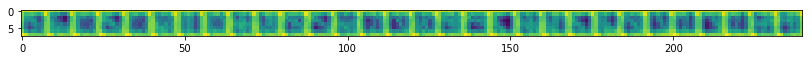

>> Epoch 1 finished 	RBM Reconstruction error 12.715200424
torch.Size([1797, 1, 8, 8])
>> Epoch 2 finished 	RBM Reconstruction error 12.242500305
torch.Size([1797, 1, 8, 8])
>> Epoch 3 finished 	RBM Reconstruction error 11.886110306
torch.Size([1797, 1, 8, 8])
>> Epoch 4 finished 	RBM Reconstruction error 11.592166901
torch.Size([1797, 1, 8, 8])
>> Epoch 5 finished 	RBM Reconstruction error 11.339051247
torch.Size([1797, 1, 8, 8])
>> Epoch 6 finished 	RBM Reconstruction error 11.114898682
torch.Size([1797, 1, 8, 8])
>> Epoch 7 finished 	RBM Reconstruction error 10.912898064
torch.Size([1797, 1, 8, 8])
>> Epoch 8 finished 	RBM Reconstruction error 10.728835106
torch.Size([1797, 1, 8, 8])
>> Epoch 9 finished 	RBM Reconstruction error 10.558923721
torch.Size([1797, 1, 8, 8])
>> Epoch 10 finished 	RBM Reconstruction error 10.401263237
torch.Size([1797, 1, 8, 8])
(8, 240)


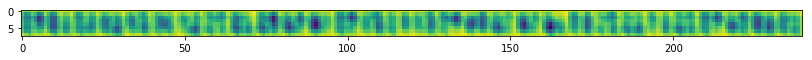

>> Epoch 11 finished 	RBM Reconstruction error 10.254023552
torch.Size([1797, 1, 8, 8])
>> Epoch 12 finished 	RBM Reconstruction error 10.115347862
torch.Size([1797, 1, 8, 8])
>> Epoch 13 finished 	RBM Reconstruction error 9.984368324
torch.Size([1797, 1, 8, 8])
>> Epoch 14 finished 	RBM Reconstruction error 9.860099792
torch.Size([1797, 1, 8, 8])
>> Epoch 15 finished 	RBM Reconstruction error 9.741381645
torch.Size([1797, 1, 8, 8])
>> Epoch 16 finished 	RBM Reconstruction error 9.627319336
torch.Size([1797, 1, 8, 8])
>> Epoch 17 finished 	RBM Reconstruction error 9.517413139
torch.Size([1797, 1, 8, 8])
>> Epoch 18 finished 	RBM Reconstruction error 9.410446167
torch.Size([1797, 1, 8, 8])
>> Epoch 19 finished 	RBM Reconstruction error 9.306761742
torch.Size([1797, 1, 8, 8])
>> Epoch 20 finished 	RBM Reconstruction error 9.204633713
torch.Size([1797, 1, 8, 8])
(8, 240)


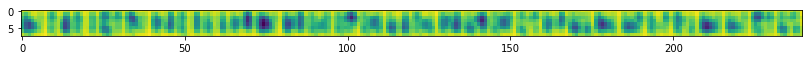

>> Epoch 21 finished 	RBM Reconstruction error 9.103280067
torch.Size([1797, 1, 8, 8])
>> Epoch 22 finished 	RBM Reconstruction error 9.001993179
torch.Size([1797, 1, 8, 8])
>> Epoch 23 finished 	RBM Reconstruction error 8.899447441
torch.Size([1797, 1, 8, 8])
>> Epoch 24 finished 	RBM Reconstruction error 8.794243813
torch.Size([1797, 1, 8, 8])
>> Epoch 25 finished 	RBM Reconstruction error 8.684672356
torch.Size([1797, 1, 8, 8])
>> Epoch 26 finished 	RBM Reconstruction error 8.567883492
torch.Size([1797, 1, 8, 8])
>> Epoch 27 finished 	RBM Reconstruction error 8.441203117
torch.Size([1797, 1, 8, 8])
>> Epoch 28 finished 	RBM Reconstruction error 8.299040794
torch.Size([1797, 1, 8, 8])
>> Epoch 29 finished 	RBM Reconstruction error 8.134840965
torch.Size([1797, 1, 8, 8])
>> Epoch 30 finished 	RBM Reconstruction error 7.937889099
torch.Size([1797, 1, 8, 8])
(8, 240)


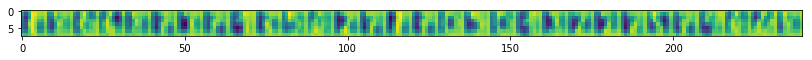

>> Epoch 31 finished 	RBM Reconstruction error 7.692261696
torch.Size([1797, 1, 8, 8])
>> Epoch 32 finished 	RBM Reconstruction error 7.374452114
torch.Size([1797, 1, 8, 8])
>> Epoch 33 finished 	RBM Reconstruction error 6.956520081
torch.Size([1797, 1, 8, 8])
>> Epoch 34 finished 	RBM Reconstruction error 6.421391964
torch.Size([1797, 1, 8, 8])
>> Epoch 35 finished 	RBM Reconstruction error 5.836533546
torch.Size([1797, 1, 8, 8])
>> Epoch 36 finished 	RBM Reconstruction error 5.385266781
torch.Size([1797, 1, 8, 8])
>> Epoch 37 finished 	RBM Reconstruction error 5.176680565
torch.Size([1797, 1, 8, 8])
>> Epoch 38 finished 	RBM Reconstruction error 5.074057579
torch.Size([1797, 1, 8, 8])
>> Epoch 39 finished 	RBM Reconstruction error 5.004952431
torch.Size([1797, 1, 8, 8])
>> Epoch 40 finished 	RBM Reconstruction error 4.929338932
torch.Size([1797, 1, 8, 8])
(8, 240)


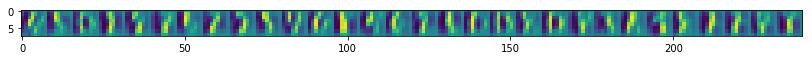

>> Epoch 41 finished 	RBM Reconstruction error 4.885786057
torch.Size([1797, 1, 8, 8])
>> Epoch 42 finished 	RBM Reconstruction error 4.830972195
torch.Size([1797, 1, 8, 8])
>> Epoch 43 finished 	RBM Reconstruction error 4.777699947
torch.Size([1797, 1, 8, 8])
>> Epoch 44 finished 	RBM Reconstruction error 4.722920418
torch.Size([1797, 1, 8, 8])
>> Epoch 45 finished 	RBM Reconstruction error 4.675510406
torch.Size([1797, 1, 8, 8])
>> Epoch 46 finished 	RBM Reconstruction error 4.623370171
torch.Size([1797, 1, 8, 8])
>> Epoch 47 finished 	RBM Reconstruction error 4.582144737
torch.Size([1797, 1, 8, 8])
>> Epoch 48 finished 	RBM Reconstruction error 4.536315918
torch.Size([1797, 1, 8, 8])
>> Epoch 49 finished 	RBM Reconstruction error 4.487737179
torch.Size([1797, 1, 8, 8])
>> Epoch 50 finished 	RBM Reconstruction error 4.428943634
torch.Size([1797, 1, 8, 8])
(8, 240)


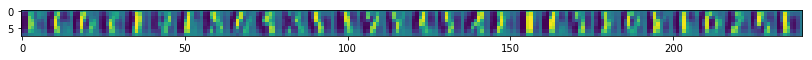

>> Epoch 51 finished 	RBM Reconstruction error 4.379908562
torch.Size([1797, 1, 8, 8])
>> Epoch 52 finished 	RBM Reconstruction error 4.330820084
torch.Size([1797, 1, 8, 8])
>> Epoch 53 finished 	RBM Reconstruction error 4.277104378
torch.Size([1797, 1, 8, 8])
>> Epoch 54 finished 	RBM Reconstruction error 4.218437195
torch.Size([1797, 1, 8, 8])
>> Epoch 55 finished 	RBM Reconstruction error 4.154280663
torch.Size([1797, 1, 8, 8])
>> Epoch 56 finished 	RBM Reconstruction error 4.088309765
torch.Size([1797, 1, 8, 8])
>> Epoch 57 finished 	RBM Reconstruction error 4.009884834
torch.Size([1797, 1, 8, 8])
>> Epoch 58 finished 	RBM Reconstruction error 3.933175564
torch.Size([1797, 1, 8, 8])
>> Epoch 59 finished 	RBM Reconstruction error 3.844074726
torch.Size([1797, 1, 8, 8])
>> Epoch 60 finished 	RBM Reconstruction error 3.753610849
torch.Size([1797, 1, 8, 8])
(8, 240)


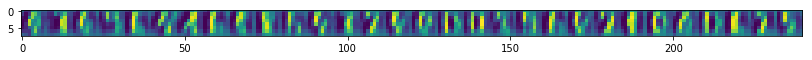

>> Epoch 61 finished 	RBM Reconstruction error 3.638519526
torch.Size([1797, 1, 8, 8])
>> Epoch 62 finished 	RBM Reconstruction error 3.545017004
torch.Size([1797, 1, 8, 8])
>> Epoch 63 finished 	RBM Reconstruction error 3.441520691
torch.Size([1797, 1, 8, 8])
>> Epoch 64 finished 	RBM Reconstruction error 3.344452620
torch.Size([1797, 1, 8, 8])
>> Epoch 65 finished 	RBM Reconstruction error 3.248836994
torch.Size([1797, 1, 8, 8])
>> Epoch 66 finished 	RBM Reconstruction error 3.157476902
torch.Size([1797, 1, 8, 8])
>> Epoch 67 finished 	RBM Reconstruction error 3.098339319
torch.Size([1797, 1, 8, 8])
>> Epoch 68 finished 	RBM Reconstruction error 3.043229103
torch.Size([1797, 1, 8, 8])
>> Epoch 69 finished 	RBM Reconstruction error 3.001945972
torch.Size([1797, 1, 8, 8])
>> Epoch 70 finished 	RBM Reconstruction error 2.970550060
torch.Size([1797, 1, 8, 8])
(8, 240)


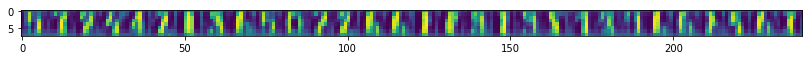

>> Epoch 71 finished 	RBM Reconstruction error 2.941725492
torch.Size([1797, 1, 8, 8])
>> Epoch 72 finished 	RBM Reconstruction error 2.917969704
torch.Size([1797, 1, 8, 8])
>> Epoch 73 finished 	RBM Reconstruction error 2.897524357
torch.Size([1797, 1, 8, 8])
>> Epoch 74 finished 	RBM Reconstruction error 2.883711576
torch.Size([1797, 1, 8, 8])
>> Epoch 75 finished 	RBM Reconstruction error 2.862860918
torch.Size([1797, 1, 8, 8])
>> Epoch 76 finished 	RBM Reconstruction error 2.847228765
torch.Size([1797, 1, 8, 8])
>> Epoch 77 finished 	RBM Reconstruction error 2.839560270
torch.Size([1797, 1, 8, 8])
>> Epoch 78 finished 	RBM Reconstruction error 2.826526165
torch.Size([1797, 1, 8, 8])
>> Epoch 79 finished 	RBM Reconstruction error 2.815239668
torch.Size([1797, 1, 8, 8])
>> Epoch 80 finished 	RBM Reconstruction error 2.798831224
torch.Size([1797, 1, 8, 8])
(8, 240)


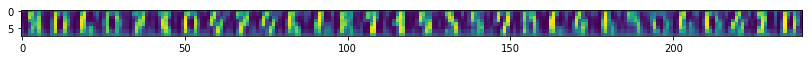

>> Epoch 81 finished 	RBM Reconstruction error 2.787864923
torch.Size([1797, 1, 8, 8])
>> Epoch 82 finished 	RBM Reconstruction error 2.778543711
torch.Size([1797, 1, 8, 8])
>> Epoch 83 finished 	RBM Reconstruction error 2.766299725
torch.Size([1797, 1, 8, 8])
>> Epoch 84 finished 	RBM Reconstruction error 2.760560036
torch.Size([1797, 1, 8, 8])
>> Epoch 85 finished 	RBM Reconstruction error 2.751242399
torch.Size([1797, 1, 8, 8])
>> Epoch 86 finished 	RBM Reconstruction error 2.743364573
torch.Size([1797, 1, 8, 8])
>> Epoch 87 finished 	RBM Reconstruction error 2.729788780
torch.Size([1797, 1, 8, 8])
>> Epoch 88 finished 	RBM Reconstruction error 2.725828648
torch.Size([1797, 1, 8, 8])
>> Epoch 89 finished 	RBM Reconstruction error 2.711814404
torch.Size([1797, 1, 8, 8])
>> Epoch 90 finished 	RBM Reconstruction error 2.707036734
torch.Size([1797, 1, 8, 8])
(8, 240)


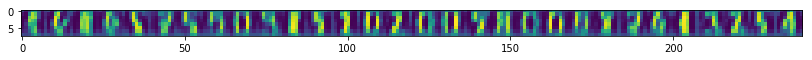

>> Epoch 91 finished 	RBM Reconstruction error 2.697434425
torch.Size([1797, 1, 8, 8])
>> Epoch 92 finished 	RBM Reconstruction error 2.693310261
torch.Size([1797, 1, 8, 8])
>> Epoch 93 finished 	RBM Reconstruction error 2.686624050
torch.Size([1797, 1, 8, 8])
>> Epoch 94 finished 	RBM Reconstruction error 2.684175491
torch.Size([1797, 1, 8, 8])
>> Epoch 95 finished 	RBM Reconstruction error 2.670696259
torch.Size([1797, 1, 8, 8])
>> Epoch 96 finished 	RBM Reconstruction error 2.670421839
torch.Size([1797, 1, 8, 8])
>> Epoch 97 finished 	RBM Reconstruction error 2.660687447
torch.Size([1797, 1, 8, 8])
>> Epoch 98 finished 	RBM Reconstruction error 2.652576923
torch.Size([1797, 1, 8, 8])
>> Epoch 99 finished 	RBM Reconstruction error 2.649530172
torch.Size([1797, 1, 8, 8])
>> Epoch 100 finished 	RBM Reconstruction error 2.642595053
torch.Size([1797, 1, 8, 8])
(8, 240)


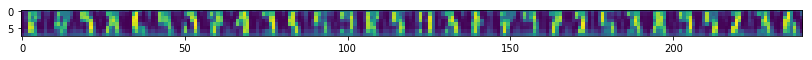

>> Epoch 101 finished 	RBM Reconstruction error 2.637926340
torch.Size([1797, 1, 8, 8])
>> Epoch 102 finished 	RBM Reconstruction error 2.626039982
torch.Size([1797, 1, 8, 8])
>> Epoch 103 finished 	RBM Reconstruction error 2.621974707
torch.Size([1797, 1, 8, 8])
>> Epoch 104 finished 	RBM Reconstruction error 2.619177818
torch.Size([1797, 1, 8, 8])
>> Epoch 105 finished 	RBM Reconstruction error 2.612464905
torch.Size([1797, 1, 8, 8])
>> Epoch 106 finished 	RBM Reconstruction error 2.604243517
torch.Size([1797, 1, 8, 8])
>> Epoch 107 finished 	RBM Reconstruction error 2.602467775
torch.Size([1797, 1, 8, 8])
>> Epoch 108 finished 	RBM Reconstruction error 2.598077536
torch.Size([1797, 1, 8, 8])
>> Epoch 109 finished 	RBM Reconstruction error 2.593636513
torch.Size([1797, 1, 8, 8])
>> Epoch 110 finished 	RBM Reconstruction error 2.589389563
torch.Size([1797, 1, 8, 8])
(8, 240)


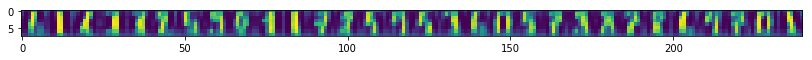

>> Epoch 111 finished 	RBM Reconstruction error 2.584860802
torch.Size([1797, 1, 8, 8])
>> Epoch 112 finished 	RBM Reconstruction error 2.574786186
torch.Size([1797, 1, 8, 8])
>> Epoch 113 finished 	RBM Reconstruction error 2.575648785
torch.Size([1797, 1, 8, 8])
>> Epoch 114 finished 	RBM Reconstruction error 2.566760540
torch.Size([1797, 1, 8, 8])
>> Epoch 115 finished 	RBM Reconstruction error 2.561472416
torch.Size([1797, 1, 8, 8])
>> Epoch 116 finished 	RBM Reconstruction error 2.558983326
torch.Size([1797, 1, 8, 8])
>> Epoch 117 finished 	RBM Reconstruction error 2.555954456
torch.Size([1797, 1, 8, 8])
>> Epoch 118 finished 	RBM Reconstruction error 2.545596361
torch.Size([1797, 1, 8, 8])
>> Epoch 119 finished 	RBM Reconstruction error 2.540570498
torch.Size([1797, 1, 8, 8])
>> Epoch 120 finished 	RBM Reconstruction error 2.535013676
torch.Size([1797, 1, 8, 8])
(8, 240)


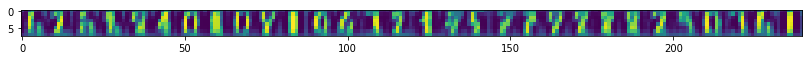

>> Epoch 121 finished 	RBM Reconstruction error 2.531572104
torch.Size([1797, 1, 8, 8])
>> Epoch 122 finished 	RBM Reconstruction error 2.524156332
torch.Size([1797, 1, 8, 8])
>> Epoch 123 finished 	RBM Reconstruction error 2.517848253
torch.Size([1797, 1, 8, 8])
>> Epoch 124 finished 	RBM Reconstruction error 2.513067722
torch.Size([1797, 1, 8, 8])
>> Epoch 125 finished 	RBM Reconstruction error 2.507685423
torch.Size([1797, 1, 8, 8])
>> Epoch 126 finished 	RBM Reconstruction error 2.504026651
torch.Size([1797, 1, 8, 8])
>> Epoch 127 finished 	RBM Reconstruction error 2.495755911
torch.Size([1797, 1, 8, 8])
>> Epoch 128 finished 	RBM Reconstruction error 2.484727859
torch.Size([1797, 1, 8, 8])
>> Epoch 129 finished 	RBM Reconstruction error 2.480773211
torch.Size([1797, 1, 8, 8])
>> Epoch 130 finished 	RBM Reconstruction error 2.473387718
torch.Size([1797, 1, 8, 8])
(8, 240)


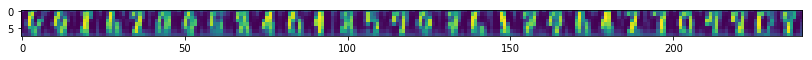

>> Epoch 131 finished 	RBM Reconstruction error 2.470404863
torch.Size([1797, 1, 8, 8])
>> Epoch 132 finished 	RBM Reconstruction error 2.458366871
torch.Size([1797, 1, 8, 8])
>> Epoch 133 finished 	RBM Reconstruction error 2.454159975
torch.Size([1797, 1, 8, 8])
>> Epoch 134 finished 	RBM Reconstruction error 2.439046383
torch.Size([1797, 1, 8, 8])
>> Epoch 135 finished 	RBM Reconstruction error 2.435633183
torch.Size([1797, 1, 8, 8])
>> Epoch 136 finished 	RBM Reconstruction error 2.428674459
torch.Size([1797, 1, 8, 8])
>> Epoch 137 finished 	RBM Reconstruction error 2.422518969
torch.Size([1797, 1, 8, 8])
>> Epoch 138 finished 	RBM Reconstruction error 2.406715631
torch.Size([1797, 1, 8, 8])
>> Epoch 139 finished 	RBM Reconstruction error 2.402112484
torch.Size([1797, 1, 8, 8])
>> Epoch 140 finished 	RBM Reconstruction error 2.393623352
torch.Size([1797, 1, 8, 8])
(8, 240)


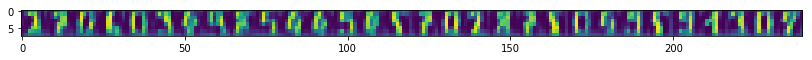

>> Epoch 141 finished 	RBM Reconstruction error 2.379349470
torch.Size([1797, 1, 8, 8])
>> Epoch 142 finished 	RBM Reconstruction error 2.364652395
torch.Size([1797, 1, 8, 8])
>> Epoch 143 finished 	RBM Reconstruction error 2.354735136
torch.Size([1797, 1, 8, 8])
>> Epoch 144 finished 	RBM Reconstruction error 2.346226454
torch.Size([1797, 1, 8, 8])
>> Epoch 145 finished 	RBM Reconstruction error 2.333074808
torch.Size([1797, 1, 8, 8])
>> Epoch 146 finished 	RBM Reconstruction error 2.325622320
torch.Size([1797, 1, 8, 8])
>> Epoch 147 finished 	RBM Reconstruction error 2.315875530
torch.Size([1797, 1, 8, 8])
>> Epoch 148 finished 	RBM Reconstruction error 2.301206589
torch.Size([1797, 1, 8, 8])
>> Epoch 149 finished 	RBM Reconstruction error 2.290236950
torch.Size([1797, 1, 8, 8])
>> Epoch 150 finished 	RBM Reconstruction error 2.271953106
torch.Size([1797, 1, 8, 8])
(8, 240)


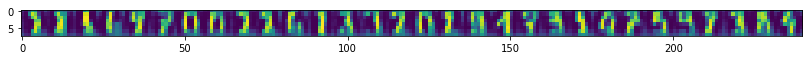

>> Epoch 151 finished 	RBM Reconstruction error 2.260963440
torch.Size([1797, 1, 8, 8])
>> Epoch 152 finished 	RBM Reconstruction error 2.247791767
torch.Size([1797, 1, 8, 8])
>> Epoch 153 finished 	RBM Reconstruction error 2.235740662
torch.Size([1797, 1, 8, 8])
>> Epoch 154 finished 	RBM Reconstruction error 2.224619150
torch.Size([1797, 1, 8, 8])
>> Epoch 155 finished 	RBM Reconstruction error 2.216070175
torch.Size([1797, 1, 8, 8])
>> Epoch 156 finished 	RBM Reconstruction error 2.207309008
torch.Size([1797, 1, 8, 8])
>> Epoch 157 finished 	RBM Reconstruction error 2.190697670
torch.Size([1797, 1, 8, 8])
>> Epoch 158 finished 	RBM Reconstruction error 2.181625366
torch.Size([1797, 1, 8, 8])
>> Epoch 159 finished 	RBM Reconstruction error 2.173182249
torch.Size([1797, 1, 8, 8])
>> Epoch 160 finished 	RBM Reconstruction error 2.159749508
torch.Size([1797, 1, 8, 8])
(8, 240)


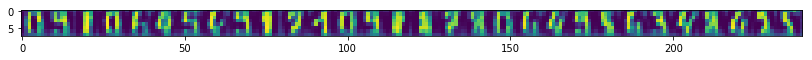

>> Epoch 161 finished 	RBM Reconstruction error 2.149981260
torch.Size([1797, 1, 8, 8])
>> Epoch 162 finished 	RBM Reconstruction error 2.141611814
torch.Size([1797, 1, 8, 8])
>> Epoch 163 finished 	RBM Reconstruction error 2.134187222
torch.Size([1797, 1, 8, 8])
>> Epoch 164 finished 	RBM Reconstruction error 2.130927086
torch.Size([1797, 1, 8, 8])
>> Epoch 165 finished 	RBM Reconstruction error 2.124827862
torch.Size([1797, 1, 8, 8])
>> Epoch 166 finished 	RBM Reconstruction error 2.116883278
torch.Size([1797, 1, 8, 8])
>> Epoch 167 finished 	RBM Reconstruction error 2.114234209
torch.Size([1797, 1, 8, 8])
>> Epoch 168 finished 	RBM Reconstruction error 2.113849878
torch.Size([1797, 1, 8, 8])
>> Epoch 169 finished 	RBM Reconstruction error 2.104923725
torch.Size([1797, 1, 8, 8])
>> Epoch 170 finished 	RBM Reconstruction error 2.097398281
torch.Size([1797, 1, 8, 8])
(8, 240)


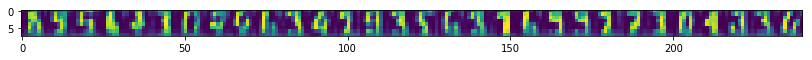

>> Epoch 171 finished 	RBM Reconstruction error 2.091166496
torch.Size([1797, 1, 8, 8])
>> Epoch 172 finished 	RBM Reconstruction error 2.089941263
torch.Size([1797, 1, 8, 8])
>> Epoch 173 finished 	RBM Reconstruction error 2.087478161
torch.Size([1797, 1, 8, 8])
>> Epoch 174 finished 	RBM Reconstruction error 2.085427999
torch.Size([1797, 1, 8, 8])
>> Epoch 175 finished 	RBM Reconstruction error 2.084233999
torch.Size([1797, 1, 8, 8])
>> Epoch 176 finished 	RBM Reconstruction error 2.081225872
torch.Size([1797, 1, 8, 8])
>> Epoch 177 finished 	RBM Reconstruction error 2.080581427
torch.Size([1797, 1, 8, 8])
>> Epoch 178 finished 	RBM Reconstruction error 2.077757359
torch.Size([1797, 1, 8, 8])
>> Epoch 179 finished 	RBM Reconstruction error 2.074606180
torch.Size([1797, 1, 8, 8])
>> Epoch 180 finished 	RBM Reconstruction error 2.075577259
torch.Size([1797, 1, 8, 8])
(8, 240)


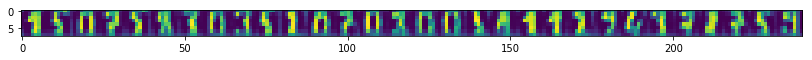

>> Epoch 181 finished 	RBM Reconstruction error 2.071145773
torch.Size([1797, 1, 8, 8])
>> Epoch 182 finished 	RBM Reconstruction error 2.068584681
torch.Size([1797, 1, 8, 8])
>> Epoch 183 finished 	RBM Reconstruction error 2.065636635
torch.Size([1797, 1, 8, 8])
>> Epoch 184 finished 	RBM Reconstruction error 2.067318678
torch.Size([1797, 1, 8, 8])
>> Epoch 185 finished 	RBM Reconstruction error 2.064233541
torch.Size([1797, 1, 8, 8])
>> Epoch 186 finished 	RBM Reconstruction error 2.065440178
torch.Size([1797, 1, 8, 8])
>> Epoch 187 finished 	RBM Reconstruction error 2.060476780
torch.Size([1797, 1, 8, 8])
>> Epoch 188 finished 	RBM Reconstruction error 2.062833071
torch.Size([1797, 1, 8, 8])
>> Epoch 189 finished 	RBM Reconstruction error 2.059555531
torch.Size([1797, 1, 8, 8])
>> Epoch 190 finished 	RBM Reconstruction error 2.060713530
torch.Size([1797, 1, 8, 8])
(8, 240)


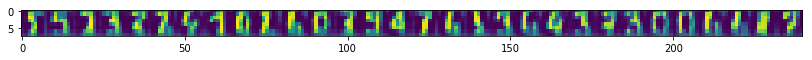

>> Epoch 191 finished 	RBM Reconstruction error 2.057139635
torch.Size([1797, 1, 8, 8])
>> Epoch 192 finished 	RBM Reconstruction error 2.058930635
torch.Size([1797, 1, 8, 8])
>> Epoch 193 finished 	RBM Reconstruction error 2.054693222
torch.Size([1797, 1, 8, 8])
>> Epoch 194 finished 	RBM Reconstruction error 2.056102991
torch.Size([1797, 1, 8, 8])
>> Epoch 195 finished 	RBM Reconstruction error 2.055408955
torch.Size([1797, 1, 8, 8])
>> Epoch 196 finished 	RBM Reconstruction error 2.055546284
torch.Size([1797, 1, 8, 8])
>> Epoch 197 finished 	RBM Reconstruction error 2.055737734
torch.Size([1797, 1, 8, 8])
>> Epoch 198 finished 	RBM Reconstruction error 2.055511236
torch.Size([1797, 1, 8, 8])
>> Epoch 199 finished 	RBM Reconstruction error 2.052477360
torch.Size([1797, 1, 8, 8])
>> Epoch 200 finished 	RBM Reconstruction error 2.053682566
torch.Size([1797, 1, 8, 8])
(8, 240)


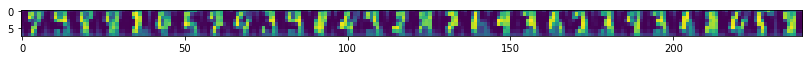

>> Epoch 201 finished 	RBM Reconstruction error 2.052217484
torch.Size([1797, 1, 8, 8])
>> Epoch 202 finished 	RBM Reconstruction error 2.056506634
torch.Size([1797, 1, 8, 8])
>> Epoch 203 finished 	RBM Reconstruction error 2.051968575
torch.Size([1797, 1, 8, 8])
>> Epoch 204 finished 	RBM Reconstruction error 2.052120924
torch.Size([1797, 1, 8, 8])
>> Epoch 205 finished 	RBM Reconstruction error 2.053354025
torch.Size([1797, 1, 8, 8])
>> Epoch 206 finished 	RBM Reconstruction error 2.051862955
torch.Size([1797, 1, 8, 8])
>> Epoch 207 finished 	RBM Reconstruction error 2.052276134
torch.Size([1797, 1, 8, 8])
>> Epoch 208 finished 	RBM Reconstruction error 2.054129362
torch.Size([1797, 1, 8, 8])
>> Epoch 209 finished 	RBM Reconstruction error 2.056349039
torch.Size([1797, 1, 8, 8])
>> Epoch 210 finished 	RBM Reconstruction error 2.051201344
torch.Size([1797, 1, 8, 8])
(8, 240)


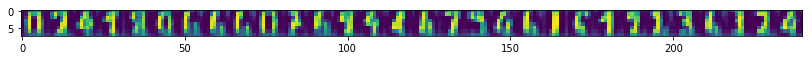

>> Epoch 211 finished 	RBM Reconstruction error 2.050103664
torch.Size([1797, 1, 8, 8])
>> Epoch 212 finished 	RBM Reconstruction error 2.050352335
torch.Size([1797, 1, 8, 8])
>> Epoch 213 finished 	RBM Reconstruction error 2.047882557
torch.Size([1797, 1, 8, 8])
>> Epoch 214 finished 	RBM Reconstruction error 2.051730156
torch.Size([1797, 1, 8, 8])
>> Epoch 215 finished 	RBM Reconstruction error 2.052776575
torch.Size([1797, 1, 8, 8])
>> Epoch 216 finished 	RBM Reconstruction error 2.048036337
torch.Size([1797, 1, 8, 8])
>> Epoch 217 finished 	RBM Reconstruction error 2.050157547
torch.Size([1797, 1, 8, 8])
>> Epoch 218 finished 	RBM Reconstruction error 2.047199488
torch.Size([1797, 1, 8, 8])
>> Epoch 219 finished 	RBM Reconstruction error 2.046424627
torch.Size([1797, 1, 8, 8])
>> Epoch 220 finished 	RBM Reconstruction error 2.049002647
torch.Size([1797, 1, 8, 8])
(8, 240)


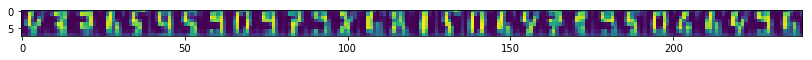

>> Epoch 221 finished 	RBM Reconstruction error 2.048466682
torch.Size([1797, 1, 8, 8])
>> Epoch 222 finished 	RBM Reconstruction error 2.050137520
torch.Size([1797, 1, 8, 8])
>> Epoch 223 finished 	RBM Reconstruction error 2.049866438
torch.Size([1797, 1, 8, 8])
>> Epoch 224 finished 	RBM Reconstruction error 2.050463676
torch.Size([1797, 1, 8, 8])
>> Epoch 225 finished 	RBM Reconstruction error 2.050887823
torch.Size([1797, 1, 8, 8])
>> Epoch 226 finished 	RBM Reconstruction error 2.049570084
torch.Size([1797, 1, 8, 8])
>> Epoch 227 finished 	RBM Reconstruction error 2.046138048
torch.Size([1797, 1, 8, 8])
>> Epoch 228 finished 	RBM Reconstruction error 2.052544594
torch.Size([1797, 1, 8, 8])
>> Epoch 229 finished 	RBM Reconstruction error 2.053855896
torch.Size([1797, 1, 8, 8])
>> Epoch 230 finished 	RBM Reconstruction error 2.051846743
torch.Size([1797, 1, 8, 8])
(8, 240)


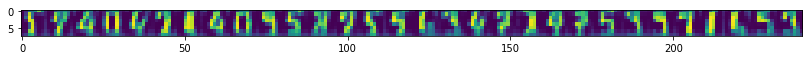

>> Epoch 231 finished 	RBM Reconstruction error 2.054508924
torch.Size([1797, 1, 8, 8])
>> Epoch 232 finished 	RBM Reconstruction error 2.053970337
torch.Size([1797, 1, 8, 8])
>> Epoch 233 finished 	RBM Reconstruction error 2.049725056
torch.Size([1797, 1, 8, 8])
>> Epoch 234 finished 	RBM Reconstruction error 2.054599762
torch.Size([1797, 1, 8, 8])
>> Epoch 235 finished 	RBM Reconstruction error 2.050848961
torch.Size([1797, 1, 8, 8])
>> Epoch 236 finished 	RBM Reconstruction error 2.051911354
torch.Size([1797, 1, 8, 8])
>> Epoch 237 finished 	RBM Reconstruction error 2.053400755
torch.Size([1797, 1, 8, 8])
>> Epoch 238 finished 	RBM Reconstruction error 2.050504208
torch.Size([1797, 1, 8, 8])
>> Epoch 239 finished 	RBM Reconstruction error 2.052028179
torch.Size([1797, 1, 8, 8])
>> Epoch 240 finished 	RBM Reconstruction error 2.047582150
torch.Size([1797, 1, 8, 8])
(8, 240)


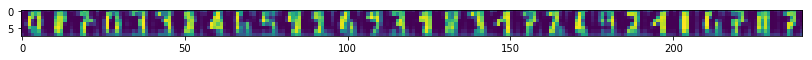

>> Epoch 241 finished 	RBM Reconstruction error 2.047505140
torch.Size([1797, 1, 8, 8])
>> Epoch 242 finished 	RBM Reconstruction error 2.047787666
torch.Size([1797, 1, 8, 8])
>> Epoch 243 finished 	RBM Reconstruction error 2.047245741
torch.Size([1797, 1, 8, 8])
>> Epoch 244 finished 	RBM Reconstruction error 2.047878504
torch.Size([1797, 1, 8, 8])
>> Epoch 245 finished 	RBM Reconstruction error 2.046972752
torch.Size([1797, 1, 8, 8])
>> Epoch 246 finished 	RBM Reconstruction error 2.051319599
torch.Size([1797, 1, 8, 8])
>> Epoch 247 finished 	RBM Reconstruction error 2.051634073
torch.Size([1797, 1, 8, 8])
>> Epoch 248 finished 	RBM Reconstruction error 2.047358036
torch.Size([1797, 1, 8, 8])
>> Epoch 249 finished 	RBM Reconstruction error 2.050079823
torch.Size([1797, 1, 8, 8])
>> Epoch 250 finished 	RBM Reconstruction error 2.050012589
torch.Size([1797, 1, 8, 8])
(8, 240)


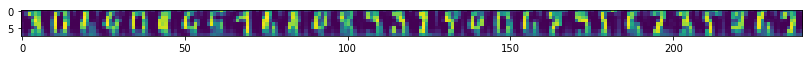

>> Epoch 251 finished 	RBM Reconstruction error 2.050558805
torch.Size([1797, 1, 8, 8])
>> Epoch 252 finished 	RBM Reconstruction error 2.048630476
torch.Size([1797, 1, 8, 8])
>> Epoch 253 finished 	RBM Reconstruction error 2.048649788
torch.Size([1797, 1, 8, 8])
>> Epoch 254 finished 	RBM Reconstruction error 2.047579527
torch.Size([1797, 1, 8, 8])
>> Epoch 255 finished 	RBM Reconstruction error 2.047780037
torch.Size([1797, 1, 8, 8])
>> Epoch 256 finished 	RBM Reconstruction error 2.045919657
torch.Size([1797, 1, 8, 8])
>> Epoch 257 finished 	RBM Reconstruction error 2.046433926
torch.Size([1797, 1, 8, 8])
>> Epoch 258 finished 	RBM Reconstruction error 2.046492100
torch.Size([1797, 1, 8, 8])
>> Epoch 259 finished 	RBM Reconstruction error 2.050358534
torch.Size([1797, 1, 8, 8])
>> Epoch 260 finished 	RBM Reconstruction error 2.048538923
torch.Size([1797, 1, 8, 8])
(8, 240)


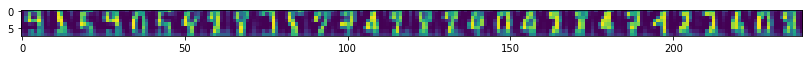

>> Epoch 261 finished 	RBM Reconstruction error 2.049899578
torch.Size([1797, 1, 8, 8])
>> Epoch 262 finished 	RBM Reconstruction error 2.045663118
torch.Size([1797, 1, 8, 8])
>> Epoch 263 finished 	RBM Reconstruction error 2.049271584
torch.Size([1797, 1, 8, 8])
>> Epoch 264 finished 	RBM Reconstruction error 2.048219442
torch.Size([1797, 1, 8, 8])
>> Epoch 265 finished 	RBM Reconstruction error 2.047885180
torch.Size([1797, 1, 8, 8])
>> Epoch 266 finished 	RBM Reconstruction error 2.046695709
torch.Size([1797, 1, 8, 8])
>> Epoch 267 finished 	RBM Reconstruction error 2.047260761
torch.Size([1797, 1, 8, 8])
>> Epoch 268 finished 	RBM Reconstruction error 2.046413183
torch.Size([1797, 1, 8, 8])
>> Epoch 269 finished 	RBM Reconstruction error 2.046592474
torch.Size([1797, 1, 8, 8])
>> Epoch 270 finished 	RBM Reconstruction error 2.045941353
torch.Size([1797, 1, 8, 8])
(8, 240)


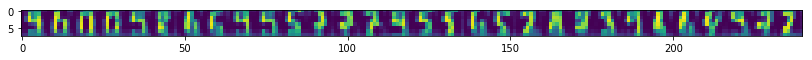

>> Epoch 271 finished 	RBM Reconstruction error 2.046694994
torch.Size([1797, 1, 8, 8])
>> Epoch 272 finished 	RBM Reconstruction error 2.045919895
torch.Size([1797, 1, 8, 8])
>> Epoch 273 finished 	RBM Reconstruction error 2.045974731
torch.Size([1797, 1, 8, 8])
>> Epoch 274 finished 	RBM Reconstruction error 2.047081232
torch.Size([1797, 1, 8, 8])
>> Epoch 275 finished 	RBM Reconstruction error 2.047164679
torch.Size([1797, 1, 8, 8])
>> Epoch 276 finished 	RBM Reconstruction error 2.043419361
torch.Size([1797, 1, 8, 8])
>> Epoch 277 finished 	RBM Reconstruction error 2.043519258
torch.Size([1797, 1, 8, 8])
>> Epoch 278 finished 	RBM Reconstruction error 2.045237303
torch.Size([1797, 1, 8, 8])
>> Epoch 279 finished 	RBM Reconstruction error 2.037679434
torch.Size([1797, 1, 8, 8])
>> Epoch 280 finished 	RBM Reconstruction error 2.041377068
torch.Size([1797, 1, 8, 8])
(8, 240)


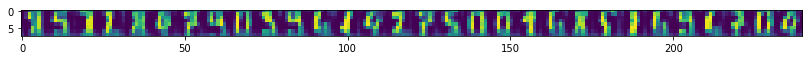

>> Epoch 281 finished 	RBM Reconstruction error 2.044452667
torch.Size([1797, 1, 8, 8])
>> Epoch 282 finished 	RBM Reconstruction error 2.044210196
torch.Size([1797, 1, 8, 8])
>> Epoch 283 finished 	RBM Reconstruction error 2.045603037
torch.Size([1797, 1, 8, 8])
>> Epoch 284 finished 	RBM Reconstruction error 2.047096252
torch.Size([1797, 1, 8, 8])
>> Epoch 285 finished 	RBM Reconstruction error 2.048356533
torch.Size([1797, 1, 8, 8])
>> Epoch 286 finished 	RBM Reconstruction error 2.043398380
torch.Size([1797, 1, 8, 8])
>> Epoch 287 finished 	RBM Reconstruction error 2.042501688
torch.Size([1797, 1, 8, 8])
>> Epoch 288 finished 	RBM Reconstruction error 2.040006399
torch.Size([1797, 1, 8, 8])
>> Epoch 289 finished 	RBM Reconstruction error 2.043885946
torch.Size([1797, 1, 8, 8])
>> Epoch 290 finished 	RBM Reconstruction error 2.041973591
torch.Size([1797, 1, 8, 8])
(8, 240)


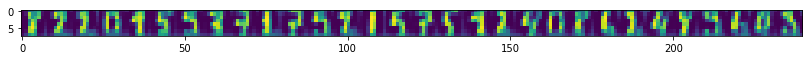

>> Epoch 291 finished 	RBM Reconstruction error 2.041792631
torch.Size([1797, 1, 8, 8])
>> Epoch 292 finished 	RBM Reconstruction error 2.045912027
torch.Size([1797, 1, 8, 8])
>> Epoch 293 finished 	RBM Reconstruction error 2.046304703
torch.Size([1797, 1, 8, 8])
>> Epoch 294 finished 	RBM Reconstruction error 2.046677828
torch.Size([1797, 1, 8, 8])
>> Epoch 295 finished 	RBM Reconstruction error 2.040005922
torch.Size([1797, 1, 8, 8])
>> Epoch 296 finished 	RBM Reconstruction error 2.041636467
torch.Size([1797, 1, 8, 8])
>> Epoch 297 finished 	RBM Reconstruction error 2.043200731
torch.Size([1797, 1, 8, 8])
>> Epoch 298 finished 	RBM Reconstruction error 2.045756340
torch.Size([1797, 1, 8, 8])
>> Epoch 299 finished 	RBM Reconstruction error 2.041151762
torch.Size([1797, 1, 8, 8])
>> Epoch 300 finished 	RBM Reconstruction error 2.042088985
torch.Size([1797, 1, 8, 8])
(8, 240)


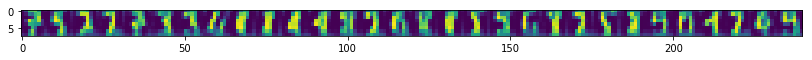

>> Epoch 301 finished 	RBM Reconstruction error 2.047303677
torch.Size([1797, 1, 8, 8])
>> Epoch 302 finished 	RBM Reconstruction error 2.039973259
torch.Size([1797, 1, 8, 8])
>> Epoch 303 finished 	RBM Reconstruction error 2.038276911
torch.Size([1797, 1, 8, 8])
>> Epoch 304 finished 	RBM Reconstruction error 2.041705370
torch.Size([1797, 1, 8, 8])
>> Epoch 305 finished 	RBM Reconstruction error 2.043302536
torch.Size([1797, 1, 8, 8])
>> Epoch 306 finished 	RBM Reconstruction error 2.041532040
torch.Size([1797, 1, 8, 8])
>> Epoch 307 finished 	RBM Reconstruction error 2.040184736
torch.Size([1797, 1, 8, 8])
>> Epoch 308 finished 	RBM Reconstruction error 2.044471502
torch.Size([1797, 1, 8, 8])
>> Epoch 309 finished 	RBM Reconstruction error 2.038506269
torch.Size([1797, 1, 8, 8])
>> Epoch 310 finished 	RBM Reconstruction error 2.038313866
torch.Size([1797, 1, 8, 8])
(8, 240)


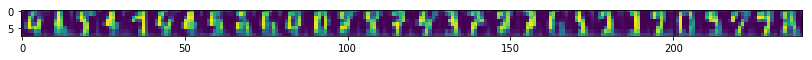

>> Epoch 311 finished 	RBM Reconstruction error 2.039222956
torch.Size([1797, 1, 8, 8])
>> Epoch 312 finished 	RBM Reconstruction error 2.043912411
torch.Size([1797, 1, 8, 8])
>> Epoch 313 finished 	RBM Reconstruction error 2.042308331
torch.Size([1797, 1, 8, 8])
>> Epoch 314 finished 	RBM Reconstruction error 2.036528349
torch.Size([1797, 1, 8, 8])
>> Epoch 315 finished 	RBM Reconstruction error 2.034853697
torch.Size([1797, 1, 8, 8])
>> Epoch 316 finished 	RBM Reconstruction error 2.033765793
torch.Size([1797, 1, 8, 8])
>> Epoch 317 finished 	RBM Reconstruction error 2.037754297
torch.Size([1797, 1, 8, 8])
>> Epoch 318 finished 	RBM Reconstruction error 2.037483931
torch.Size([1797, 1, 8, 8])
>> Epoch 319 finished 	RBM Reconstruction error 2.042064428
torch.Size([1797, 1, 8, 8])
>> Epoch 320 finished 	RBM Reconstruction error 2.041789770
torch.Size([1797, 1, 8, 8])
(8, 240)


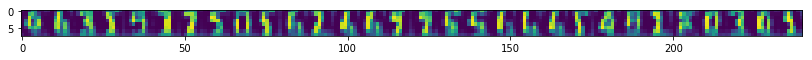

>> Epoch 321 finished 	RBM Reconstruction error 2.041176558
torch.Size([1797, 1, 8, 8])
>> Epoch 322 finished 	RBM Reconstruction error 2.036534786
torch.Size([1797, 1, 8, 8])
>> Epoch 323 finished 	RBM Reconstruction error 2.036540270
torch.Size([1797, 1, 8, 8])
>> Epoch 324 finished 	RBM Reconstruction error 2.037245035
torch.Size([1797, 1, 8, 8])
>> Epoch 325 finished 	RBM Reconstruction error 2.032896996
torch.Size([1797, 1, 8, 8])
>> Epoch 326 finished 	RBM Reconstruction error 2.035619974
torch.Size([1797, 1, 8, 8])
>> Epoch 327 finished 	RBM Reconstruction error 2.035988331
torch.Size([1797, 1, 8, 8])
>> Epoch 328 finished 	RBM Reconstruction error 2.034487247
torch.Size([1797, 1, 8, 8])
>> Epoch 329 finished 	RBM Reconstruction error 2.035120010
torch.Size([1797, 1, 8, 8])
>> Epoch 330 finished 	RBM Reconstruction error 2.041531801
torch.Size([1797, 1, 8, 8])
(8, 240)


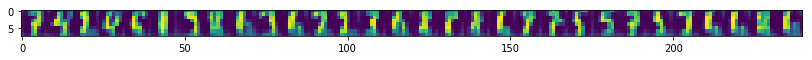

>> Epoch 331 finished 	RBM Reconstruction error 2.037271976
torch.Size([1797, 1, 8, 8])
>> Epoch 332 finished 	RBM Reconstruction error 2.040850878
torch.Size([1797, 1, 8, 8])
>> Epoch 333 finished 	RBM Reconstruction error 2.034640551
torch.Size([1797, 1, 8, 8])
>> Epoch 334 finished 	RBM Reconstruction error 2.032886028
torch.Size([1797, 1, 8, 8])
>> Epoch 335 finished 	RBM Reconstruction error 2.036934614
torch.Size([1797, 1, 8, 8])
>> Epoch 336 finished 	RBM Reconstruction error 2.036232710
torch.Size([1797, 1, 8, 8])
>> Epoch 337 finished 	RBM Reconstruction error 2.033241272
torch.Size([1797, 1, 8, 8])
>> Epoch 338 finished 	RBM Reconstruction error 2.036885977
torch.Size([1797, 1, 8, 8])
>> Epoch 339 finished 	RBM Reconstruction error 2.040829420
torch.Size([1797, 1, 8, 8])
>> Epoch 340 finished 	RBM Reconstruction error 2.035703421
torch.Size([1797, 1, 8, 8])
(8, 240)


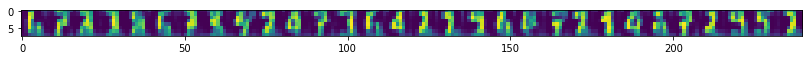

>> Epoch 341 finished 	RBM Reconstruction error 2.033561230
torch.Size([1797, 1, 8, 8])
>> Epoch 342 finished 	RBM Reconstruction error 2.036605835
torch.Size([1797, 1, 8, 8])
>> Epoch 343 finished 	RBM Reconstruction error 2.032673359
torch.Size([1797, 1, 8, 8])
>> Epoch 344 finished 	RBM Reconstruction error 2.035110235
torch.Size([1797, 1, 8, 8])
>> Epoch 345 finished 	RBM Reconstruction error 2.032961607
torch.Size([1797, 1, 8, 8])
>> Epoch 346 finished 	RBM Reconstruction error 2.031003952
torch.Size([1797, 1, 8, 8])
>> Epoch 347 finished 	RBM Reconstruction error 2.031802654
torch.Size([1797, 1, 8, 8])
>> Epoch 348 finished 	RBM Reconstruction error 2.032011271
torch.Size([1797, 1, 8, 8])
>> Epoch 349 finished 	RBM Reconstruction error 2.033556223
torch.Size([1797, 1, 8, 8])
>> Epoch 350 finished 	RBM Reconstruction error 2.031248569
torch.Size([1797, 1, 8, 8])
(8, 240)


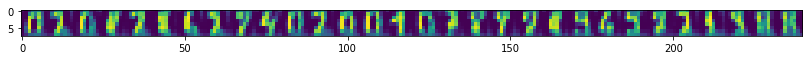

>> Epoch 351 finished 	RBM Reconstruction error 2.030708551
torch.Size([1797, 1, 8, 8])
>> Epoch 352 finished 	RBM Reconstruction error 2.031547546
torch.Size([1797, 1, 8, 8])
>> Epoch 353 finished 	RBM Reconstruction error 2.030968189
torch.Size([1797, 1, 8, 8])
>> Epoch 354 finished 	RBM Reconstruction error 2.028907776
torch.Size([1797, 1, 8, 8])
>> Epoch 355 finished 	RBM Reconstruction error 2.034746170
torch.Size([1797, 1, 8, 8])
>> Epoch 356 finished 	RBM Reconstruction error 2.033792257
torch.Size([1797, 1, 8, 8])
>> Epoch 357 finished 	RBM Reconstruction error 2.029123783
torch.Size([1797, 1, 8, 8])
>> Epoch 358 finished 	RBM Reconstruction error 2.031279087
torch.Size([1797, 1, 8, 8])
>> Epoch 359 finished 	RBM Reconstruction error 2.032591105
torch.Size([1797, 1, 8, 8])
>> Epoch 360 finished 	RBM Reconstruction error 2.027163029
torch.Size([1797, 1, 8, 8])
(8, 240)


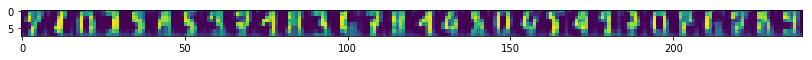

>> Epoch 361 finished 	RBM Reconstruction error 2.028726339
torch.Size([1797, 1, 8, 8])
>> Epoch 362 finished 	RBM Reconstruction error 2.030479670
torch.Size([1797, 1, 8, 8])
>> Epoch 363 finished 	RBM Reconstruction error 2.028202534
torch.Size([1797, 1, 8, 8])
>> Epoch 364 finished 	RBM Reconstruction error 2.026213408
torch.Size([1797, 1, 8, 8])
>> Epoch 365 finished 	RBM Reconstruction error 2.025866270
torch.Size([1797, 1, 8, 8])
>> Epoch 366 finished 	RBM Reconstruction error 2.027203083
torch.Size([1797, 1, 8, 8])
>> Epoch 367 finished 	RBM Reconstruction error 2.030440092
torch.Size([1797, 1, 8, 8])
>> Epoch 368 finished 	RBM Reconstruction error 2.029214859
torch.Size([1797, 1, 8, 8])
>> Epoch 369 finished 	RBM Reconstruction error 2.027513504
torch.Size([1797, 1, 8, 8])
>> Epoch 370 finished 	RBM Reconstruction error 2.025679827
torch.Size([1797, 1, 8, 8])
(8, 240)


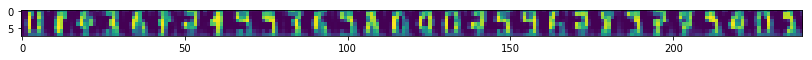

>> Epoch 371 finished 	RBM Reconstruction error 2.029019833
torch.Size([1797, 1, 8, 8])
>> Epoch 372 finished 	RBM Reconstruction error 2.026258469
torch.Size([1797, 1, 8, 8])
>> Epoch 373 finished 	RBM Reconstruction error 2.024463654
torch.Size([1797, 1, 8, 8])
>> Epoch 374 finished 	RBM Reconstruction error 2.025074482
torch.Size([1797, 1, 8, 8])
>> Epoch 375 finished 	RBM Reconstruction error 2.023962498
torch.Size([1797, 1, 8, 8])
>> Epoch 376 finished 	RBM Reconstruction error 2.027715683
torch.Size([1797, 1, 8, 8])
>> Epoch 377 finished 	RBM Reconstruction error 2.022150040
torch.Size([1797, 1, 8, 8])
>> Epoch 378 finished 	RBM Reconstruction error 2.020961761
torch.Size([1797, 1, 8, 8])
>> Epoch 379 finished 	RBM Reconstruction error 2.019818544
torch.Size([1797, 1, 8, 8])
>> Epoch 380 finished 	RBM Reconstruction error 2.019396067
torch.Size([1797, 1, 8, 8])
(8, 240)


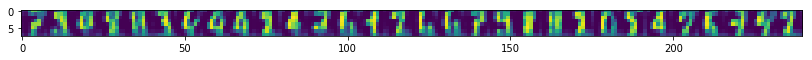

>> Epoch 381 finished 	RBM Reconstruction error 2.020650148
torch.Size([1797, 1, 8, 8])
>> Epoch 382 finished 	RBM Reconstruction error 2.022663832
torch.Size([1797, 1, 8, 8])
>> Epoch 383 finished 	RBM Reconstruction error 2.022236109
torch.Size([1797, 1, 8, 8])
>> Epoch 384 finished 	RBM Reconstruction error 2.016614914
torch.Size([1797, 1, 8, 8])
>> Epoch 385 finished 	RBM Reconstruction error 2.017889977
torch.Size([1797, 1, 8, 8])
>> Epoch 386 finished 	RBM Reconstruction error 2.014794350
torch.Size([1797, 1, 8, 8])
>> Epoch 387 finished 	RBM Reconstruction error 2.013751745
torch.Size([1797, 1, 8, 8])
>> Epoch 388 finished 	RBM Reconstruction error 2.017754555
torch.Size([1797, 1, 8, 8])
>> Epoch 389 finished 	RBM Reconstruction error 2.016367674
torch.Size([1797, 1, 8, 8])
>> Epoch 390 finished 	RBM Reconstruction error 2.015876055
torch.Size([1797, 1, 8, 8])
(8, 240)


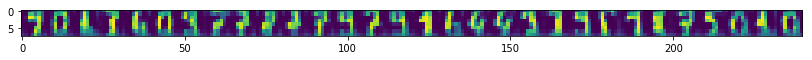

>> Epoch 391 finished 	RBM Reconstruction error 2.016559362
torch.Size([1797, 1, 8, 8])
>> Epoch 392 finished 	RBM Reconstruction error 2.011693239
torch.Size([1797, 1, 8, 8])
>> Epoch 393 finished 	RBM Reconstruction error 2.017221451
torch.Size([1797, 1, 8, 8])
>> Epoch 394 finished 	RBM Reconstruction error 2.009731770
torch.Size([1797, 1, 8, 8])
>> Epoch 395 finished 	RBM Reconstruction error 2.007189512
torch.Size([1797, 1, 8, 8])
>> Epoch 396 finished 	RBM Reconstruction error 2.013398886
torch.Size([1797, 1, 8, 8])
>> Epoch 397 finished 	RBM Reconstruction error 2.011742592
torch.Size([1797, 1, 8, 8])
>> Epoch 398 finished 	RBM Reconstruction error 2.011703014
torch.Size([1797, 1, 8, 8])
>> Epoch 399 finished 	RBM Reconstruction error 2.012519121
torch.Size([1797, 1, 8, 8])
>> Epoch 400 finished 	RBM Reconstruction error 2.011052847
[END] Pre-training step


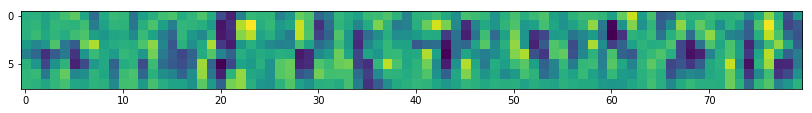

In [62]:

ims2 = []
i = 0
print_every = 5
i_hidden_bias = -1.
_n_epochs=400

def run_mnist():
    from sklearn.datasets import load_digits

    global ims2, i, print_every, i_hidden_bias, _n_epochs
    ims2 = []
    i = 0
    print_every = 10
    i_hidden_bias = -2
    _n_epochs=400
    
    #load data
    X_mnist = load_digits().data
    X_mnist = Variable(torch.Tensor(X_mnist.reshape((-1, 1, 8, 8)) / 16.))

    # hyperparameters
    structure_kernel_size = [3,3]
    optimization_algorithm="sgd"
    learning_rate_rbm=.1
    n_epochs_rbm=-1
    contrastive_divergence_iter=2
    batch_size=128
    verbose=True
    weight_decay=.001

    channels = [(1, 5)]#, (15, 10), (10, 5)]

    dbn3 = UnsupervisedDBN(structure_kernel_size,
                          channels=channels,
                          learning_rate_rbm=learning_rate_rbm,
                          n_epochs_rbm=n_epochs_rbm,
                          contrastive_divergence_iter=contrastive_divergence_iter,
                          batch_size=batch_size,
                          verbose=verbose,
                          weight_decay=weight_decay)

    print("MNIST")

    dbn3.fit(X_mnist)
    dbn3.plot_samples(10, top_down=False)
    return dbn3, ims2


dbn1, im1 = run_mnist()



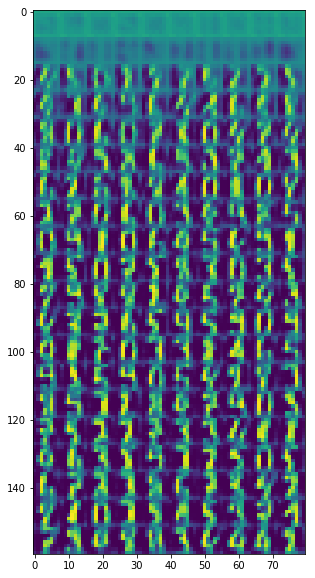

In [74]:
plt.rcParams["figure.figsize"] = (5, 10)
convert_to_image(im1)

**MNIST (1-20) channel convolution**

Faster learning was observed with more channels for the hidden layer

MNIST
3 (1, 20)
[START] Pre-training step:
torch.Size([1797, 1, 8, 8])
(8, 240)


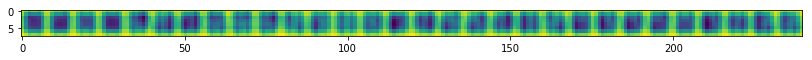

>> Epoch 1 finished 	RBM Reconstruction error 12.379030228
torch.Size([1797, 1, 8, 8])
>> Epoch 2 finished 	RBM Reconstruction error 12.218032837
torch.Size([1797, 1, 8, 8])
>> Epoch 3 finished 	RBM Reconstruction error 12.085276604
torch.Size([1797, 1, 8, 8])
>> Epoch 4 finished 	RBM Reconstruction error 11.968760490
torch.Size([1797, 1, 8, 8])
>> Epoch 5 finished 	RBM Reconstruction error 11.860363960
torch.Size([1797, 1, 8, 8])
>> Epoch 6 finished 	RBM Reconstruction error 11.757726669
torch.Size([1797, 1, 8, 8])
>> Epoch 7 finished 	RBM Reconstruction error 11.654367447
torch.Size([1797, 1, 8, 8])
>> Epoch 8 finished 	RBM Reconstruction error 11.553683281
torch.Size([1797, 1, 8, 8])
>> Epoch 9 finished 	RBM Reconstruction error 11.445249557
torch.Size([1797, 1, 8, 8])
>> Epoch 10 finished 	RBM Reconstruction error 11.321051598
torch.Size([1797, 1, 8, 8])
(8, 240)


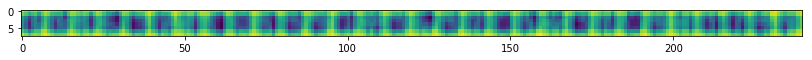

>> Epoch 11 finished 	RBM Reconstruction error 11.183838844
torch.Size([1797, 1, 8, 8])
>> Epoch 12 finished 	RBM Reconstruction error 11.025097847
torch.Size([1797, 1, 8, 8])
>> Epoch 13 finished 	RBM Reconstruction error 10.838240623
torch.Size([1797, 1, 8, 8])
>> Epoch 14 finished 	RBM Reconstruction error 10.611227036
torch.Size([1797, 1, 8, 8])
>> Epoch 15 finished 	RBM Reconstruction error 10.332727432
torch.Size([1797, 1, 8, 8])
>> Epoch 16 finished 	RBM Reconstruction error 9.991754532
torch.Size([1797, 1, 8, 8])
>> Epoch 17 finished 	RBM Reconstruction error 9.573550224
torch.Size([1797, 1, 8, 8])
>> Epoch 18 finished 	RBM Reconstruction error 9.063734055
torch.Size([1797, 1, 8, 8])
>> Epoch 19 finished 	RBM Reconstruction error 8.461585999
torch.Size([1797, 1, 8, 8])
>> Epoch 20 finished 	RBM Reconstruction error 7.771830559
torch.Size([1797, 1, 8, 8])
(8, 240)


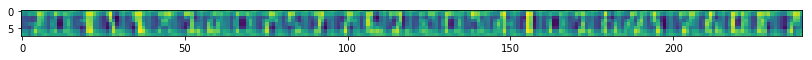

>> Epoch 21 finished 	RBM Reconstruction error 7.047995567
torch.Size([1797, 1, 8, 8])
>> Epoch 22 finished 	RBM Reconstruction error 6.337989807
torch.Size([1797, 1, 8, 8])
>> Epoch 23 finished 	RBM Reconstruction error 5.666550159
torch.Size([1797, 1, 8, 8])
>> Epoch 24 finished 	RBM Reconstruction error 5.075766563
torch.Size([1797, 1, 8, 8])
>> Epoch 25 finished 	RBM Reconstruction error 4.568751335
torch.Size([1797, 1, 8, 8])
>> Epoch 26 finished 	RBM Reconstruction error 4.176848412
torch.Size([1797, 1, 8, 8])
>> Epoch 27 finished 	RBM Reconstruction error 3.880076647
torch.Size([1797, 1, 8, 8])
>> Epoch 28 finished 	RBM Reconstruction error 3.649838924
torch.Size([1797, 1, 8, 8])
>> Epoch 29 finished 	RBM Reconstruction error 3.483455181
torch.Size([1797, 1, 8, 8])
>> Epoch 30 finished 	RBM Reconstruction error 3.341428757
torch.Size([1797, 1, 8, 8])
(8, 240)


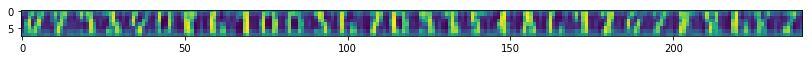

>> Epoch 31 finished 	RBM Reconstruction error 3.233055592
torch.Size([1797, 1, 8, 8])
>> Epoch 32 finished 	RBM Reconstruction error 3.135875225
torch.Size([1797, 1, 8, 8])
>> Epoch 33 finished 	RBM Reconstruction error 3.066413879
torch.Size([1797, 1, 8, 8])
>> Epoch 34 finished 	RBM Reconstruction error 2.998742104
torch.Size([1797, 1, 8, 8])
>> Epoch 35 finished 	RBM Reconstruction error 2.939419031
torch.Size([1797, 1, 8, 8])
>> Epoch 36 finished 	RBM Reconstruction error 2.879305363
torch.Size([1797, 1, 8, 8])
>> Epoch 37 finished 	RBM Reconstruction error 2.826977968
torch.Size([1797, 1, 8, 8])
>> Epoch 38 finished 	RBM Reconstruction error 2.782463789
torch.Size([1797, 1, 8, 8])
>> Epoch 39 finished 	RBM Reconstruction error 2.742451429
torch.Size([1797, 1, 8, 8])
>> Epoch 40 finished 	RBM Reconstruction error 2.692740917
torch.Size([1797, 1, 8, 8])
(8, 240)


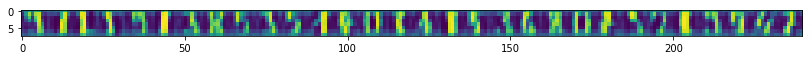

>> Epoch 41 finished 	RBM Reconstruction error 2.662375212
torch.Size([1797, 1, 8, 8])
>> Epoch 42 finished 	RBM Reconstruction error 2.623386621
torch.Size([1797, 1, 8, 8])
>> Epoch 43 finished 	RBM Reconstruction error 2.588755369
torch.Size([1797, 1, 8, 8])
>> Epoch 44 finished 	RBM Reconstruction error 2.553798676
torch.Size([1797, 1, 8, 8])
>> Epoch 45 finished 	RBM Reconstruction error 2.518981218
torch.Size([1797, 1, 8, 8])
>> Epoch 46 finished 	RBM Reconstruction error 2.496712685
torch.Size([1797, 1, 8, 8])
>> Epoch 47 finished 	RBM Reconstruction error 2.465274572
torch.Size([1797, 1, 8, 8])
>> Epoch 48 finished 	RBM Reconstruction error 2.437527657
torch.Size([1797, 1, 8, 8])
>> Epoch 49 finished 	RBM Reconstruction error 2.406989813
torch.Size([1797, 1, 8, 8])
>> Epoch 50 finished 	RBM Reconstruction error 2.393522739
torch.Size([1797, 1, 8, 8])
(8, 240)


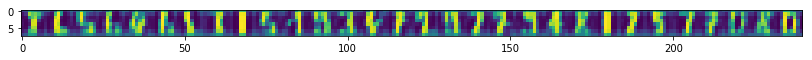

>> Epoch 51 finished 	RBM Reconstruction error 2.353342533
torch.Size([1797, 1, 8, 8])
>> Epoch 52 finished 	RBM Reconstruction error 2.342329025
torch.Size([1797, 1, 8, 8])
>> Epoch 53 finished 	RBM Reconstruction error 2.306740761
torch.Size([1797, 1, 8, 8])
>> Epoch 54 finished 	RBM Reconstruction error 2.287107706
torch.Size([1797, 1, 8, 8])
>> Epoch 55 finished 	RBM Reconstruction error 2.272765875
torch.Size([1797, 1, 8, 8])
>> Epoch 56 finished 	RBM Reconstruction error 2.245542288
torch.Size([1797, 1, 8, 8])
>> Epoch 57 finished 	RBM Reconstruction error 2.231027126
torch.Size([1797, 1, 8, 8])
>> Epoch 58 finished 	RBM Reconstruction error 2.203184843
torch.Size([1797, 1, 8, 8])
>> Epoch 59 finished 	RBM Reconstruction error 2.197173119
torch.Size([1797, 1, 8, 8])
>> Epoch 60 finished 	RBM Reconstruction error 2.172246933
torch.Size([1797, 1, 8, 8])
(8, 240)


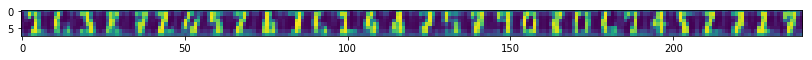

>> Epoch 61 finished 	RBM Reconstruction error 2.154892921
torch.Size([1797, 1, 8, 8])
>> Epoch 62 finished 	RBM Reconstruction error 2.128560305
torch.Size([1797, 1, 8, 8])
>> Epoch 63 finished 	RBM Reconstruction error 2.127291441
torch.Size([1797, 1, 8, 8])
>> Epoch 64 finished 	RBM Reconstruction error 2.092594862
torch.Size([1797, 1, 8, 8])
>> Epoch 65 finished 	RBM Reconstruction error 2.089180470
torch.Size([1797, 1, 8, 8])
>> Epoch 66 finished 	RBM Reconstruction error 2.060991764
torch.Size([1797, 1, 8, 8])
>> Epoch 67 finished 	RBM Reconstruction error 2.053794622
torch.Size([1797, 1, 8, 8])
>> Epoch 68 finished 	RBM Reconstruction error 2.029439688
torch.Size([1797, 1, 8, 8])
>> Epoch 69 finished 	RBM Reconstruction error 2.026084185
torch.Size([1797, 1, 8, 8])
>> Epoch 70 finished 	RBM Reconstruction error 1.993867755
torch.Size([1797, 1, 8, 8])
(8, 240)


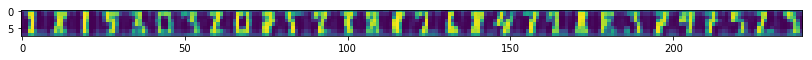

>> Epoch 71 finished 	RBM Reconstruction error 1.994204402
torch.Size([1797, 1, 8, 8])
>> Epoch 72 finished 	RBM Reconstruction error 1.961774230
torch.Size([1797, 1, 8, 8])
>> Epoch 73 finished 	RBM Reconstruction error 1.960093617
torch.Size([1797, 1, 8, 8])
>> Epoch 74 finished 	RBM Reconstruction error 1.937550187
torch.Size([1797, 1, 8, 8])
>> Epoch 75 finished 	RBM Reconstruction error 1.924391270
torch.Size([1797, 1, 8, 8])
>> Epoch 76 finished 	RBM Reconstruction error 1.907038808
torch.Size([1797, 1, 8, 8])
>> Epoch 77 finished 	RBM Reconstruction error 1.889780641
torch.Size([1797, 1, 8, 8])
>> Epoch 78 finished 	RBM Reconstruction error 1.882566214
torch.Size([1797, 1, 8, 8])
>> Epoch 79 finished 	RBM Reconstruction error 1.856696129
torch.Size([1797, 1, 8, 8])
>> Epoch 80 finished 	RBM Reconstruction error 1.854724884
torch.Size([1797, 1, 8, 8])
(8, 240)


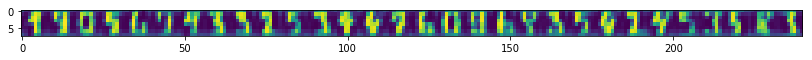

>> Epoch 81 finished 	RBM Reconstruction error 1.822712779
torch.Size([1797, 1, 8, 8])
>> Epoch 82 finished 	RBM Reconstruction error 1.832024217
torch.Size([1797, 1, 8, 8])
>> Epoch 83 finished 	RBM Reconstruction error 1.787140369
torch.Size([1797, 1, 8, 8])
>> Epoch 84 finished 	RBM Reconstruction error 1.816077352
torch.Size([1797, 1, 8, 8])
>> Epoch 85 finished 	RBM Reconstruction error 1.754491091
torch.Size([1797, 1, 8, 8])
>> Epoch 86 finished 	RBM Reconstruction error 1.774709821
torch.Size([1797, 1, 8, 8])
>> Epoch 87 finished 	RBM Reconstruction error 1.721478820
torch.Size([1797, 1, 8, 8])
>> Epoch 88 finished 	RBM Reconstruction error 1.735422254
torch.Size([1797, 1, 8, 8])
>> Epoch 89 finished 	RBM Reconstruction error 1.689406753
torch.Size([1797, 1, 8, 8])
>> Epoch 90 finished 	RBM Reconstruction error 1.702808619
torch.Size([1797, 1, 8, 8])
(8, 240)


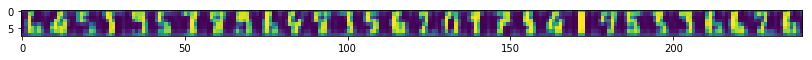

>> Epoch 91 finished 	RBM Reconstruction error 1.654166698
torch.Size([1797, 1, 8, 8])
>> Epoch 92 finished 	RBM Reconstruction error 1.683346152
torch.Size([1797, 1, 8, 8])
>> Epoch 93 finished 	RBM Reconstruction error 1.620218158
torch.Size([1797, 1, 8, 8])
>> Epoch 94 finished 	RBM Reconstruction error 1.661846519
torch.Size([1797, 1, 8, 8])
>> Epoch 95 finished 	RBM Reconstruction error 1.584104657
torch.Size([1797, 1, 8, 8])
>> Epoch 96 finished 	RBM Reconstruction error 1.617510319
torch.Size([1797, 1, 8, 8])
>> Epoch 97 finished 	RBM Reconstruction error 1.548858285
torch.Size([1797, 1, 8, 8])
>> Epoch 98 finished 	RBM Reconstruction error 1.574378371
torch.Size([1797, 1, 8, 8])
>> Epoch 99 finished 	RBM Reconstruction error 1.514006972
torch.Size([1797, 1, 8, 8])
>> Epoch 100 finished 	RBM Reconstruction error 1.530501962
torch.Size([1797, 1, 8, 8])
(8, 240)


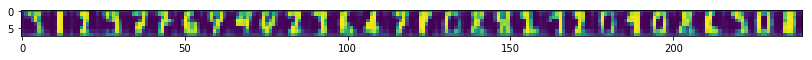

>> Epoch 101 finished 	RBM Reconstruction error 1.481756806
torch.Size([1797, 1, 8, 8])
>> Epoch 102 finished 	RBM Reconstruction error 1.492633700
torch.Size([1797, 1, 8, 8])
>> Epoch 103 finished 	RBM Reconstruction error 1.447887897
torch.Size([1797, 1, 8, 8])
>> Epoch 104 finished 	RBM Reconstruction error 1.452238321
torch.Size([1797, 1, 8, 8])
>> Epoch 105 finished 	RBM Reconstruction error 1.414426208
torch.Size([1797, 1, 8, 8])
>> Epoch 106 finished 	RBM Reconstruction error 1.417510748
torch.Size([1797, 1, 8, 8])
>> Epoch 107 finished 	RBM Reconstruction error 1.383816481
torch.Size([1797, 1, 8, 8])
>> Epoch 108 finished 	RBM Reconstruction error 1.380351186
torch.Size([1797, 1, 8, 8])
>> Epoch 109 finished 	RBM Reconstruction error 1.360066414
torch.Size([1797, 1, 8, 8])
>> Epoch 110 finished 	RBM Reconstruction error 1.347684979
torch.Size([1797, 1, 8, 8])
(8, 240)


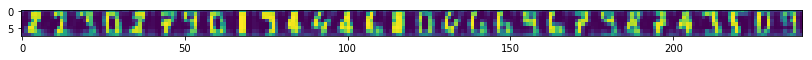

>> Epoch 111 finished 	RBM Reconstruction error 1.329456329
torch.Size([1797, 1, 8, 8])
>> Epoch 112 finished 	RBM Reconstruction error 1.322575808
torch.Size([1797, 1, 8, 8])
>> Epoch 113 finished 	RBM Reconstruction error 1.303001165
torch.Size([1797, 1, 8, 8])
>> Epoch 114 finished 	RBM Reconstruction error 1.300036073
torch.Size([1797, 1, 8, 8])
>> Epoch 115 finished 	RBM Reconstruction error 1.279608727
torch.Size([1797, 1, 8, 8])
>> Epoch 116 finished 	RBM Reconstruction error 1.270502925
torch.Size([1797, 1, 8, 8])
>> Epoch 117 finished 	RBM Reconstruction error 1.252266645
torch.Size([1797, 1, 8, 8])
>> Epoch 118 finished 	RBM Reconstruction error 1.260036111
torch.Size([1797, 1, 8, 8])
>> Epoch 119 finished 	RBM Reconstruction error 1.228601933
torch.Size([1797, 1, 8, 8])
>> Epoch 120 finished 	RBM Reconstruction error 1.238898754
torch.Size([1797, 1, 8, 8])
(8, 240)


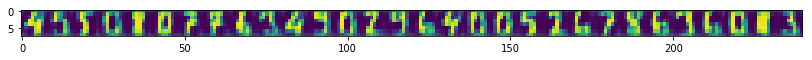

>> Epoch 121 finished 	RBM Reconstruction error 1.207326174
torch.Size([1797, 1, 8, 8])
>> Epoch 122 finished 	RBM Reconstruction error 1.222550035
torch.Size([1797, 1, 8, 8])
>> Epoch 123 finished 	RBM Reconstruction error 1.185261130
torch.Size([1797, 1, 8, 8])
>> Epoch 124 finished 	RBM Reconstruction error 1.200170279
torch.Size([1797, 1, 8, 8])
>> Epoch 125 finished 	RBM Reconstruction error 1.167115927
torch.Size([1797, 1, 8, 8])
>> Epoch 126 finished 	RBM Reconstruction error 1.178197980
torch.Size([1797, 1, 8, 8])
>> Epoch 127 finished 	RBM Reconstruction error 1.151020527
torch.Size([1797, 1, 8, 8])
>> Epoch 128 finished 	RBM Reconstruction error 1.166854739
torch.Size([1797, 1, 8, 8])
>> Epoch 129 finished 	RBM Reconstruction error 1.132854819
torch.Size([1797, 1, 8, 8])
>> Epoch 130 finished 	RBM Reconstruction error 1.159151435
torch.Size([1797, 1, 8, 8])
(8, 240)


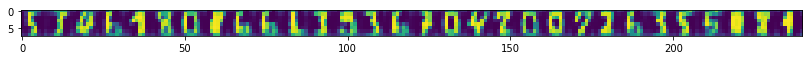

>> Epoch 131 finished 	RBM Reconstruction error 1.119951844
torch.Size([1797, 1, 8, 8])
>> Epoch 132 finished 	RBM Reconstruction error 1.136966467
torch.Size([1797, 1, 8, 8])
>> Epoch 133 finished 	RBM Reconstruction error 1.106358647
torch.Size([1797, 1, 8, 8])
>> Epoch 134 finished 	RBM Reconstruction error 1.119040370
torch.Size([1797, 1, 8, 8])
>> Epoch 135 finished 	RBM Reconstruction error 1.091893911
torch.Size([1797, 1, 8, 8])
>> Epoch 136 finished 	RBM Reconstruction error 1.107525349
torch.Size([1797, 1, 8, 8])
>> Epoch 137 finished 	RBM Reconstruction error 1.081564188
torch.Size([1797, 1, 8, 8])
>> Epoch 138 finished 	RBM Reconstruction error 1.088071108
torch.Size([1797, 1, 8, 8])
>> Epoch 139 finished 	RBM Reconstruction error 1.073695064
torch.Size([1797, 1, 8, 8])
>> Epoch 140 finished 	RBM Reconstruction error 1.072221398
torch.Size([1797, 1, 8, 8])
(8, 240)


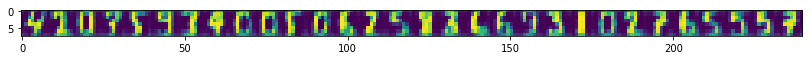

>> Epoch 141 finished 	RBM Reconstruction error 1.059664011
torch.Size([1797, 1, 8, 8])
>> Epoch 142 finished 	RBM Reconstruction error 1.063944817
torch.Size([1797, 1, 8, 8])
>> Epoch 143 finished 	RBM Reconstruction error 1.049274206
torch.Size([1797, 1, 8, 8])
>> Epoch 144 finished 	RBM Reconstruction error 1.059633851
torch.Size([1797, 1, 8, 8])
>> Epoch 145 finished 	RBM Reconstruction error 1.034614205
torch.Size([1797, 1, 8, 8])
>> Epoch 146 finished 	RBM Reconstruction error 1.048025727
torch.Size([1797, 1, 8, 8])
>> Epoch 147 finished 	RBM Reconstruction error 1.026750922
torch.Size([1797, 1, 8, 8])
>> Epoch 148 finished 	RBM Reconstruction error 1.043489099
torch.Size([1797, 1, 8, 8])
>> Epoch 149 finished 	RBM Reconstruction error 1.016696453
torch.Size([1797, 1, 8, 8])
>> Epoch 150 finished 	RBM Reconstruction error 1.033411145
torch.Size([1797, 1, 8, 8])
(8, 240)


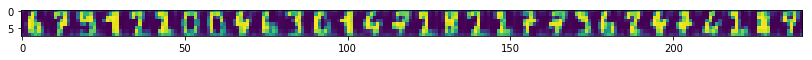

>> Epoch 151 finished 	RBM Reconstruction error 1.007393122
torch.Size([1797, 1, 8, 8])
>> Epoch 152 finished 	RBM Reconstruction error 1.020471334
torch.Size([1797, 1, 8, 8])
>> Epoch 153 finished 	RBM Reconstruction error 0.997605205
torch.Size([1797, 1, 8, 8])
>> Epoch 154 finished 	RBM Reconstruction error 1.023614883
torch.Size([1797, 1, 8, 8])
>> Epoch 155 finished 	RBM Reconstruction error 0.990043938
torch.Size([1797, 1, 8, 8])
>> Epoch 156 finished 	RBM Reconstruction error 1.028770566
torch.Size([1797, 1, 8, 8])
>> Epoch 157 finished 	RBM Reconstruction error 0.982881844
torch.Size([1797, 1, 8, 8])
>> Epoch 158 finished 	RBM Reconstruction error 1.023441315
torch.Size([1797, 1, 8, 8])
>> Epoch 159 finished 	RBM Reconstruction error 0.972828925
torch.Size([1797, 1, 8, 8])
>> Epoch 160 finished 	RBM Reconstruction error 1.024777055
torch.Size([1797, 1, 8, 8])
(8, 240)


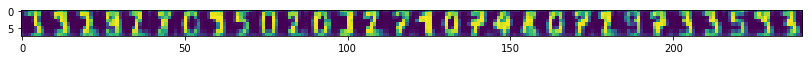

>> Epoch 161 finished 	RBM Reconstruction error 0.965729415
torch.Size([1797, 1, 8, 8])
>> Epoch 162 finished 	RBM Reconstruction error 1.016764879
torch.Size([1797, 1, 8, 8])
>> Epoch 163 finished 	RBM Reconstruction error 0.960704982
torch.Size([1797, 1, 8, 8])
>> Epoch 164 finished 	RBM Reconstruction error 1.022982717
torch.Size([1797, 1, 8, 8])
>> Epoch 165 finished 	RBM Reconstruction error 0.955500662
torch.Size([1797, 1, 8, 8])
>> Epoch 166 finished 	RBM Reconstruction error 1.027747154
torch.Size([1797, 1, 8, 8])
>> Epoch 167 finished 	RBM Reconstruction error 0.944885314
torch.Size([1797, 1, 8, 8])
>> Epoch 168 finished 	RBM Reconstruction error 1.011879444
torch.Size([1797, 1, 8, 8])
>> Epoch 169 finished 	RBM Reconstruction error 0.935270965
torch.Size([1797, 1, 8, 8])
>> Epoch 170 finished 	RBM Reconstruction error 0.997346163
torch.Size([1797, 1, 8, 8])
(8, 240)


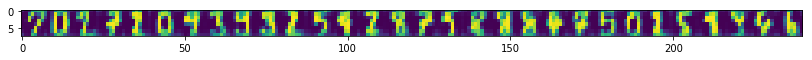

>> Epoch 171 finished 	RBM Reconstruction error 0.934808493
torch.Size([1797, 1, 8, 8])
>> Epoch 172 finished 	RBM Reconstruction error 1.001541495
torch.Size([1797, 1, 8, 8])
>> Epoch 173 finished 	RBM Reconstruction error 0.927551389
torch.Size([1797, 1, 8, 8])
>> Epoch 174 finished 	RBM Reconstruction error 0.989484131
torch.Size([1797, 1, 8, 8])
>> Epoch 175 finished 	RBM Reconstruction error 0.917350769
torch.Size([1797, 1, 8, 8])
>> Epoch 176 finished 	RBM Reconstruction error 0.969400704
torch.Size([1797, 1, 8, 8])
>> Epoch 177 finished 	RBM Reconstruction error 0.911378384
torch.Size([1797, 1, 8, 8])
>> Epoch 178 finished 	RBM Reconstruction error 0.955261767
torch.Size([1797, 1, 8, 8])
>> Epoch 179 finished 	RBM Reconstruction error 0.907854795
torch.Size([1797, 1, 8, 8])
>> Epoch 180 finished 	RBM Reconstruction error 0.971231937
torch.Size([1797, 1, 8, 8])
(8, 240)


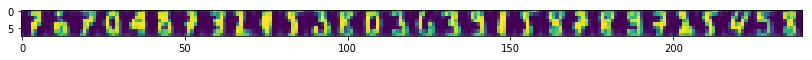

>> Epoch 181 finished 	RBM Reconstruction error 0.903040111
torch.Size([1797, 1, 8, 8])
>> Epoch 182 finished 	RBM Reconstruction error 0.959645748
torch.Size([1797, 1, 8, 8])
>> Epoch 183 finished 	RBM Reconstruction error 0.899962783
torch.Size([1797, 1, 8, 8])
>> Epoch 184 finished 	RBM Reconstruction error 0.956719995
torch.Size([1797, 1, 8, 8])
>> Epoch 185 finished 	RBM Reconstruction error 0.898634434
torch.Size([1797, 1, 8, 8])
>> Epoch 186 finished 	RBM Reconstruction error 0.979492605
torch.Size([1797, 1, 8, 8])
>> Epoch 187 finished 	RBM Reconstruction error 0.894735515
torch.Size([1797, 1, 8, 8])
>> Epoch 188 finished 	RBM Reconstruction error 0.972097576
torch.Size([1797, 1, 8, 8])
>> Epoch 189 finished 	RBM Reconstruction error 0.887943387
torch.Size([1797, 1, 8, 8])
>> Epoch 190 finished 	RBM Reconstruction error 0.950330555
torch.Size([1797, 1, 8, 8])
(8, 240)


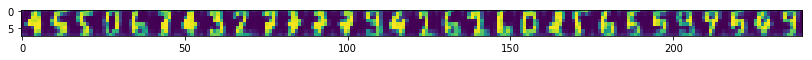

>> Epoch 191 finished 	RBM Reconstruction error 0.880905151
torch.Size([1797, 1, 8, 8])
>> Epoch 192 finished 	RBM Reconstruction error 0.938628733
torch.Size([1797, 1, 8, 8])
>> Epoch 193 finished 	RBM Reconstruction error 0.874601662
torch.Size([1797, 1, 8, 8])
>> Epoch 194 finished 	RBM Reconstruction error 0.944174647
torch.Size([1797, 1, 8, 8])
>> Epoch 195 finished 	RBM Reconstruction error 0.874260128
torch.Size([1797, 1, 8, 8])
>> Epoch 196 finished 	RBM Reconstruction error 0.943834066
torch.Size([1797, 1, 8, 8])
>> Epoch 197 finished 	RBM Reconstruction error 0.867025018
torch.Size([1797, 1, 8, 8])
>> Epoch 198 finished 	RBM Reconstruction error 0.936816752
torch.Size([1797, 1, 8, 8])
>> Epoch 199 finished 	RBM Reconstruction error 0.864606857
torch.Size([1797, 1, 8, 8])
>> Epoch 200 finished 	RBM Reconstruction error 0.935817838
torch.Size([1797, 1, 8, 8])
(8, 240)


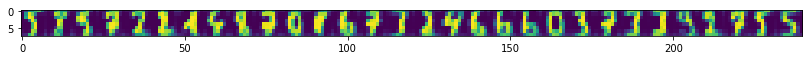

>> Epoch 201 finished 	RBM Reconstruction error 0.858310163
torch.Size([1797, 1, 8, 8])
>> Epoch 202 finished 	RBM Reconstruction error 0.929852843
torch.Size([1797, 1, 8, 8])
>> Epoch 203 finished 	RBM Reconstruction error 0.864458621
torch.Size([1797, 1, 8, 8])
>> Epoch 204 finished 	RBM Reconstruction error 0.968381643
torch.Size([1797, 1, 8, 8])
>> Epoch 205 finished 	RBM Reconstruction error 0.855695307
torch.Size([1797, 1, 8, 8])
>> Epoch 206 finished 	RBM Reconstruction error 0.945161939
torch.Size([1797, 1, 8, 8])
>> Epoch 207 finished 	RBM Reconstruction error 0.850512803
torch.Size([1797, 1, 8, 8])
>> Epoch 208 finished 	RBM Reconstruction error 0.952771604
torch.Size([1797, 1, 8, 8])
>> Epoch 209 finished 	RBM Reconstruction error 0.848123133
torch.Size([1797, 1, 8, 8])
>> Epoch 210 finished 	RBM Reconstruction error 0.940051496
torch.Size([1797, 1, 8, 8])
(8, 240)


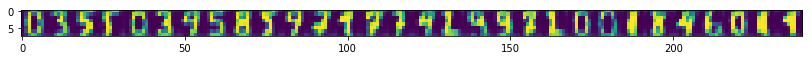

>> Epoch 211 finished 	RBM Reconstruction error 0.848218143
torch.Size([1797, 1, 8, 8])
>> Epoch 212 finished 	RBM Reconstruction error 0.930527687
torch.Size([1797, 1, 8, 8])
>> Epoch 213 finished 	RBM Reconstruction error 0.840098023
torch.Size([1797, 1, 8, 8])
>> Epoch 214 finished 	RBM Reconstruction error 0.925597370
torch.Size([1797, 1, 8, 8])
>> Epoch 215 finished 	RBM Reconstruction error 0.840000212
torch.Size([1797, 1, 8, 8])
>> Epoch 216 finished 	RBM Reconstruction error 0.926658928
torch.Size([1797, 1, 8, 8])
>> Epoch 217 finished 	RBM Reconstruction error 0.839286685
torch.Size([1797, 1, 8, 8])
>> Epoch 218 finished 	RBM Reconstruction error 0.933349252
torch.Size([1797, 1, 8, 8])
>> Epoch 219 finished 	RBM Reconstruction error 0.836531878
torch.Size([1797, 1, 8, 8])
>> Epoch 220 finished 	RBM Reconstruction error 0.945897698
torch.Size([1797, 1, 8, 8])
(8, 240)


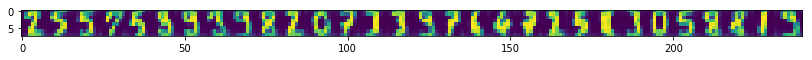

>> Epoch 221 finished 	RBM Reconstruction error 0.833122373
torch.Size([1797, 1, 8, 8])
>> Epoch 222 finished 	RBM Reconstruction error 0.918636858
torch.Size([1797, 1, 8, 8])
>> Epoch 223 finished 	RBM Reconstruction error 0.827580035
torch.Size([1797, 1, 8, 8])
>> Epoch 224 finished 	RBM Reconstruction error 0.919631481
torch.Size([1797, 1, 8, 8])
>> Epoch 225 finished 	RBM Reconstruction error 0.828568697
torch.Size([1797, 1, 8, 8])
>> Epoch 226 finished 	RBM Reconstruction error 0.920683503
torch.Size([1797, 1, 8, 8])
>> Epoch 227 finished 	RBM Reconstruction error 0.820263982
torch.Size([1797, 1, 8, 8])
>> Epoch 228 finished 	RBM Reconstruction error 0.901789546
torch.Size([1797, 1, 8, 8])
>> Epoch 229 finished 	RBM Reconstruction error 0.820436954
torch.Size([1797, 1, 8, 8])
>> Epoch 230 finished 	RBM Reconstruction error 0.895861745
torch.Size([1797, 1, 8, 8])
(8, 240)


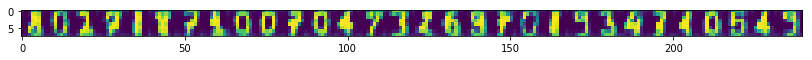

>> Epoch 231 finished 	RBM Reconstruction error 0.820339859
torch.Size([1797, 1, 8, 8])
>> Epoch 232 finished 	RBM Reconstruction error 0.905589223
torch.Size([1797, 1, 8, 8])
>> Epoch 233 finished 	RBM Reconstruction error 0.815042257
torch.Size([1797, 1, 8, 8])
>> Epoch 234 finished 	RBM Reconstruction error 0.900980234
torch.Size([1797, 1, 8, 8])
>> Epoch 235 finished 	RBM Reconstruction error 0.817840099
torch.Size([1797, 1, 8, 8])
>> Epoch 236 finished 	RBM Reconstruction error 0.918100655
torch.Size([1797, 1, 8, 8])
>> Epoch 237 finished 	RBM Reconstruction error 0.816758752
torch.Size([1797, 1, 8, 8])
>> Epoch 238 finished 	RBM Reconstruction error 0.928141177
torch.Size([1797, 1, 8, 8])
>> Epoch 239 finished 	RBM Reconstruction error 0.815767407
torch.Size([1797, 1, 8, 8])
>> Epoch 240 finished 	RBM Reconstruction error 0.923112392
torch.Size([1797, 1, 8, 8])
(8, 240)


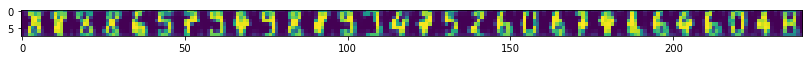

>> Epoch 241 finished 	RBM Reconstruction error 0.809869945
torch.Size([1797, 1, 8, 8])
>> Epoch 242 finished 	RBM Reconstruction error 0.895531833
torch.Size([1797, 1, 8, 8])
>> Epoch 243 finished 	RBM Reconstruction error 0.797969937
torch.Size([1797, 1, 8, 8])
>> Epoch 244 finished 	RBM Reconstruction error 0.866742253
torch.Size([1797, 1, 8, 8])
>> Epoch 245 finished 	RBM Reconstruction error 0.801188111
torch.Size([1797, 1, 8, 8])
>> Epoch 246 finished 	RBM Reconstruction error 0.872498870
torch.Size([1797, 1, 8, 8])
>> Epoch 247 finished 	RBM Reconstruction error 0.800196350
torch.Size([1797, 1, 8, 8])
>> Epoch 248 finished 	RBM Reconstruction error 0.900314867
torch.Size([1797, 1, 8, 8])
>> Epoch 249 finished 	RBM Reconstruction error 0.805334568
torch.Size([1797, 1, 8, 8])
>> Epoch 250 finished 	RBM Reconstruction error 0.895654678
torch.Size([1797, 1, 8, 8])
(8, 240)


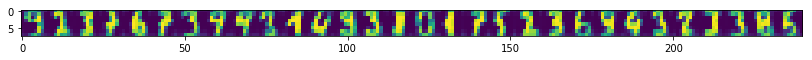

>> Epoch 251 finished 	RBM Reconstruction error 0.804751992
torch.Size([1797, 1, 8, 8])
>> Epoch 252 finished 	RBM Reconstruction error 0.907910883
torch.Size([1797, 1, 8, 8])
>> Epoch 253 finished 	RBM Reconstruction error 0.803359330
torch.Size([1797, 1, 8, 8])
>> Epoch 254 finished 	RBM Reconstruction error 0.899050236
torch.Size([1797, 1, 8, 8])
>> Epoch 255 finished 	RBM Reconstruction error 0.798785686
torch.Size([1797, 1, 8, 8])
>> Epoch 256 finished 	RBM Reconstruction error 0.885157228
torch.Size([1797, 1, 8, 8])
>> Epoch 257 finished 	RBM Reconstruction error 0.798425555
torch.Size([1797, 1, 8, 8])
>> Epoch 258 finished 	RBM Reconstruction error 0.895270109
torch.Size([1797, 1, 8, 8])
>> Epoch 259 finished 	RBM Reconstruction error 0.800428092
torch.Size([1797, 1, 8, 8])
>> Epoch 260 finished 	RBM Reconstruction error 0.935464025
torch.Size([1797, 1, 8, 8])
(8, 240)


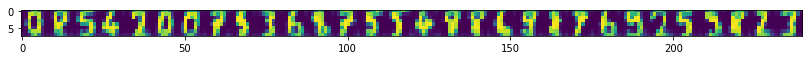

>> Epoch 261 finished 	RBM Reconstruction error 0.806417346
torch.Size([1797, 1, 8, 8])
>> Epoch 262 finished 	RBM Reconstruction error 0.942759216
torch.Size([1797, 1, 8, 8])
>> Epoch 263 finished 	RBM Reconstruction error 0.795666814
torch.Size([1797, 1, 8, 8])
>> Epoch 264 finished 	RBM Reconstruction error 0.887800753
torch.Size([1797, 1, 8, 8])
>> Epoch 265 finished 	RBM Reconstruction error 0.789253116
torch.Size([1797, 1, 8, 8])
>> Epoch 266 finished 	RBM Reconstruction error 0.909714758
torch.Size([1797, 1, 8, 8])
>> Epoch 267 finished 	RBM Reconstruction error 0.800168514
torch.Size([1797, 1, 8, 8])
>> Epoch 268 finished 	RBM Reconstruction error 0.906621039
torch.Size([1797, 1, 8, 8])
>> Epoch 269 finished 	RBM Reconstruction error 0.786463380
torch.Size([1797, 1, 8, 8])
>> Epoch 270 finished 	RBM Reconstruction error 0.892163336
torch.Size([1797, 1, 8, 8])
(8, 240)


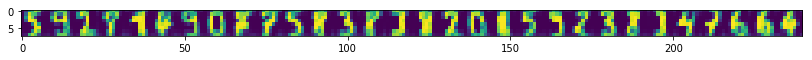

>> Epoch 271 finished 	RBM Reconstruction error 0.787008762
torch.Size([1797, 1, 8, 8])
>> Epoch 272 finished 	RBM Reconstruction error 0.894160330
torch.Size([1797, 1, 8, 8])
>> Epoch 273 finished 	RBM Reconstruction error 0.794636548
torch.Size([1797, 1, 8, 8])
>> Epoch 274 finished 	RBM Reconstruction error 0.911145508
torch.Size([1797, 1, 8, 8])
>> Epoch 275 finished 	RBM Reconstruction error 0.798686922
torch.Size([1797, 1, 8, 8])
>> Epoch 276 finished 	RBM Reconstruction error 0.919140637
torch.Size([1797, 1, 8, 8])
>> Epoch 277 finished 	RBM Reconstruction error 0.791317701
torch.Size([1797, 1, 8, 8])
>> Epoch 278 finished 	RBM Reconstruction error 0.921191454
torch.Size([1797, 1, 8, 8])
>> Epoch 279 finished 	RBM Reconstruction error 0.792353213
torch.Size([1797, 1, 8, 8])
>> Epoch 280 finished 	RBM Reconstruction error 0.940506160
torch.Size([1797, 1, 8, 8])
(8, 240)


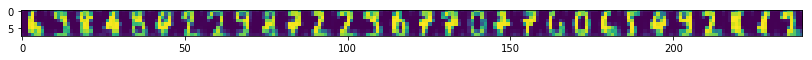

>> Epoch 281 finished 	RBM Reconstruction error 0.787710249
torch.Size([1797, 1, 8, 8])
>> Epoch 282 finished 	RBM Reconstruction error 0.911473691
torch.Size([1797, 1, 8, 8])
>> Epoch 283 finished 	RBM Reconstruction error 0.782996595
torch.Size([1797, 1, 8, 8])
>> Epoch 284 finished 	RBM Reconstruction error 0.873480260
torch.Size([1797, 1, 8, 8])
>> Epoch 285 finished 	RBM Reconstruction error 0.778797090
torch.Size([1797, 1, 8, 8])
>> Epoch 286 finished 	RBM Reconstruction error 0.877710760
torch.Size([1797, 1, 8, 8])
>> Epoch 287 finished 	RBM Reconstruction error 0.780263186
torch.Size([1797, 1, 8, 8])
>> Epoch 288 finished 	RBM Reconstruction error 0.865652323
torch.Size([1797, 1, 8, 8])
>> Epoch 289 finished 	RBM Reconstruction error 0.774557710
torch.Size([1797, 1, 8, 8])
>> Epoch 290 finished 	RBM Reconstruction error 0.849266469
torch.Size([1797, 1, 8, 8])
(8, 240)


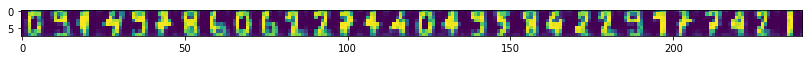

>> Epoch 291 finished 	RBM Reconstruction error 0.773918867
torch.Size([1797, 1, 8, 8])
>> Epoch 292 finished 	RBM Reconstruction error 0.897453547
torch.Size([1797, 1, 8, 8])
>> Epoch 293 finished 	RBM Reconstruction error 0.790135682
torch.Size([1797, 1, 8, 8])
>> Epoch 294 finished 	RBM Reconstruction error 0.929445982
torch.Size([1797, 1, 8, 8])
>> Epoch 295 finished 	RBM Reconstruction error 0.780809164
torch.Size([1797, 1, 8, 8])
>> Epoch 296 finished 	RBM Reconstruction error 0.939570189
torch.Size([1797, 1, 8, 8])
>> Epoch 297 finished 	RBM Reconstruction error 0.783881307
torch.Size([1797, 1, 8, 8])
>> Epoch 298 finished 	RBM Reconstruction error 0.909065068
torch.Size([1797, 1, 8, 8])
>> Epoch 299 finished 	RBM Reconstruction error 0.774043620
torch.Size([1797, 1, 8, 8])
>> Epoch 300 finished 	RBM Reconstruction error 0.883894920
torch.Size([1797, 1, 8, 8])
(8, 240)


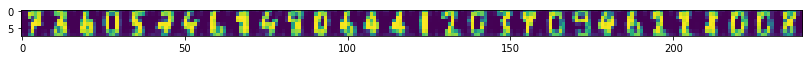

>> Epoch 301 finished 	RBM Reconstruction error 0.775140703
torch.Size([1797, 1, 8, 8])
>> Epoch 302 finished 	RBM Reconstruction error 0.881615341
torch.Size([1797, 1, 8, 8])
>> Epoch 303 finished 	RBM Reconstruction error 0.773626328
torch.Size([1797, 1, 8, 8])
>> Epoch 304 finished 	RBM Reconstruction error 0.868489027
torch.Size([1797, 1, 8, 8])
>> Epoch 305 finished 	RBM Reconstruction error 0.772112608
torch.Size([1797, 1, 8, 8])
>> Epoch 306 finished 	RBM Reconstruction error 0.873619914
torch.Size([1797, 1, 8, 8])
>> Epoch 307 finished 	RBM Reconstruction error 0.768823445
torch.Size([1797, 1, 8, 8])
>> Epoch 308 finished 	RBM Reconstruction error 0.875277877
torch.Size([1797, 1, 8, 8])
>> Epoch 309 finished 	RBM Reconstruction error 0.776556432
torch.Size([1797, 1, 8, 8])
>> Epoch 310 finished 	RBM Reconstruction error 0.923939407
torch.Size([1797, 1, 8, 8])
(8, 240)


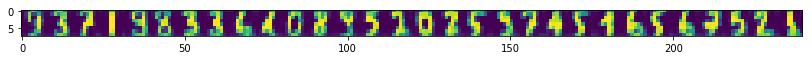

>> Epoch 311 finished 	RBM Reconstruction error 0.781951964
torch.Size([1797, 1, 8, 8])
>> Epoch 312 finished 	RBM Reconstruction error 0.925436199
torch.Size([1797, 1, 8, 8])
>> Epoch 313 finished 	RBM Reconstruction error 0.772365868
torch.Size([1797, 1, 8, 8])
>> Epoch 314 finished 	RBM Reconstruction error 0.892806053
torch.Size([1797, 1, 8, 8])
>> Epoch 315 finished 	RBM Reconstruction error 0.771819770
torch.Size([1797, 1, 8, 8])
>> Epoch 316 finished 	RBM Reconstruction error 0.884822786
torch.Size([1797, 1, 8, 8])
>> Epoch 317 finished 	RBM Reconstruction error 0.773760796
torch.Size([1797, 1, 8, 8])
>> Epoch 318 finished 	RBM Reconstruction error 0.915984094
torch.Size([1797, 1, 8, 8])
>> Epoch 319 finished 	RBM Reconstruction error 0.779480100
torch.Size([1797, 1, 8, 8])
>> Epoch 320 finished 	RBM Reconstruction error 0.913798213
torch.Size([1797, 1, 8, 8])
(8, 240)


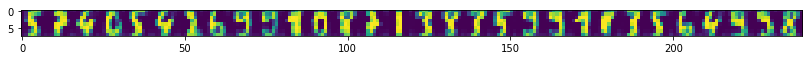

>> Epoch 321 finished 	RBM Reconstruction error 0.781431079
torch.Size([1797, 1, 8, 8])
>> Epoch 322 finished 	RBM Reconstruction error 0.918552279
torch.Size([1797, 1, 8, 8])
>> Epoch 323 finished 	RBM Reconstruction error 0.778826535
torch.Size([1797, 1, 8, 8])
>> Epoch 324 finished 	RBM Reconstruction error 0.947229624
torch.Size([1797, 1, 8, 8])
>> Epoch 325 finished 	RBM Reconstruction error 0.770771980
torch.Size([1797, 1, 8, 8])
>> Epoch 326 finished 	RBM Reconstruction error 0.874882162
torch.Size([1797, 1, 8, 8])
>> Epoch 327 finished 	RBM Reconstruction error 0.767338395
torch.Size([1797, 1, 8, 8])
>> Epoch 328 finished 	RBM Reconstruction error 0.897277653
torch.Size([1797, 1, 8, 8])
>> Epoch 329 finished 	RBM Reconstruction error 0.769476473
torch.Size([1797, 1, 8, 8])
>> Epoch 330 finished 	RBM Reconstruction error 0.914134204
torch.Size([1797, 1, 8, 8])
(8, 240)


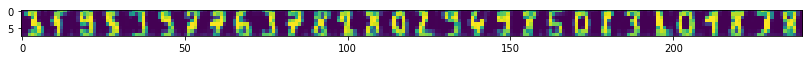

>> Epoch 331 finished 	RBM Reconstruction error 0.770792305
torch.Size([1797, 1, 8, 8])
>> Epoch 332 finished 	RBM Reconstruction error 0.893834472
torch.Size([1797, 1, 8, 8])
>> Epoch 333 finished 	RBM Reconstruction error 0.765841007
torch.Size([1797, 1, 8, 8])
>> Epoch 334 finished 	RBM Reconstruction error 0.888234615
torch.Size([1797, 1, 8, 8])
>> Epoch 335 finished 	RBM Reconstruction error 0.771643817
torch.Size([1797, 1, 8, 8])
>> Epoch 336 finished 	RBM Reconstruction error 0.923756242
torch.Size([1797, 1, 8, 8])
>> Epoch 337 finished 	RBM Reconstruction error 0.764181793
torch.Size([1797, 1, 8, 8])
>> Epoch 338 finished 	RBM Reconstruction error 0.885280907
torch.Size([1797, 1, 8, 8])
>> Epoch 339 finished 	RBM Reconstruction error 0.760080159
torch.Size([1797, 1, 8, 8])
>> Epoch 340 finished 	RBM Reconstruction error 0.863845706
torch.Size([1797, 1, 8, 8])
(8, 240)


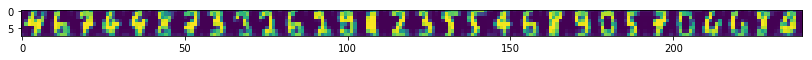

>> Epoch 341 finished 	RBM Reconstruction error 0.759959936
torch.Size([1797, 1, 8, 8])
>> Epoch 342 finished 	RBM Reconstruction error 0.862203360
torch.Size([1797, 1, 8, 8])
>> Epoch 343 finished 	RBM Reconstruction error 0.766658127
torch.Size([1797, 1, 8, 8])
>> Epoch 344 finished 	RBM Reconstruction error 0.901689947
torch.Size([1797, 1, 8, 8])
>> Epoch 345 finished 	RBM Reconstruction error 0.767402649
torch.Size([1797, 1, 8, 8])
>> Epoch 346 finished 	RBM Reconstruction error 0.913713872
torch.Size([1797, 1, 8, 8])
>> Epoch 347 finished 	RBM Reconstruction error 0.767443478
torch.Size([1797, 1, 8, 8])
>> Epoch 348 finished 	RBM Reconstruction error 0.885314226
torch.Size([1797, 1, 8, 8])
>> Epoch 349 finished 	RBM Reconstruction error 0.760523498
torch.Size([1797, 1, 8, 8])
>> Epoch 350 finished 	RBM Reconstruction error 0.862348676
torch.Size([1797, 1, 8, 8])
(8, 240)


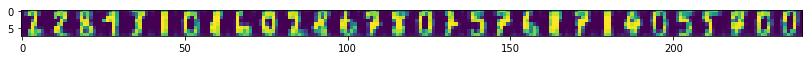

>> Epoch 351 finished 	RBM Reconstruction error 0.757814467
torch.Size([1797, 1, 8, 8])
>> Epoch 352 finished 	RBM Reconstruction error 0.866175413
torch.Size([1797, 1, 8, 8])
>> Epoch 353 finished 	RBM Reconstruction error 0.758454204
torch.Size([1797, 1, 8, 8])
>> Epoch 354 finished 	RBM Reconstruction error 0.894469559
torch.Size([1797, 1, 8, 8])
>> Epoch 355 finished 	RBM Reconstruction error 0.766867518
torch.Size([1797, 1, 8, 8])
>> Epoch 356 finished 	RBM Reconstruction error 0.893677652
torch.Size([1797, 1, 8, 8])
>> Epoch 357 finished 	RBM Reconstruction error 0.766042471
torch.Size([1797, 1, 8, 8])
>> Epoch 358 finished 	RBM Reconstruction error 0.903534710
torch.Size([1797, 1, 8, 8])
>> Epoch 359 finished 	RBM Reconstruction error 0.768051147
torch.Size([1797, 1, 8, 8])
>> Epoch 360 finished 	RBM Reconstruction error 0.918185413
torch.Size([1797, 1, 8, 8])
(8, 240)


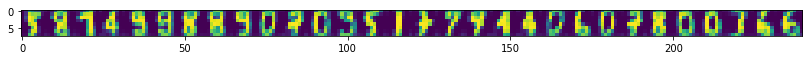

>> Epoch 361 finished 	RBM Reconstruction error 0.758618176
torch.Size([1797, 1, 8, 8])
>> Epoch 362 finished 	RBM Reconstruction error 0.861757994
torch.Size([1797, 1, 8, 8])
>> Epoch 363 finished 	RBM Reconstruction error 0.759255826
torch.Size([1797, 1, 8, 8])
>> Epoch 364 finished 	RBM Reconstruction error 0.880934715
torch.Size([1797, 1, 8, 8])
>> Epoch 365 finished 	RBM Reconstruction error 0.757945180
torch.Size([1797, 1, 8, 8])
>> Epoch 366 finished 	RBM Reconstruction error 0.865948975
torch.Size([1797, 1, 8, 8])
>> Epoch 367 finished 	RBM Reconstruction error 0.764286160
torch.Size([1797, 1, 8, 8])
>> Epoch 368 finished 	RBM Reconstruction error 0.917798400
torch.Size([1797, 1, 8, 8])
>> Epoch 369 finished 	RBM Reconstruction error 0.770102203
torch.Size([1797, 1, 8, 8])
>> Epoch 370 finished 	RBM Reconstruction error 0.898457408
torch.Size([1797, 1, 8, 8])
(8, 240)


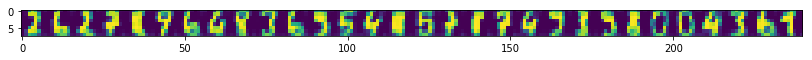

>> Epoch 371 finished 	RBM Reconstruction error 0.768264711
torch.Size([1797, 1, 8, 8])
>> Epoch 372 finished 	RBM Reconstruction error 0.925638497
torch.Size([1797, 1, 8, 8])
>> Epoch 373 finished 	RBM Reconstruction error 0.768528759
torch.Size([1797, 1, 8, 8])
>> Epoch 374 finished 	RBM Reconstruction error 0.930624664
torch.Size([1797, 1, 8, 8])
>> Epoch 375 finished 	RBM Reconstruction error 0.764426887
torch.Size([1797, 1, 8, 8])
>> Epoch 376 finished 	RBM Reconstruction error 0.915473521
torch.Size([1797, 1, 8, 8])
>> Epoch 377 finished 	RBM Reconstruction error 0.754871845
torch.Size([1797, 1, 8, 8])
>> Epoch 378 finished 	RBM Reconstruction error 0.850295305
torch.Size([1797, 1, 8, 8])
>> Epoch 379 finished 	RBM Reconstruction error 0.754470527
torch.Size([1797, 1, 8, 8])
>> Epoch 380 finished 	RBM Reconstruction error 0.891537368
torch.Size([1797, 1, 8, 8])
(8, 240)


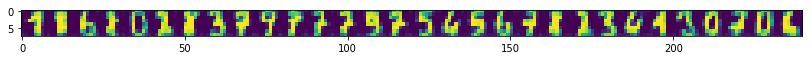

>> Epoch 381 finished 	RBM Reconstruction error 0.759017467
torch.Size([1797, 1, 8, 8])
>> Epoch 382 finished 	RBM Reconstruction error 0.889640093
torch.Size([1797, 1, 8, 8])
>> Epoch 383 finished 	RBM Reconstruction error 0.758122623
torch.Size([1797, 1, 8, 8])
>> Epoch 384 finished 	RBM Reconstruction error 0.899174750
torch.Size([1797, 1, 8, 8])
>> Epoch 385 finished 	RBM Reconstruction error 0.757438958
torch.Size([1797, 1, 8, 8])
>> Epoch 386 finished 	RBM Reconstruction error 0.874499679
torch.Size([1797, 1, 8, 8])
>> Epoch 387 finished 	RBM Reconstruction error 0.757101417
torch.Size([1797, 1, 8, 8])
>> Epoch 388 finished 	RBM Reconstruction error 0.897774160
torch.Size([1797, 1, 8, 8])
>> Epoch 389 finished 	RBM Reconstruction error 0.756700277
torch.Size([1797, 1, 8, 8])
>> Epoch 390 finished 	RBM Reconstruction error 0.882632911
torch.Size([1797, 1, 8, 8])
(8, 240)


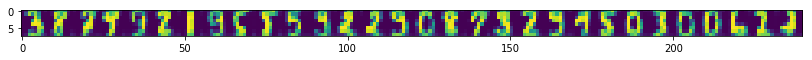

>> Epoch 391 finished 	RBM Reconstruction error 0.754990578
torch.Size([1797, 1, 8, 8])
>> Epoch 392 finished 	RBM Reconstruction error 0.903064072
torch.Size([1797, 1, 8, 8])
>> Epoch 393 finished 	RBM Reconstruction error 0.751192749
torch.Size([1797, 1, 8, 8])
>> Epoch 394 finished 	RBM Reconstruction error 0.880900025
torch.Size([1797, 1, 8, 8])
>> Epoch 395 finished 	RBM Reconstruction error 0.758810818
torch.Size([1797, 1, 8, 8])
>> Epoch 396 finished 	RBM Reconstruction error 0.920651913
torch.Size([1797, 1, 8, 8])
>> Epoch 397 finished 	RBM Reconstruction error 0.754850566
torch.Size([1797, 1, 8, 8])
>> Epoch 398 finished 	RBM Reconstruction error 0.901541531
torch.Size([1797, 1, 8, 8])
>> Epoch 399 finished 	RBM Reconstruction error 0.753242910
torch.Size([1797, 1, 8, 8])
>> Epoch 400 finished 	RBM Reconstruction error 0.884957254
[END] Pre-training step


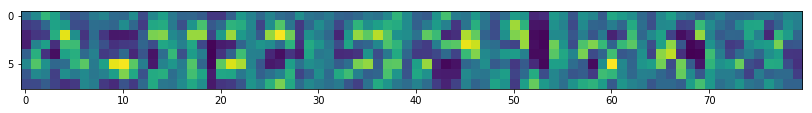

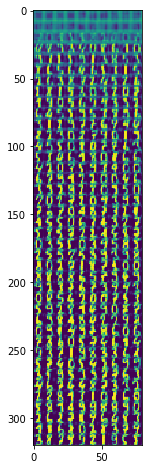

In [60]:

ims2 = []
i = 0
print_every = 5
i_hidden_bias = -1.
_n_epochs=400

def run_mnist():
    from sklearn.datasets import load_digits

    global ims2, i, print_every, i_hidden_bias, _n_epochs
    ims2 = []
    i = 0
    print_every = 10
    i_hidden_bias = -2
    _n_epochs=400
    
    #load data
    X_mnist = load_digits().data
    X_mnist = Variable(torch.Tensor(X_mnist.reshape((-1, 1, 8, 8)) / 16.))

    # hyperparameters
    structure_kernel_size = [3,3]
    optimization_algorithm="sgd"
    learning_rate_rbm=.1
    n_epochs_rbm=-1
    contrastive_divergence_iter=2
    batch_size=128
    verbose=True
    weight_decay=.001

    channels = [(1, 20)]#, (15, 10), (10, 5)]

    dbn3 = UnsupervisedDBN(structure_kernel_size,
                          channels=channels,
                          learning_rate_rbm=learning_rate_rbm,
                          n_epochs_rbm=n_epochs_rbm,
                          contrastive_divergence_iter=contrastive_divergence_iter,
                          batch_size=batch_size,
                          verbose=verbose,
                          weight_decay=weight_decay)

    print("MNIST")

    dbn3.fit(X_mnist)
    dbn3.plot_samples(10, top_down=False)
    return dbn3, ims2


dbn1, im2 = run_mnist()


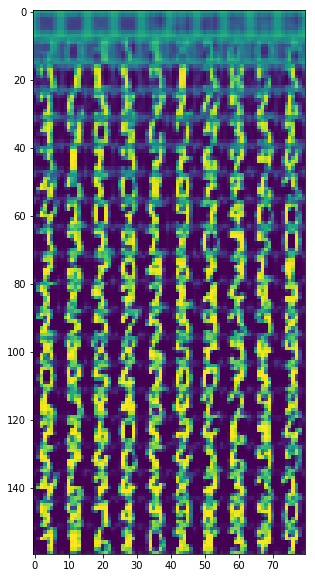

In [76]:
plt.rcParams["figure.figsize"] = (5,10)
convert_to_image(im2)

**MNIST (1-40) channel convolution**

Fastest learning proceeded with 40 channels

MNIST
3 (1, 20)
[START] Pre-training step:
torch.Size([1797, 1, 8, 8])
(8, 240)


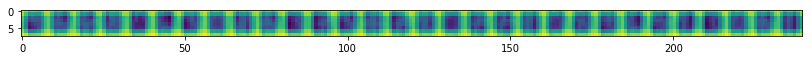

>> Epoch 1 finished 	RBM Reconstruction error 11.017486572
torch.Size([1797, 1, 8, 8])
>> Epoch 2 finished 	RBM Reconstruction error 10.957175255
torch.Size([1797, 1, 8, 8])
>> Epoch 3 finished 	RBM Reconstruction error 10.864195824
torch.Size([1797, 1, 8, 8])
>> Epoch 4 finished 	RBM Reconstruction error 10.743744850
torch.Size([1797, 1, 8, 8])
>> Epoch 5 finished 	RBM Reconstruction error 10.597366333
torch.Size([1797, 1, 8, 8])
>> Epoch 6 finished 	RBM Reconstruction error 10.420103073
torch.Size([1797, 1, 8, 8])
>> Epoch 7 finished 	RBM Reconstruction error 10.207723618
torch.Size([1797, 1, 8, 8])
>> Epoch 8 finished 	RBM Reconstruction error 9.949287415
torch.Size([1797, 1, 8, 8])
>> Epoch 9 finished 	RBM Reconstruction error 9.636045456
torch.Size([1797, 1, 8, 8])
>> Epoch 10 finished 	RBM Reconstruction error 9.253561020
torch.Size([1797, 1, 8, 8])
(8, 240)


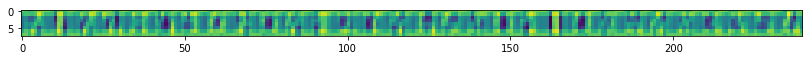

>> Epoch 11 finished 	RBM Reconstruction error 8.789092064
torch.Size([1797, 1, 8, 8])
>> Epoch 12 finished 	RBM Reconstruction error 8.234748840
torch.Size([1797, 1, 8, 8])
>> Epoch 13 finished 	RBM Reconstruction error 7.579814434
torch.Size([1797, 1, 8, 8])
>> Epoch 14 finished 	RBM Reconstruction error 6.846155167
torch.Size([1797, 1, 8, 8])
>> Epoch 15 finished 	RBM Reconstruction error 6.070033550
torch.Size([1797, 1, 8, 8])
>> Epoch 16 finished 	RBM Reconstruction error 5.322048664
torch.Size([1797, 1, 8, 8])
>> Epoch 17 finished 	RBM Reconstruction error 4.670008183
torch.Size([1797, 1, 8, 8])
>> Epoch 18 finished 	RBM Reconstruction error 4.170639038
torch.Size([1797, 1, 8, 8])
>> Epoch 19 finished 	RBM Reconstruction error 3.842307329
torch.Size([1797, 1, 8, 8])
>> Epoch 20 finished 	RBM Reconstruction error 3.605050087
torch.Size([1797, 1, 8, 8])
(8, 240)


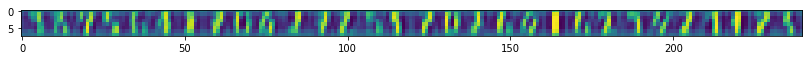

>> Epoch 21 finished 	RBM Reconstruction error 3.478991032
torch.Size([1797, 1, 8, 8])
>> Epoch 22 finished 	RBM Reconstruction error 3.359969854
torch.Size([1797, 1, 8, 8])
>> Epoch 23 finished 	RBM Reconstruction error 3.286410809
torch.Size([1797, 1, 8, 8])
>> Epoch 24 finished 	RBM Reconstruction error 3.220749855
torch.Size([1797, 1, 8, 8])
>> Epoch 25 finished 	RBM Reconstruction error 3.174583912
torch.Size([1797, 1, 8, 8])
>> Epoch 26 finished 	RBM Reconstruction error 3.110663891
torch.Size([1797, 1, 8, 8])
>> Epoch 27 finished 	RBM Reconstruction error 3.084610224
torch.Size([1797, 1, 8, 8])
>> Epoch 28 finished 	RBM Reconstruction error 3.033969402
torch.Size([1797, 1, 8, 8])
>> Epoch 29 finished 	RBM Reconstruction error 2.998936415
torch.Size([1797, 1, 8, 8])
>> Epoch 30 finished 	RBM Reconstruction error 2.962258816
torch.Size([1797, 1, 8, 8])
(8, 240)


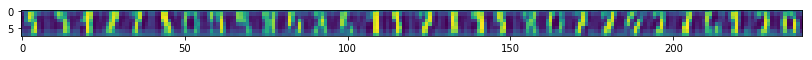

>> Epoch 31 finished 	RBM Reconstruction error 2.932292938
torch.Size([1797, 1, 8, 8])
>> Epoch 32 finished 	RBM Reconstruction error 2.892956972
torch.Size([1797, 1, 8, 8])
>> Epoch 33 finished 	RBM Reconstruction error 2.858082771
torch.Size([1797, 1, 8, 8])
>> Epoch 34 finished 	RBM Reconstruction error 2.833976746
torch.Size([1797, 1, 8, 8])
>> Epoch 35 finished 	RBM Reconstruction error 2.779251337
torch.Size([1797, 1, 8, 8])
>> Epoch 36 finished 	RBM Reconstruction error 2.774997473
torch.Size([1797, 1, 8, 8])
>> Epoch 37 finished 	RBM Reconstruction error 2.715611219
torch.Size([1797, 1, 8, 8])
>> Epoch 38 finished 	RBM Reconstruction error 2.709969521
torch.Size([1797, 1, 8, 8])
>> Epoch 39 finished 	RBM Reconstruction error 2.650851011
torch.Size([1797, 1, 8, 8])
>> Epoch 40 finished 	RBM Reconstruction error 2.646303177
torch.Size([1797, 1, 8, 8])
(8, 240)


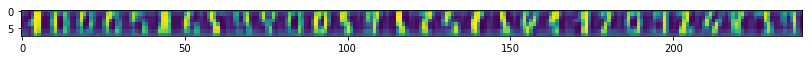

>> Epoch 41 finished 	RBM Reconstruction error 2.589525461
torch.Size([1797, 1, 8, 8])
>> Epoch 42 finished 	RBM Reconstruction error 2.586017609
torch.Size([1797, 1, 8, 8])
>> Epoch 43 finished 	RBM Reconstruction error 2.536928177
torch.Size([1797, 1, 8, 8])
>> Epoch 44 finished 	RBM Reconstruction error 2.514695168
torch.Size([1797, 1, 8, 8])
>> Epoch 45 finished 	RBM Reconstruction error 2.485457420
torch.Size([1797, 1, 8, 8])
>> Epoch 46 finished 	RBM Reconstruction error 2.468107462
torch.Size([1797, 1, 8, 8])
>> Epoch 47 finished 	RBM Reconstruction error 2.419986486
torch.Size([1797, 1, 8, 8])
>> Epoch 48 finished 	RBM Reconstruction error 2.418394327
torch.Size([1797, 1, 8, 8])
>> Epoch 49 finished 	RBM Reconstruction error 2.369974136
torch.Size([1797, 1, 8, 8])
>> Epoch 50 finished 	RBM Reconstruction error 2.367732763
torch.Size([1797, 1, 8, 8])
(8, 240)


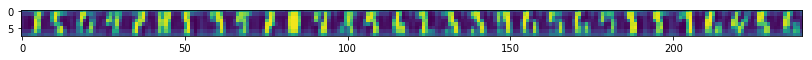

>> Epoch 51 finished 	RBM Reconstruction error 2.311543703
torch.Size([1797, 1, 8, 8])
>> Epoch 52 finished 	RBM Reconstruction error 2.347079754
torch.Size([1797, 1, 8, 8])
>> Epoch 53 finished 	RBM Reconstruction error 2.250249624
torch.Size([1797, 1, 8, 8])
>> Epoch 54 finished 	RBM Reconstruction error 2.361304283
torch.Size([1797, 1, 8, 8])
>> Epoch 55 finished 	RBM Reconstruction error 2.202749252
torch.Size([1797, 1, 8, 8])
>> Epoch 56 finished 	RBM Reconstruction error 2.429405928
torch.Size([1797, 1, 8, 8])
>> Epoch 57 finished 	RBM Reconstruction error 2.172444582
torch.Size([1797, 1, 8, 8])
>> Epoch 58 finished 	RBM Reconstruction error 2.609058380
torch.Size([1797, 1, 8, 8])
>> Epoch 59 finished 	RBM Reconstruction error 2.155730247
torch.Size([1797, 1, 8, 8])
>> Epoch 60 finished 	RBM Reconstruction error 2.775070906
torch.Size([1797, 1, 8, 8])
(8, 240)


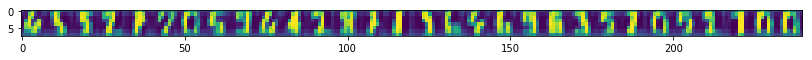

>> Epoch 61 finished 	RBM Reconstruction error 2.101595402
torch.Size([1797, 1, 8, 8])
>> Epoch 62 finished 	RBM Reconstruction error 2.544056654
torch.Size([1797, 1, 8, 8])
>> Epoch 63 finished 	RBM Reconstruction error 2.052351475
torch.Size([1797, 1, 8, 8])
>> Epoch 64 finished 	RBM Reconstruction error 2.476017714
torch.Size([1797, 1, 8, 8])
>> Epoch 65 finished 	RBM Reconstruction error 2.008967876
torch.Size([1797, 1, 8, 8])
>> Epoch 66 finished 	RBM Reconstruction error 2.379364967
torch.Size([1797, 1, 8, 8])
>> Epoch 67 finished 	RBM Reconstruction error 1.956674814
torch.Size([1797, 1, 8, 8])
>> Epoch 68 finished 	RBM Reconstruction error 2.298880577
torch.Size([1797, 1, 8, 8])
>> Epoch 69 finished 	RBM Reconstruction error 1.916055679
torch.Size([1797, 1, 8, 8])
>> Epoch 70 finished 	RBM Reconstruction error 2.301603079
torch.Size([1797, 1, 8, 8])
(8, 240)


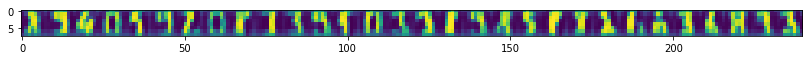

>> Epoch 71 finished 	RBM Reconstruction error 1.869300008
torch.Size([1797, 1, 8, 8])
>> Epoch 72 finished 	RBM Reconstruction error 2.220031023
torch.Size([1797, 1, 8, 8])
>> Epoch 73 finished 	RBM Reconstruction error 1.819634080
torch.Size([1797, 1, 8, 8])
>> Epoch 74 finished 	RBM Reconstruction error 2.173830748
torch.Size([1797, 1, 8, 8])
>> Epoch 75 finished 	RBM Reconstruction error 1.771151066
torch.Size([1797, 1, 8, 8])
>> Epoch 76 finished 	RBM Reconstruction error 2.082296848
torch.Size([1797, 1, 8, 8])
>> Epoch 77 finished 	RBM Reconstruction error 1.722507358
torch.Size([1797, 1, 8, 8])
>> Epoch 78 finished 	RBM Reconstruction error 2.020880461
torch.Size([1797, 1, 8, 8])
>> Epoch 79 finished 	RBM Reconstruction error 1.683902979
torch.Size([1797, 1, 8, 8])
>> Epoch 80 finished 	RBM Reconstruction error 2.079209089
torch.Size([1797, 1, 8, 8])
(8, 240)


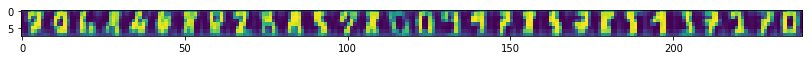

>> Epoch 81 finished 	RBM Reconstruction error 1.625904560
torch.Size([1797, 1, 8, 8])
>> Epoch 82 finished 	RBM Reconstruction error 1.903885484
torch.Size([1797, 1, 8, 8])
>> Epoch 83 finished 	RBM Reconstruction error 1.573609710
torch.Size([1797, 1, 8, 8])
>> Epoch 84 finished 	RBM Reconstruction error 1.861882210
torch.Size([1797, 1, 8, 8])
>> Epoch 85 finished 	RBM Reconstruction error 1.531325698
torch.Size([1797, 1, 8, 8])
>> Epoch 86 finished 	RBM Reconstruction error 1.804323077
torch.Size([1797, 1, 8, 8])
>> Epoch 87 finished 	RBM Reconstruction error 1.482118368
torch.Size([1797, 1, 8, 8])
>> Epoch 88 finished 	RBM Reconstruction error 1.768230319
torch.Size([1797, 1, 8, 8])
>> Epoch 89 finished 	RBM Reconstruction error 1.439420819
torch.Size([1797, 1, 8, 8])
>> Epoch 90 finished 	RBM Reconstruction error 1.702711582
torch.Size([1797, 1, 8, 8])
(8, 240)


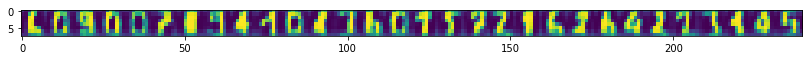

>> Epoch 91 finished 	RBM Reconstruction error 1.408082724
torch.Size([1797, 1, 8, 8])
>> Epoch 92 finished 	RBM Reconstruction error 1.709674716
torch.Size([1797, 1, 8, 8])
>> Epoch 93 finished 	RBM Reconstruction error 1.359997749
torch.Size([1797, 1, 8, 8])
>> Epoch 94 finished 	RBM Reconstruction error 1.584674597
torch.Size([1797, 1, 8, 8])
>> Epoch 95 finished 	RBM Reconstruction error 1.326018214
torch.Size([1797, 1, 8, 8])
>> Epoch 96 finished 	RBM Reconstruction error 1.572403312
torch.Size([1797, 1, 8, 8])
>> Epoch 97 finished 	RBM Reconstruction error 1.287018776
torch.Size([1797, 1, 8, 8])
>> Epoch 98 finished 	RBM Reconstruction error 1.497056484
torch.Size([1797, 1, 8, 8])
>> Epoch 99 finished 	RBM Reconstruction error 1.263012171
torch.Size([1797, 1, 8, 8])
>> Epoch 100 finished 	RBM Reconstruction error 1.487881422
torch.Size([1797, 1, 8, 8])
(8, 240)


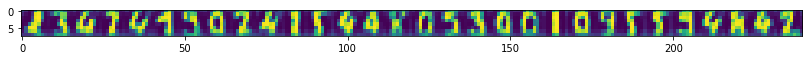

>> Epoch 101 finished 	RBM Reconstruction error 1.228898525
torch.Size([1797, 1, 8, 8])
>> Epoch 102 finished 	RBM Reconstruction error 1.413548470
torch.Size([1797, 1, 8, 8])
>> Epoch 103 finished 	RBM Reconstruction error 1.199865341
torch.Size([1797, 1, 8, 8])
>> Epoch 104 finished 	RBM Reconstruction error 1.360307217
torch.Size([1797, 1, 8, 8])
>> Epoch 105 finished 	RBM Reconstruction error 1.185453534
torch.Size([1797, 1, 8, 8])
>> Epoch 106 finished 	RBM Reconstruction error 1.390328050
torch.Size([1797, 1, 8, 8])
>> Epoch 107 finished 	RBM Reconstruction error 1.173308969
torch.Size([1797, 1, 8, 8])
>> Epoch 108 finished 	RBM Reconstruction error 1.390994310
torch.Size([1797, 1, 8, 8])
>> Epoch 109 finished 	RBM Reconstruction error 1.151311159
torch.Size([1797, 1, 8, 8])
>> Epoch 110 finished 	RBM Reconstruction error 1.321525335
torch.Size([1797, 1, 8, 8])
(8, 240)


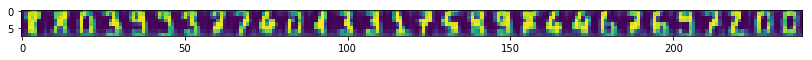

>> Epoch 111 finished 	RBM Reconstruction error 1.130594373
torch.Size([1797, 1, 8, 8])
>> Epoch 112 finished 	RBM Reconstruction error 1.306228876
torch.Size([1797, 1, 8, 8])
>> Epoch 113 finished 	RBM Reconstruction error 1.119128108
torch.Size([1797, 1, 8, 8])
>> Epoch 114 finished 	RBM Reconstruction error 1.306571007
torch.Size([1797, 1, 8, 8])
>> Epoch 115 finished 	RBM Reconstruction error 1.108069539
torch.Size([1797, 1, 8, 8])
>> Epoch 116 finished 	RBM Reconstruction error 1.301960707
torch.Size([1797, 1, 8, 8])
>> Epoch 117 finished 	RBM Reconstruction error 1.097726226
torch.Size([1797, 1, 8, 8])
>> Epoch 118 finished 	RBM Reconstruction error 1.273620009
torch.Size([1797, 1, 8, 8])
>> Epoch 119 finished 	RBM Reconstruction error 1.081739306
torch.Size([1797, 1, 8, 8])
>> Epoch 120 finished 	RBM Reconstruction error 1.263355732
torch.Size([1797, 1, 8, 8])
(8, 240)


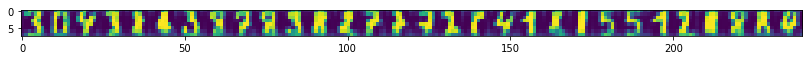

>> Epoch 121 finished 	RBM Reconstruction error 1.067881584
torch.Size([1797, 1, 8, 8])
>> Epoch 122 finished 	RBM Reconstruction error 1.239614010
torch.Size([1797, 1, 8, 8])
>> Epoch 123 finished 	RBM Reconstruction error 1.052798748
torch.Size([1797, 1, 8, 8])
>> Epoch 124 finished 	RBM Reconstruction error 1.221559882
torch.Size([1797, 1, 8, 8])
>> Epoch 125 finished 	RBM Reconstruction error 1.051201582
torch.Size([1797, 1, 8, 8])
>> Epoch 126 finished 	RBM Reconstruction error 1.259003162
torch.Size([1797, 1, 8, 8])
>> Epoch 127 finished 	RBM Reconstruction error 1.035897493
torch.Size([1797, 1, 8, 8])
>> Epoch 128 finished 	RBM Reconstruction error 1.205239058
torch.Size([1797, 1, 8, 8])
>> Epoch 129 finished 	RBM Reconstruction error 1.027422190
torch.Size([1797, 1, 8, 8])
>> Epoch 130 finished 	RBM Reconstruction error 1.230572224
torch.Size([1797, 1, 8, 8])
(8, 240)


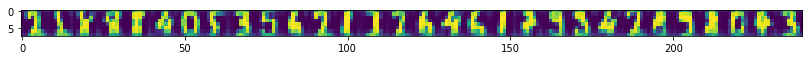

>> Epoch 131 finished 	RBM Reconstruction error 1.019071579
torch.Size([1797, 1, 8, 8])
>> Epoch 132 finished 	RBM Reconstruction error 1.191709876
torch.Size([1797, 1, 8, 8])
>> Epoch 133 finished 	RBM Reconstruction error 1.016837120
torch.Size([1797, 1, 8, 8])
>> Epoch 134 finished 	RBM Reconstruction error 1.206724405
torch.Size([1797, 1, 8, 8])
>> Epoch 135 finished 	RBM Reconstruction error 1.011412621
torch.Size([1797, 1, 8, 8])
>> Epoch 136 finished 	RBM Reconstruction error 1.222128153
torch.Size([1797, 1, 8, 8])
>> Epoch 137 finished 	RBM Reconstruction error 0.998787940
torch.Size([1797, 1, 8, 8])
>> Epoch 138 finished 	RBM Reconstruction error 1.197649360
torch.Size([1797, 1, 8, 8])
>> Epoch 139 finished 	RBM Reconstruction error 0.992925167
torch.Size([1797, 1, 8, 8])
>> Epoch 140 finished 	RBM Reconstruction error 1.159762979
torch.Size([1797, 1, 8, 8])
(8, 240)


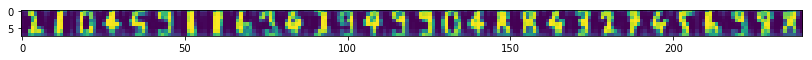

>> Epoch 141 finished 	RBM Reconstruction error 0.975196123
torch.Size([1797, 1, 8, 8])
>> Epoch 142 finished 	RBM Reconstruction error 1.143046379
torch.Size([1797, 1, 8, 8])
>> Epoch 143 finished 	RBM Reconstruction error 0.977255166
torch.Size([1797, 1, 8, 8])
>> Epoch 144 finished 	RBM Reconstruction error 1.185328722
torch.Size([1797, 1, 8, 8])
>> Epoch 145 finished 	RBM Reconstruction error 0.972915173
torch.Size([1797, 1, 8, 8])
>> Epoch 146 finished 	RBM Reconstruction error 1.153637528
torch.Size([1797, 1, 8, 8])
>> Epoch 147 finished 	RBM Reconstruction error 0.975032806
torch.Size([1797, 1, 8, 8])
>> Epoch 148 finished 	RBM Reconstruction error 1.173501372
torch.Size([1797, 1, 8, 8])
>> Epoch 149 finished 	RBM Reconstruction error 0.957018435
torch.Size([1797, 1, 8, 8])
>> Epoch 150 finished 	RBM Reconstruction error 1.148532867
torch.Size([1797, 1, 8, 8])
(8, 240)


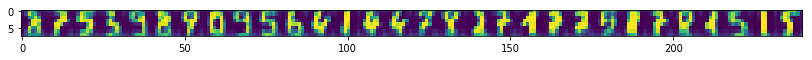

>> Epoch 151 finished 	RBM Reconstruction error 0.948683739
torch.Size([1797, 1, 8, 8])
>> Epoch 152 finished 	RBM Reconstruction error 1.126742482
torch.Size([1797, 1, 8, 8])
>> Epoch 153 finished 	RBM Reconstruction error 0.941387832
torch.Size([1797, 1, 8, 8])
>> Epoch 154 finished 	RBM Reconstruction error 1.129348516
torch.Size([1797, 1, 8, 8])
>> Epoch 155 finished 	RBM Reconstruction error 0.939724088
torch.Size([1797, 1, 8, 8])
>> Epoch 156 finished 	RBM Reconstruction error 1.139124036
torch.Size([1797, 1, 8, 8])
>> Epoch 157 finished 	RBM Reconstruction error 0.934634328
torch.Size([1797, 1, 8, 8])
>> Epoch 158 finished 	RBM Reconstruction error 1.122671604
torch.Size([1797, 1, 8, 8])
>> Epoch 159 finished 	RBM Reconstruction error 0.918570220
torch.Size([1797, 1, 8, 8])
>> Epoch 160 finished 	RBM Reconstruction error 1.097496986
torch.Size([1797, 1, 8, 8])
(8, 240)


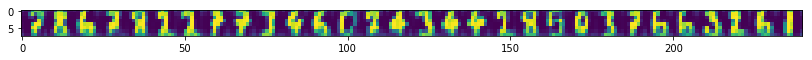

>> Epoch 161 finished 	RBM Reconstruction error 0.917816103
torch.Size([1797, 1, 8, 8])
>> Epoch 162 finished 	RBM Reconstruction error 1.080339074
torch.Size([1797, 1, 8, 8])
>> Epoch 163 finished 	RBM Reconstruction error 0.931011200
torch.Size([1797, 1, 8, 8])
>> Epoch 164 finished 	RBM Reconstruction error 1.166699171
torch.Size([1797, 1, 8, 8])
>> Epoch 165 finished 	RBM Reconstruction error 0.922812581
torch.Size([1797, 1, 8, 8])
>> Epoch 166 finished 	RBM Reconstruction error 1.138309836
torch.Size([1797, 1, 8, 8])
>> Epoch 167 finished 	RBM Reconstruction error 0.913952112
torch.Size([1797, 1, 8, 8])
>> Epoch 168 finished 	RBM Reconstruction error 1.111462355
torch.Size([1797, 1, 8, 8])
>> Epoch 169 finished 	RBM Reconstruction error 0.908916593
torch.Size([1797, 1, 8, 8])
>> Epoch 170 finished 	RBM Reconstruction error 1.109860063
torch.Size([1797, 1, 8, 8])
(8, 240)


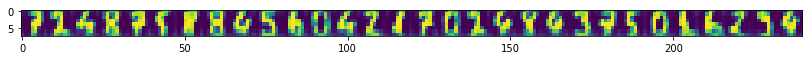

>> Epoch 171 finished 	RBM Reconstruction error 0.907262206
torch.Size([1797, 1, 8, 8])
>> Epoch 172 finished 	RBM Reconstruction error 1.124918580
torch.Size([1797, 1, 8, 8])
>> Epoch 173 finished 	RBM Reconstruction error 0.907606006
torch.Size([1797, 1, 8, 8])
>> Epoch 174 finished 	RBM Reconstruction error 1.113604784
torch.Size([1797, 1, 8, 8])
>> Epoch 175 finished 	RBM Reconstruction error 0.901471853
torch.Size([1797, 1, 8, 8])
>> Epoch 176 finished 	RBM Reconstruction error 1.082276940
torch.Size([1797, 1, 8, 8])
>> Epoch 177 finished 	RBM Reconstruction error 0.895603061
torch.Size([1797, 1, 8, 8])
>> Epoch 178 finished 	RBM Reconstruction error 1.112179279
torch.Size([1797, 1, 8, 8])
>> Epoch 179 finished 	RBM Reconstruction error 0.891600072
torch.Size([1797, 1, 8, 8])
>> Epoch 180 finished 	RBM Reconstruction error 1.085624099
torch.Size([1797, 1, 8, 8])
(8, 240)


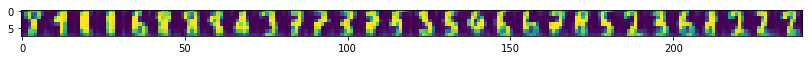

>> Epoch 181 finished 	RBM Reconstruction error 0.870605230
torch.Size([1797, 1, 8, 8])
>> Epoch 182 finished 	RBM Reconstruction error 1.020297408
torch.Size([1797, 1, 8, 8])
>> Epoch 183 finished 	RBM Reconstruction error 0.885962069
torch.Size([1797, 1, 8, 8])
>> Epoch 184 finished 	RBM Reconstruction error 1.104871511
torch.Size([1797, 1, 8, 8])
>> Epoch 185 finished 	RBM Reconstruction error 0.880974710
torch.Size([1797, 1, 8, 8])
>> Epoch 186 finished 	RBM Reconstruction error 1.080791712
torch.Size([1797, 1, 8, 8])
>> Epoch 187 finished 	RBM Reconstruction error 0.879278302
torch.Size([1797, 1, 8, 8])
>> Epoch 188 finished 	RBM Reconstruction error 1.063963652
torch.Size([1797, 1, 8, 8])
>> Epoch 189 finished 	RBM Reconstruction error 0.872657299
torch.Size([1797, 1, 8, 8])
>> Epoch 190 finished 	RBM Reconstruction error 1.080527544
torch.Size([1797, 1, 8, 8])
(8, 240)


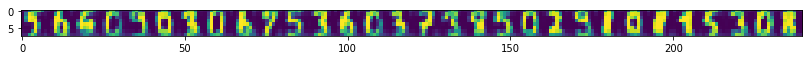

>> Epoch 191 finished 	RBM Reconstruction error 0.877482593
torch.Size([1797, 1, 8, 8])
>> Epoch 192 finished 	RBM Reconstruction error 1.116392016
torch.Size([1797, 1, 8, 8])
>> Epoch 193 finished 	RBM Reconstruction error 0.865771115
torch.Size([1797, 1, 8, 8])
>> Epoch 194 finished 	RBM Reconstruction error 1.032605290
torch.Size([1797, 1, 8, 8])
>> Epoch 195 finished 	RBM Reconstruction error 0.864032626
torch.Size([1797, 1, 8, 8])
>> Epoch 196 finished 	RBM Reconstruction error 1.059554100
torch.Size([1797, 1, 8, 8])
>> Epoch 197 finished 	RBM Reconstruction error 0.860308588
torch.Size([1797, 1, 8, 8])
>> Epoch 198 finished 	RBM Reconstruction error 1.035972953
torch.Size([1797, 1, 8, 8])
>> Epoch 199 finished 	RBM Reconstruction error 0.864423394
torch.Size([1797, 1, 8, 8])
>> Epoch 200 finished 	RBM Reconstruction error 1.083606958
torch.Size([1797, 1, 8, 8])
(8, 240)


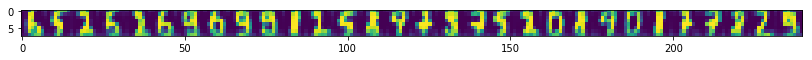

>> Epoch 201 finished 	RBM Reconstruction error 0.861561120
torch.Size([1797, 1, 8, 8])
>> Epoch 202 finished 	RBM Reconstruction error 1.052736521
torch.Size([1797, 1, 8, 8])
>> Epoch 203 finished 	RBM Reconstruction error 0.863134682
torch.Size([1797, 1, 8, 8])
>> Epoch 204 finished 	RBM Reconstruction error 1.069307566
torch.Size([1797, 1, 8, 8])
>> Epoch 205 finished 	RBM Reconstruction error 0.857376039
torch.Size([1797, 1, 8, 8])
>> Epoch 206 finished 	RBM Reconstruction error 1.041654587
torch.Size([1797, 1, 8, 8])
>> Epoch 207 finished 	RBM Reconstruction error 0.847321808
torch.Size([1797, 1, 8, 8])
>> Epoch 208 finished 	RBM Reconstruction error 1.012110710
torch.Size([1797, 1, 8, 8])
>> Epoch 209 finished 	RBM Reconstruction error 0.855587423
torch.Size([1797, 1, 8, 8])
>> Epoch 210 finished 	RBM Reconstruction error 1.018424630
torch.Size([1797, 1, 8, 8])
(8, 240)


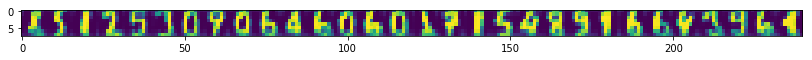

>> Epoch 211 finished 	RBM Reconstruction error 0.844608068
torch.Size([1797, 1, 8, 8])
>> Epoch 212 finished 	RBM Reconstruction error 1.051923752
torch.Size([1797, 1, 8, 8])
>> Epoch 213 finished 	RBM Reconstruction error 0.852268517
torch.Size([1797, 1, 8, 8])
>> Epoch 214 finished 	RBM Reconstruction error 1.085779309
torch.Size([1797, 1, 8, 8])
>> Epoch 215 finished 	RBM Reconstruction error 0.851301610
torch.Size([1797, 1, 8, 8])
>> Epoch 216 finished 	RBM Reconstruction error 1.092161417
torch.Size([1797, 1, 8, 8])
>> Epoch 217 finished 	RBM Reconstruction error 0.850098431
torch.Size([1797, 1, 8, 8])
>> Epoch 218 finished 	RBM Reconstruction error 1.082932591
torch.Size([1797, 1, 8, 8])
>> Epoch 219 finished 	RBM Reconstruction error 0.844359219
torch.Size([1797, 1, 8, 8])
>> Epoch 220 finished 	RBM Reconstruction error 1.035489917
torch.Size([1797, 1, 8, 8])
(8, 240)


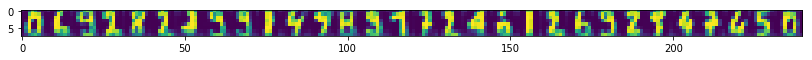

>> Epoch 221 finished 	RBM Reconstruction error 0.829695702
torch.Size([1797, 1, 8, 8])
>> Epoch 222 finished 	RBM Reconstruction error 1.018840075
torch.Size([1797, 1, 8, 8])
>> Epoch 223 finished 	RBM Reconstruction error 0.837481916
torch.Size([1797, 1, 8, 8])
>> Epoch 224 finished 	RBM Reconstruction error 1.052942872
torch.Size([1797, 1, 8, 8])
>> Epoch 225 finished 	RBM Reconstruction error 0.838935256
torch.Size([1797, 1, 8, 8])
>> Epoch 226 finished 	RBM Reconstruction error 1.015243053
torch.Size([1797, 1, 8, 8])
>> Epoch 227 finished 	RBM Reconstruction error 0.830234587
torch.Size([1797, 1, 8, 8])
>> Epoch 228 finished 	RBM Reconstruction error 1.050132394
torch.Size([1797, 1, 8, 8])
>> Epoch 229 finished 	RBM Reconstruction error 0.830405712
torch.Size([1797, 1, 8, 8])
>> Epoch 230 finished 	RBM Reconstruction error 1.024267316
torch.Size([1797, 1, 8, 8])
(8, 240)


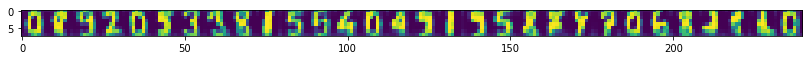

>> Epoch 231 finished 	RBM Reconstruction error 0.837365210
torch.Size([1797, 1, 8, 8])
>> Epoch 232 finished 	RBM Reconstruction error 1.014112830
torch.Size([1797, 1, 8, 8])
>> Epoch 233 finished 	RBM Reconstruction error 0.836386323
torch.Size([1797, 1, 8, 8])
>> Epoch 234 finished 	RBM Reconstruction error 1.048968434
torch.Size([1797, 1, 8, 8])
>> Epoch 235 finished 	RBM Reconstruction error 0.837573528
torch.Size([1797, 1, 8, 8])
>> Epoch 236 finished 	RBM Reconstruction error 1.050783038
torch.Size([1797, 1, 8, 8])
>> Epoch 237 finished 	RBM Reconstruction error 0.833997667
torch.Size([1797, 1, 8, 8])
>> Epoch 238 finished 	RBM Reconstruction error 1.011216044
torch.Size([1797, 1, 8, 8])
>> Epoch 239 finished 	RBM Reconstruction error 0.819081008
torch.Size([1797, 1, 8, 8])
>> Epoch 240 finished 	RBM Reconstruction error 0.944580495
torch.Size([1797, 1, 8, 8])
(8, 240)


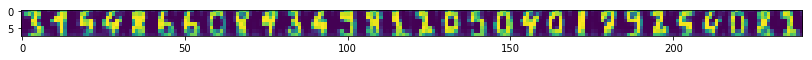

>> Epoch 241 finished 	RBM Reconstruction error 0.829292595
torch.Size([1797, 1, 8, 8])
>> Epoch 242 finished 	RBM Reconstruction error 1.056763887
torch.Size([1797, 1, 8, 8])
>> Epoch 243 finished 	RBM Reconstruction error 0.837435663
torch.Size([1797, 1, 8, 8])
>> Epoch 244 finished 	RBM Reconstruction error 1.052404881
torch.Size([1797, 1, 8, 8])
>> Epoch 245 finished 	RBM Reconstruction error 0.831433535
torch.Size([1797, 1, 8, 8])
>> Epoch 246 finished 	RBM Reconstruction error 1.053356647
torch.Size([1797, 1, 8, 8])
>> Epoch 247 finished 	RBM Reconstruction error 0.820017815
torch.Size([1797, 1, 8, 8])
>> Epoch 248 finished 	RBM Reconstruction error 1.014308929
torch.Size([1797, 1, 8, 8])
>> Epoch 249 finished 	RBM Reconstruction error 0.824896157
torch.Size([1797, 1, 8, 8])
>> Epoch 250 finished 	RBM Reconstruction error 1.040669084
torch.Size([1797, 1, 8, 8])
(8, 240)


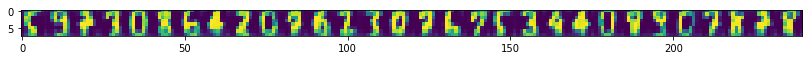

>> Epoch 251 finished 	RBM Reconstruction error 0.824120939
torch.Size([1797, 1, 8, 8])
>> Epoch 252 finished 	RBM Reconstruction error 1.029661536
torch.Size([1797, 1, 8, 8])
>> Epoch 253 finished 	RBM Reconstruction error 0.820041418
torch.Size([1797, 1, 8, 8])
>> Epoch 254 finished 	RBM Reconstruction error 0.992459536
torch.Size([1797, 1, 8, 8])
>> Epoch 255 finished 	RBM Reconstruction error 0.812031031
torch.Size([1797, 1, 8, 8])
>> Epoch 256 finished 	RBM Reconstruction error 0.962209404
torch.Size([1797, 1, 8, 8])
>> Epoch 257 finished 	RBM Reconstruction error 0.813461781
torch.Size([1797, 1, 8, 8])
>> Epoch 258 finished 	RBM Reconstruction error 0.999534309
torch.Size([1797, 1, 8, 8])
>> Epoch 259 finished 	RBM Reconstruction error 0.833693206
torch.Size([1797, 1, 8, 8])
>> Epoch 260 finished 	RBM Reconstruction error 1.073137164
torch.Size([1797, 1, 8, 8])
(8, 240)


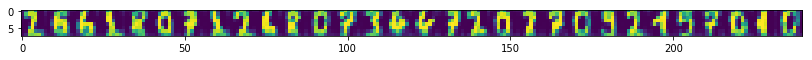

>> Epoch 261 finished 	RBM Reconstruction error 0.818960309
torch.Size([1797, 1, 8, 8])
>> Epoch 262 finished 	RBM Reconstruction error 1.013459921
torch.Size([1797, 1, 8, 8])
>> Epoch 263 finished 	RBM Reconstruction error 0.813780487
torch.Size([1797, 1, 8, 8])
>> Epoch 264 finished 	RBM Reconstruction error 1.000690699
torch.Size([1797, 1, 8, 8])
>> Epoch 265 finished 	RBM Reconstruction error 0.812118590
torch.Size([1797, 1, 8, 8])
>> Epoch 266 finished 	RBM Reconstruction error 1.023311496
torch.Size([1797, 1, 8, 8])
>> Epoch 267 finished 	RBM Reconstruction error 0.823184788
torch.Size([1797, 1, 8, 8])
>> Epoch 268 finished 	RBM Reconstruction error 1.054114223
torch.Size([1797, 1, 8, 8])
>> Epoch 269 finished 	RBM Reconstruction error 0.807926834
torch.Size([1797, 1, 8, 8])
>> Epoch 270 finished 	RBM Reconstruction error 0.961336017
torch.Size([1797, 1, 8, 8])
(8, 240)


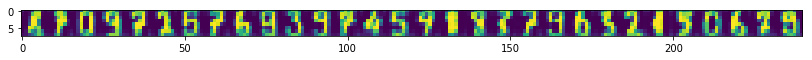

>> Epoch 271 finished 	RBM Reconstruction error 0.808037579
torch.Size([1797, 1, 8, 8])
>> Epoch 272 finished 	RBM Reconstruction error 0.998747051
torch.Size([1797, 1, 8, 8])
>> Epoch 273 finished 	RBM Reconstruction error 0.823581517
torch.Size([1797, 1, 8, 8])
>> Epoch 274 finished 	RBM Reconstruction error 1.043512702
torch.Size([1797, 1, 8, 8])
>> Epoch 275 finished 	RBM Reconstruction error 0.827559352
torch.Size([1797, 1, 8, 8])
>> Epoch 276 finished 	RBM Reconstruction error 1.058913827
torch.Size([1797, 1, 8, 8])
>> Epoch 277 finished 	RBM Reconstruction error 0.815039754
torch.Size([1797, 1, 8, 8])
>> Epoch 278 finished 	RBM Reconstruction error 1.005863428
torch.Size([1797, 1, 8, 8])
>> Epoch 279 finished 	RBM Reconstruction error 0.813196182
torch.Size([1797, 1, 8, 8])
>> Epoch 280 finished 	RBM Reconstruction error 1.007194757
torch.Size([1797, 1, 8, 8])
(8, 240)


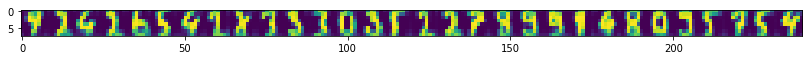

>> Epoch 281 finished 	RBM Reconstruction error 0.810412705
torch.Size([1797, 1, 8, 8])
>> Epoch 282 finished 	RBM Reconstruction error 1.010176539
torch.Size([1797, 1, 8, 8])
>> Epoch 283 finished 	RBM Reconstruction error 0.811857283
torch.Size([1797, 1, 8, 8])
>> Epoch 284 finished 	RBM Reconstruction error 1.030169487
torch.Size([1797, 1, 8, 8])
>> Epoch 285 finished 	RBM Reconstruction error 0.809331834
torch.Size([1797, 1, 8, 8])
>> Epoch 286 finished 	RBM Reconstruction error 1.002897978
torch.Size([1797, 1, 8, 8])
>> Epoch 287 finished 	RBM Reconstruction error 0.814780891
torch.Size([1797, 1, 8, 8])
>> Epoch 288 finished 	RBM Reconstruction error 1.034095526
torch.Size([1797, 1, 8, 8])
>> Epoch 289 finished 	RBM Reconstruction error 0.805246592
torch.Size([1797, 1, 8, 8])
>> Epoch 290 finished 	RBM Reconstruction error 1.015068531
torch.Size([1797, 1, 8, 8])
(8, 240)


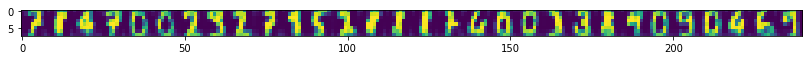

>> Epoch 291 finished 	RBM Reconstruction error 0.810046196
torch.Size([1797, 1, 8, 8])
>> Epoch 292 finished 	RBM Reconstruction error 1.024024129
torch.Size([1797, 1, 8, 8])
>> Epoch 293 finished 	RBM Reconstruction error 0.793668330
torch.Size([1797, 1, 8, 8])
>> Epoch 294 finished 	RBM Reconstruction error 0.977730334
torch.Size([1797, 1, 8, 8])
>> Epoch 295 finished 	RBM Reconstruction error 0.807586133
torch.Size([1797, 1, 8, 8])
>> Epoch 296 finished 	RBM Reconstruction error 1.004137278
torch.Size([1797, 1, 8, 8])
>> Epoch 297 finished 	RBM Reconstruction error 0.812867522
torch.Size([1797, 1, 8, 8])
>> Epoch 298 finished 	RBM Reconstruction error 1.009371281
torch.Size([1797, 1, 8, 8])
>> Epoch 299 finished 	RBM Reconstruction error 0.814161777
torch.Size([1797, 1, 8, 8])
>> Epoch 300 finished 	RBM Reconstruction error 1.043139815
torch.Size([1797, 1, 8, 8])
(8, 240)


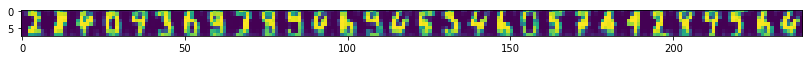

>> Epoch 301 finished 	RBM Reconstruction error 0.804595828
torch.Size([1797, 1, 8, 8])
>> Epoch 302 finished 	RBM Reconstruction error 1.025238752
torch.Size([1797, 1, 8, 8])
>> Epoch 303 finished 	RBM Reconstruction error 0.801209331
torch.Size([1797, 1, 8, 8])
>> Epoch 304 finished 	RBM Reconstruction error 1.011177540
torch.Size([1797, 1, 8, 8])
>> Epoch 305 finished 	RBM Reconstruction error 0.805619419
torch.Size([1797, 1, 8, 8])
>> Epoch 306 finished 	RBM Reconstruction error 1.016844511
torch.Size([1797, 1, 8, 8])
>> Epoch 307 finished 	RBM Reconstruction error 0.804119110
torch.Size([1797, 1, 8, 8])
>> Epoch 308 finished 	RBM Reconstruction error 1.033382416
torch.Size([1797, 1, 8, 8])
>> Epoch 309 finished 	RBM Reconstruction error 0.800010562
torch.Size([1797, 1, 8, 8])
>> Epoch 310 finished 	RBM Reconstruction error 1.004870772
torch.Size([1797, 1, 8, 8])
(8, 240)


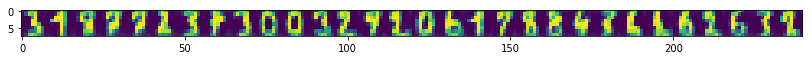

>> Epoch 311 finished 	RBM Reconstruction error 0.791414678
torch.Size([1797, 1, 8, 8])
>> Epoch 312 finished 	RBM Reconstruction error 0.957467735
torch.Size([1797, 1, 8, 8])
>> Epoch 313 finished 	RBM Reconstruction error 0.797448575
torch.Size([1797, 1, 8, 8])
>> Epoch 314 finished 	RBM Reconstruction error 1.001233935
torch.Size([1797, 1, 8, 8])
>> Epoch 315 finished 	RBM Reconstruction error 0.802790582
torch.Size([1797, 1, 8, 8])
>> Epoch 316 finished 	RBM Reconstruction error 1.037417293
torch.Size([1797, 1, 8, 8])
>> Epoch 317 finished 	RBM Reconstruction error 0.803784072
torch.Size([1797, 1, 8, 8])
>> Epoch 318 finished 	RBM Reconstruction error 0.997992098
torch.Size([1797, 1, 8, 8])
>> Epoch 319 finished 	RBM Reconstruction error 0.794139564
torch.Size([1797, 1, 8, 8])
>> Epoch 320 finished 	RBM Reconstruction error 0.979934394
torch.Size([1797, 1, 8, 8])
(8, 240)


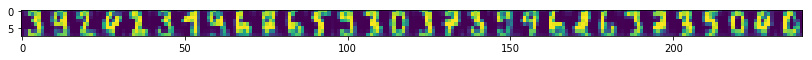

>> Epoch 321 finished 	RBM Reconstruction error 0.795515954
torch.Size([1797, 1, 8, 8])
>> Epoch 322 finished 	RBM Reconstruction error 1.027837515
torch.Size([1797, 1, 8, 8])
>> Epoch 323 finished 	RBM Reconstruction error 0.794790685
torch.Size([1797, 1, 8, 8])
>> Epoch 324 finished 	RBM Reconstruction error 0.982563376
torch.Size([1797, 1, 8, 8])
>> Epoch 325 finished 	RBM Reconstruction error 0.798456788
torch.Size([1797, 1, 8, 8])
>> Epoch 326 finished 	RBM Reconstruction error 0.968134344
torch.Size([1797, 1, 8, 8])
>> Epoch 327 finished 	RBM Reconstruction error 0.790907323
torch.Size([1797, 1, 8, 8])
>> Epoch 328 finished 	RBM Reconstruction error 0.971590102
torch.Size([1797, 1, 8, 8])
>> Epoch 329 finished 	RBM Reconstruction error 0.790993631
torch.Size([1797, 1, 8, 8])
>> Epoch 330 finished 	RBM Reconstruction error 0.969371080
torch.Size([1797, 1, 8, 8])
(8, 240)


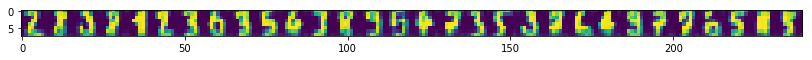

>> Epoch 331 finished 	RBM Reconstruction error 0.800875723
torch.Size([1797, 1, 8, 8])
>> Epoch 332 finished 	RBM Reconstruction error 1.026335120
torch.Size([1797, 1, 8, 8])
>> Epoch 333 finished 	RBM Reconstruction error 0.808822453
torch.Size([1797, 1, 8, 8])
>> Epoch 334 finished 	RBM Reconstruction error 0.997976720
torch.Size([1797, 1, 8, 8])
>> Epoch 335 finished 	RBM Reconstruction error 0.798006177
torch.Size([1797, 1, 8, 8])
>> Epoch 336 finished 	RBM Reconstruction error 0.981323063
torch.Size([1797, 1, 8, 8])
>> Epoch 337 finished 	RBM Reconstruction error 0.803289592
torch.Size([1797, 1, 8, 8])
>> Epoch 338 finished 	RBM Reconstruction error 1.038181305
torch.Size([1797, 1, 8, 8])
>> Epoch 339 finished 	RBM Reconstruction error 0.798386216
torch.Size([1797, 1, 8, 8])
>> Epoch 340 finished 	RBM Reconstruction error 1.014880180
torch.Size([1797, 1, 8, 8])
(8, 240)


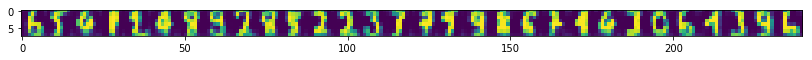

>> Epoch 341 finished 	RBM Reconstruction error 0.795646191
torch.Size([1797, 1, 8, 8])
>> Epoch 342 finished 	RBM Reconstruction error 1.003334165
torch.Size([1797, 1, 8, 8])
>> Epoch 343 finished 	RBM Reconstruction error 0.795328259
torch.Size([1797, 1, 8, 8])
>> Epoch 344 finished 	RBM Reconstruction error 1.001183152
torch.Size([1797, 1, 8, 8])
>> Epoch 345 finished 	RBM Reconstruction error 0.789106488
torch.Size([1797, 1, 8, 8])
>> Epoch 346 finished 	RBM Reconstruction error 0.951193690
torch.Size([1797, 1, 8, 8])
>> Epoch 347 finished 	RBM Reconstruction error 0.797559381
torch.Size([1797, 1, 8, 8])
>> Epoch 348 finished 	RBM Reconstruction error 1.013197899
torch.Size([1797, 1, 8, 8])
>> Epoch 349 finished 	RBM Reconstruction error 0.796603620
torch.Size([1797, 1, 8, 8])
>> Epoch 350 finished 	RBM Reconstruction error 0.995339036
torch.Size([1797, 1, 8, 8])
(8, 240)


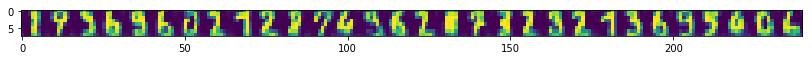

>> Epoch 351 finished 	RBM Reconstruction error 0.808877170
torch.Size([1797, 1, 8, 8])
>> Epoch 352 finished 	RBM Reconstruction error 1.048124313
torch.Size([1797, 1, 8, 8])
>> Epoch 353 finished 	RBM Reconstruction error 0.796342492
torch.Size([1797, 1, 8, 8])
>> Epoch 354 finished 	RBM Reconstruction error 0.977827191
torch.Size([1797, 1, 8, 8])
>> Epoch 355 finished 	RBM Reconstruction error 0.787400246
torch.Size([1797, 1, 8, 8])
>> Epoch 356 finished 	RBM Reconstruction error 0.975220144
torch.Size([1797, 1, 8, 8])
>> Epoch 357 finished 	RBM Reconstruction error 0.794232011
torch.Size([1797, 1, 8, 8])
>> Epoch 358 finished 	RBM Reconstruction error 0.963431776
torch.Size([1797, 1, 8, 8])
>> Epoch 359 finished 	RBM Reconstruction error 0.793607295
torch.Size([1797, 1, 8, 8])
>> Epoch 360 finished 	RBM Reconstruction error 0.968538463
torch.Size([1797, 1, 8, 8])
(8, 240)


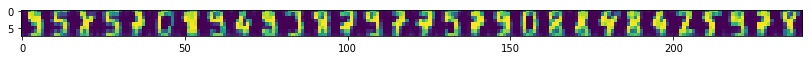

>> Epoch 361 finished 	RBM Reconstruction error 0.795928597
torch.Size([1797, 1, 8, 8])
>> Epoch 362 finished 	RBM Reconstruction error 1.011070132
torch.Size([1797, 1, 8, 8])
>> Epoch 363 finished 	RBM Reconstruction error 0.784367502
torch.Size([1797, 1, 8, 8])
>> Epoch 364 finished 	RBM Reconstruction error 0.972962201
torch.Size([1797, 1, 8, 8])
>> Epoch 365 finished 	RBM Reconstruction error 0.786381304
torch.Size([1797, 1, 8, 8])
>> Epoch 366 finished 	RBM Reconstruction error 0.933966458
torch.Size([1797, 1, 8, 8])
>> Epoch 367 finished 	RBM Reconstruction error 0.794720769
torch.Size([1797, 1, 8, 8])
>> Epoch 368 finished 	RBM Reconstruction error 0.993042707
torch.Size([1797, 1, 8, 8])
>> Epoch 369 finished 	RBM Reconstruction error 0.798598647
torch.Size([1797, 1, 8, 8])
>> Epoch 370 finished 	RBM Reconstruction error 0.985670209
torch.Size([1797, 1, 8, 8])
(8, 240)


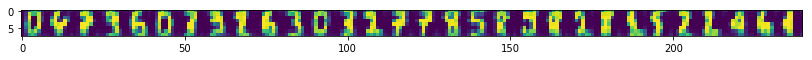

>> Epoch 371 finished 	RBM Reconstruction error 0.791214764
torch.Size([1797, 1, 8, 8])
>> Epoch 372 finished 	RBM Reconstruction error 0.979256928
torch.Size([1797, 1, 8, 8])
>> Epoch 373 finished 	RBM Reconstruction error 0.794634819
torch.Size([1797, 1, 8, 8])
>> Epoch 374 finished 	RBM Reconstruction error 1.000513077
torch.Size([1797, 1, 8, 8])
>> Epoch 375 finished 	RBM Reconstruction error 0.800074339
torch.Size([1797, 1, 8, 8])
>> Epoch 376 finished 	RBM Reconstruction error 0.995262146
torch.Size([1797, 1, 8, 8])
>> Epoch 377 finished 	RBM Reconstruction error 0.796041787
torch.Size([1797, 1, 8, 8])
>> Epoch 378 finished 	RBM Reconstruction error 0.973827779
torch.Size([1797, 1, 8, 8])
>> Epoch 379 finished 	RBM Reconstruction error 0.782559335
torch.Size([1797, 1, 8, 8])
>> Epoch 380 finished 	RBM Reconstruction error 0.941838384
torch.Size([1797, 1, 8, 8])
(8, 240)


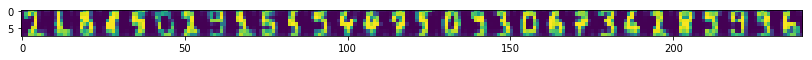

>> Epoch 381 finished 	RBM Reconstruction error 0.783338130
torch.Size([1797, 1, 8, 8])
>> Epoch 382 finished 	RBM Reconstruction error 0.964086711
torch.Size([1797, 1, 8, 8])
>> Epoch 383 finished 	RBM Reconstruction error 0.796105325
torch.Size([1797, 1, 8, 8])
>> Epoch 384 finished 	RBM Reconstruction error 0.999145150
torch.Size([1797, 1, 8, 8])
>> Epoch 385 finished 	RBM Reconstruction error 0.796848357
torch.Size([1797, 1, 8, 8])
>> Epoch 386 finished 	RBM Reconstruction error 1.019377351
torch.Size([1797, 1, 8, 8])
>> Epoch 387 finished 	RBM Reconstruction error 0.792034686
torch.Size([1797, 1, 8, 8])
>> Epoch 388 finished 	RBM Reconstruction error 0.976860225
torch.Size([1797, 1, 8, 8])
>> Epoch 389 finished 	RBM Reconstruction error 0.782276809
torch.Size([1797, 1, 8, 8])
>> Epoch 390 finished 	RBM Reconstruction error 0.925432622
torch.Size([1797, 1, 8, 8])
(8, 240)


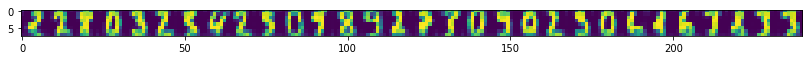

>> Epoch 391 finished 	RBM Reconstruction error 0.790465593
torch.Size([1797, 1, 8, 8])
>> Epoch 392 finished 	RBM Reconstruction error 0.962819040
torch.Size([1797, 1, 8, 8])
>> Epoch 393 finished 	RBM Reconstruction error 0.796623886
torch.Size([1797, 1, 8, 8])
>> Epoch 394 finished 	RBM Reconstruction error 0.996637940
torch.Size([1797, 1, 8, 8])
>> Epoch 395 finished 	RBM Reconstruction error 0.799839497
torch.Size([1797, 1, 8, 8])
>> Epoch 396 finished 	RBM Reconstruction error 1.023607731
torch.Size([1797, 1, 8, 8])
>> Epoch 397 finished 	RBM Reconstruction error 0.794654906
torch.Size([1797, 1, 8, 8])
>> Epoch 398 finished 	RBM Reconstruction error 0.987417758
torch.Size([1797, 1, 8, 8])
>> Epoch 399 finished 	RBM Reconstruction error 0.779722273
torch.Size([1797, 1, 8, 8])
>> Epoch 400 finished 	RBM Reconstruction error 0.922210991
[END] Pre-training step


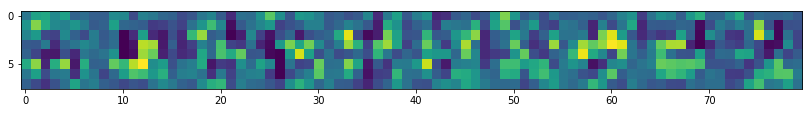

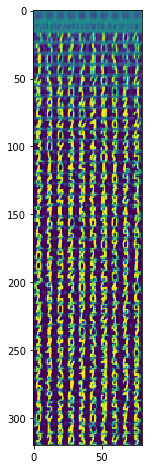

In [59]:

ims2 = []
i = 0
print_every = 5
i_hidden_bias = -1.
_n_epochs=400

def run_mnist():
    from sklearn.datasets import load_digits

    global ims2, i, print_every, i_hidden_bias, _n_epochs
    ims2 = []
    i = 0
    print_every = 10
    i_hidden_bias = -2
    _n_epochs=400
    
    #load data
    X_mnist = load_digits().data
    X_mnist = Variable(torch.Tensor(X_mnist.reshape((-1, 1, 8, 8)) / 16.))

    # hyperparameters
    structure_kernel_size = [3,3]
    optimization_algorithm="sgd"
    learning_rate_rbm=.1
    n_epochs_rbm=-1
    contrastive_divergence_iter=2
    batch_size=128
    verbose=True
    weight_decay=.001

    channels = [(1, 20)]#, (15, 10), (10, 5)]

    dbn3 = UnsupervisedDBN(structure_kernel_size,
                          channels=channels,
                          learning_rate_rbm=learning_rate_rbm,
                          n_epochs_rbm=n_epochs_rbm,
                          contrastive_divergence_iter=contrastive_divergence_iter,
                          batch_size=batch_size,
                          verbose=verbose,
                          weight_decay=weight_decay)

    print("MNIST")

    dbn3.fit(X_mnist)
    dbn3.plot_samples(10, top_down=False)
    return dbn3, ims2


dbn3, im3 = run_mnist()


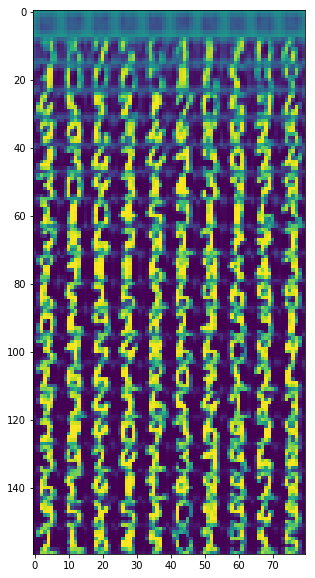

In [77]:
plt.rcParams["figure.figsize"] = (5,10)
convert_to_image(im3)

In [128]:
        
def run_cifar10():
    global ims2, i, print_every, i_hidden_bias, _n_epochs
    
    #global variables
    ims2 = []
    i = 0
    print_every = 5
    i_hidden_bias = -3.
    _n_epochs=100

    structure_kernel_size = [3, 3]
    optimization_algorithm="sgd"
    learning_rate_rbm=1.
    n_epochs_rbm=-1
    contrastive_divergence_iter=1
    batch_size=64
    verbose=True
    weight_decay=.001

    channels = [(3, 10)]#, (15, 10), (10, 5)]

    dbn = UnsupervisedDBN(structure_kernel_size,
                          channels=channels,
                          learning_rate_rbm=learning_rate_rbm,
                          n_epochs_rbm=n_epochs_rbm,
                          contrastive_divergence_iter=contrastive_divergence_iter,
                          batch_size=batch_size,
                          verbose=verbose,
                          weight_decay=weight_decay)
    
    print("Cifar 10")

    dbn.fit(X_cifar)
    return dbn, ims2


dbn3, im4 = run_cifar10()


Cifar 10
3 (3, 10)
[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 262.331146240
>> Epoch 2 finished 	RBM Reconstruction error 242.860214233
>> Epoch 3 finished 	RBM Reconstruction error 231.475982666
>> Epoch 4 finished 	RBM Reconstruction error 224.989303589
>> Epoch 5 finished 	RBM Reconstruction error 221.339813232
>> Epoch 6 finished 	RBM Reconstruction error 219.307312012
>> Epoch 7 finished 	RBM Reconstruction error 218.180084229
>> Epoch 8 finished 	RBM Reconstruction error 217.557846069
>> Epoch 9 finished 	RBM Reconstruction error 217.216598511
>> Epoch 10 finished 	RBM Reconstruction error 217.031906128
>> Epoch 11 finished 	RBM Reconstruction error 216.933151245
>> Epoch 12 finished 	RBM Reconstruction error 216.881439209
>> Epoch 13 finished 	RBM Reconstruction error 216.855300903
>> Epoch 14 finished 	RBM Reconstruction error 216.842926025
>> Epoch 15 finished 	RBM Reconstruction error 216.837600708
>> Epoch 16 finished 	RBM Reconstruction error 2

(224, 320, 3)


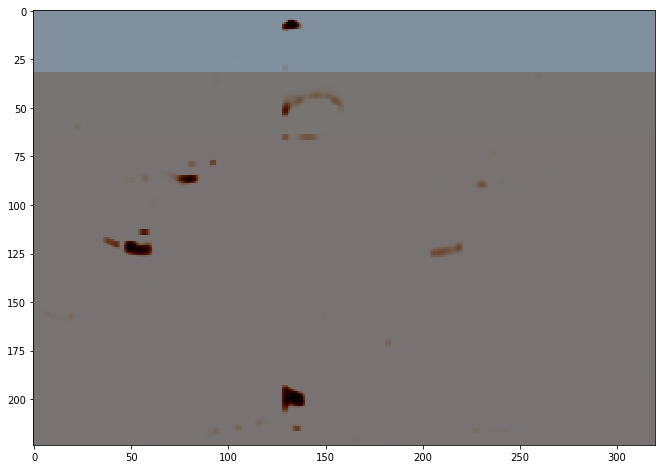

In [129]:

def convert_to_image(results, n =5, skip=2):
    convert = lambda x: np.squeeze(np.concatenate(np.split(np.transpose(x[:n], (0, 2, 3, 1)), np.arange(1, n), 0), 2))
    
    results = list(map(convert, results[::skip]))
    resulting_image = np.vstack(results)
    print(resulting_image.shape)
    plt.imshow(resulting_image)
    temp, plt.rcParams["figure.figsize"] = plt.rcParams["figure.figsize"],(20, 30)
    plt.show()
    plt.rcParams["figure.figsize"] = temp
    
convert_to_image(im4)

**Channels = 3**

In [130]:
        
def run_cifar10():
    global ims2, i, print_every, i_hidden_bias, _n_epochs
    
    #global variables
    ims2 = []
    i = 0
    print_every = 5
    i_hidden_bias = -1.
    _n_epochs=100

    structure_kernel_size = [3, 3]
    optimization_algorithm="sgd"
    learning_rate_rbm=.1
    n_epochs_rbm=-1
    contrastive_divergence_iter=3
    batch_size=64
    verbose=True
    weight_decay=.001

    channels = [(3, 3)]#, (15, 10), (10, 5)]

    dbn = UnsupervisedDBN(structure_kernel_size,
                          channels=channels,
                          learning_rate_rbm=learning_rate_rbm,
                          n_epochs_rbm=n_epochs_rbm,
                          contrastive_divergence_iter=contrastive_divergence_iter,
                          batch_size=batch_size,
                          verbose=verbose,
                          weight_decay=weight_decay)
    
    print("Cifar 10")

    dbn.fit(X_cifar)
    return dbn, ims2


dbn3, im5 = run_cifar10()


Cifar 10
3 (3, 3)
[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 280.333007812
>> Epoch 2 finished 	RBM Reconstruction error 276.925292969
>> Epoch 3 finished 	RBM Reconstruction error 273.645233154
>> Epoch 4 finished 	RBM Reconstruction error 270.497772217
>> Epoch 5 finished 	RBM Reconstruction error 267.476898193
>> Epoch 6 finished 	RBM Reconstruction error 264.585235596
>> Epoch 7 finished 	RBM Reconstruction error 261.815032959
>> Epoch 8 finished 	RBM Reconstruction error 259.164794922
>> Epoch 9 finished 	RBM Reconstruction error 256.628448486
>> Epoch 10 finished 	RBM Reconstruction error 254.203308105
>> Epoch 11 finished 	RBM Reconstruction error 251.887069702
>> Epoch 12 finished 	RBM Reconstruction error 249.673950195
>> Epoch 13 finished 	RBM Reconstruction error 247.561431885
>> Epoch 14 finished 	RBM Reconstruction error 245.543869019
>> Epoch 15 finished 	RBM Reconstruction error 243.617767334
>> Epoch 16 finished 	RBM Reconstruction error 24

(224, 320, 3)


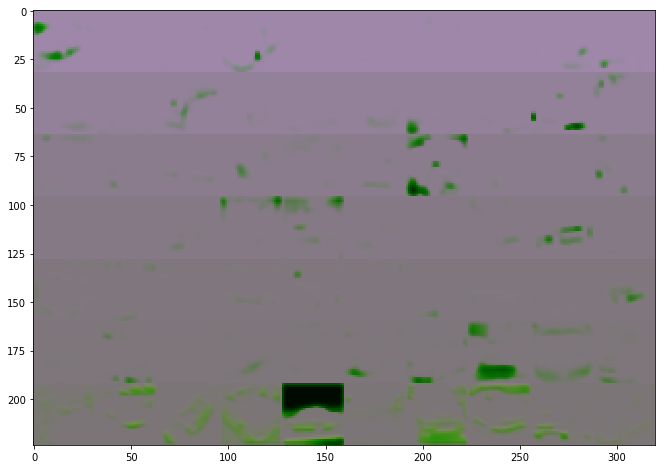

In [131]:
convert_to_image(im5)

**Channels = 15**

In [132]:
        
def run_cifar10():
    global ims2, i, print_every, i_hidden_bias, _n_epochs
    
    #global variables
    ims2 = []
    i = 0
    print_every = 5
    i_hidden_bias = -1.
    _n_epochs=100

    structure_kernel_size = [3, 3]
    optimization_algorithm="sgd"
    learning_rate_rbm=.1
    n_epochs_rbm=-1
    contrastive_divergence_iter=3
    batch_size=64
    verbose=True
    weight_decay=.001

    channels = [(3, 15)]#, (15, 10), (10, 5)]

    dbn = UnsupervisedDBN(structure_kernel_size,
                          channels=channels,
                          learning_rate_rbm=learning_rate_rbm,
                          n_epochs_rbm=n_epochs_rbm,
                          contrastive_divergence_iter=contrastive_divergence_iter,
                          batch_size=batch_size,
                          verbose=verbose,
                          weight_decay=weight_decay)
    
    print("Cifar 10")

    dbn.fit(X_cifar)
    return dbn, ims2


dbn3, im6 = run_cifar10()


Cifar 10
3 (3, 15)
[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 210.619293213
>> Epoch 2 finished 	RBM Reconstruction error 208.848526001
>> Epoch 3 finished 	RBM Reconstruction error 207.133468628
>> Epoch 4 finished 	RBM Reconstruction error 205.472808838
>> Epoch 5 finished 	RBM Reconstruction error 203.858352661
>> Epoch 6 finished 	RBM Reconstruction error 202.285079956
>> Epoch 7 finished 	RBM Reconstruction error 200.747665405
>> Epoch 8 finished 	RBM Reconstruction error 199.237899780
>> Epoch 9 finished 	RBM Reconstruction error 197.745712280
>> Epoch 10 finished 	RBM Reconstruction error 196.259902954
>> Epoch 11 finished 	RBM Reconstruction error 194.767364502
>> Epoch 12 finished 	RBM Reconstruction error 193.245895386
>> Epoch 13 finished 	RBM Reconstruction error 191.664810181
>> Epoch 14 finished 	RBM Reconstruction error 189.972106934
>> Epoch 15 finished 	RBM Reconstruction error 188.088455200
>> Epoch 16 finished 	RBM Reconstruction error 1

(224, 320, 3)


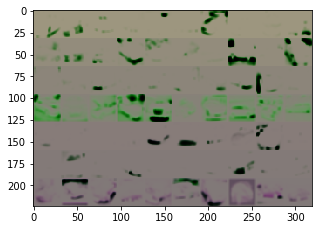

In [133]:
plt.rcParams["figure.figsize"] = (5,10)
convert_to_image(im6)

In [149]:
        
def run_cifar10():
    global ims2, i, print_every, i_hidden_bias, _n_epochs
    
    #global variables
    ims2 = []
    i = 0
    print_every = 5
    i_hidden_bias = -2.
    _n_epochs=160

    structure_kernel_size = [4, 4]
    optimization_algorithm="sgd"
    learning_rate_rbm=.2
    n_epochs_rbm=-1
    contrastive_divergence_iter=1
    batch_size=32
    verbose=True
    weight_decay=.001

    channels = [(3, 30)]#, (15, 10), (10, 5)]

    dbn = UnsupervisedDBN(structure_kernel_size,
                          channels=channels,
                          learning_rate_rbm=learning_rate_rbm,
                          n_epochs_rbm=n_epochs_rbm,
                          contrastive_divergence_iter=contrastive_divergence_iter,
                          batch_size=batch_size,
                          verbose=verbose,
                          weight_decay=weight_decay)
    
    print("Cifar 10")

    dbn.fit(X_cifar)
    return dbn, ims2


dbn3, im7 = run_cifar10()


def convert_to_image(results, n =5, skip=2):
    convert = lambda x: np.squeeze(np.concatenate(np.split(np.transpose(x[:n], (0, 2, 3, 1)), np.arange(1, n), 0), 2))
    
    results = list(map(convert, results[::skip]))
    resulting_image = np.vstack(results)
    print(resulting_image.shape)
    plt.imshow(resulting_image)
    temp, plt.rcParams["figure.figsize"] = plt.rcParams["figure.figsize"],(20, 30)
    plt.show()
    plt.rcParams["figure.figsize"] = temp
    



Cifar 10
4 (3, 30)
[START] Pre-training step:


KeyboardInterrupt: 

(512, 160, 3)


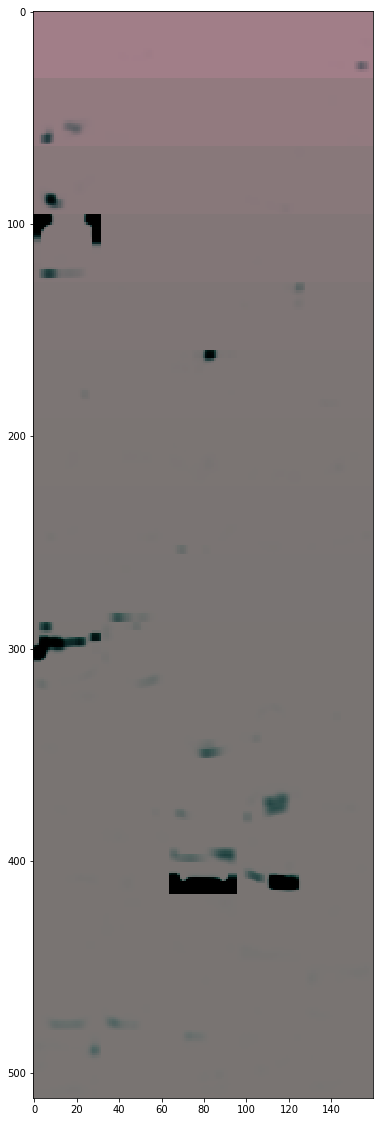

In [150]:
convert_to_image(im7)

Cifar 10
5 (3, 40)
[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 333.802490234
>> Epoch 2 finished 	RBM Reconstruction error 323.859252930
>> Epoch 3 finished 	RBM Reconstruction error 314.642730713
>> Epoch 4 finished 	RBM Reconstruction error 306.121093750
>> Epoch 5 finished 	RBM Reconstruction error 298.259704590
>> Epoch 6 finished 	RBM Reconstruction error 291.021759033
>> Epoch 7 finished 	RBM Reconstruction error 284.375396729
>> Epoch 8 finished 	RBM Reconstruction error 278.278106689
>> Epoch 9 finished 	RBM Reconstruction error 272.701751709
>> Epoch 10 finished 	RBM Reconstruction error 267.603363037
>> Epoch 11 finished 	RBM Reconstruction error 262.952026367
>> Epoch 12 finished 	RBM Reconstruction error 258.712249756
>> Epoch 13 finished 	RBM Reconstruction error 254.852493286
>> Epoch 14 finished 	RBM Reconstruction error 251.341842651
>> Epoch 15 finished 	RBM Reconstruction error 248.150329590
>> Epoch 16 finished 	RBM Reconstruction error 2

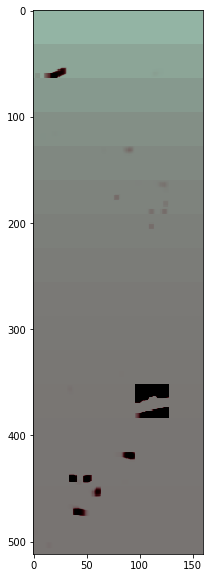

In [137]:
        
def run_cifar10():
    global ims2, i, print_every, i_hidden_bias, _n_epochs
    
    #global variables
    ims2 = []
    i = 0
    print_every = 3
    i_hidden_bias = -2.
    _n_epochs=96

    structure_kernel_size = [5, 5]
    optimization_algorithm="sgd"
    learning_rate_rbm=.2
    n_epochs_rbm=-1
    contrastive_divergence_iter=1
    batch_size=32
    verbose=True
    weight_decay=.001

    channels = [(3, 40)]#, (15, 10), (10, 5)]

    dbn = UnsupervisedDBN(structure_kernel_size,
                          channels=channels,
                          learning_rate_rbm=learning_rate_rbm,
                          n_epochs_rbm=n_epochs_rbm,
                          contrastive_divergence_iter=contrastive_divergence_iter,
                          batch_size=batch_size,
                          verbose=verbose,
                          weight_decay=weight_decay)
    
    print("Cifar 10")

    dbn.fit(X_cifar)
    return dbn, ims2


dbn3, im8 = run_cifar10()


def convert_to_image(results, n =5, skip=2):
    convert = lambda x: np.squeeze(np.concatenate(np.split(np.transpose(x[:n], (0, 2, 3, 1)), np.arange(1, n), 0), 2))
    
    results = list(map(convert, results[::skip]))
    resulting_image = np.vstack(results)
    print(resulting_image.shape)
    plt.imshow(resulting_image)
    
    plt.show()
    
    



(512, 160, 3)


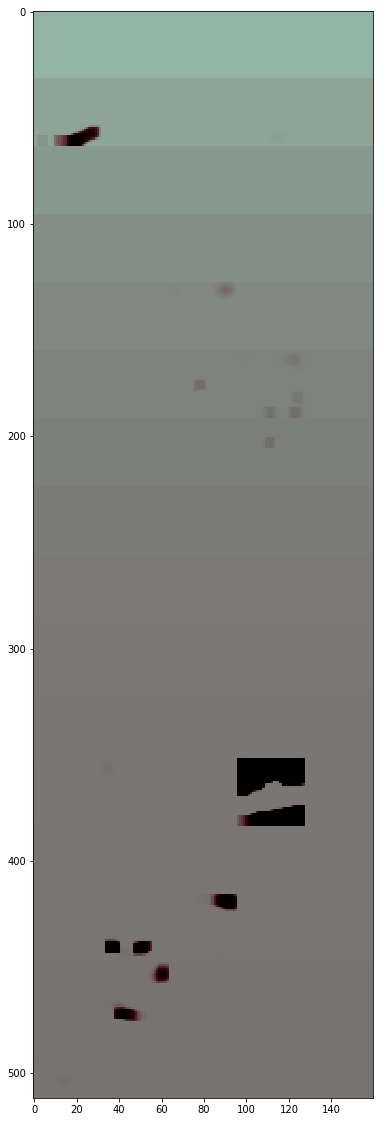

In [148]:
plt.rcParams["figure.figsize"] = (10, 20)
convert_to_image(im8)

In [138]:
        
def run_cifar10():
    global ims2, i, print_every, i_hidden_bias, _n_epochs
    
    #global variables
    ims2 = []
    i = 0
    print_every = 3
    i_hidden_bias = -2.
    _n_epochs=96

    structure_kernel_size = [5, 5]
    optimization_algorithm="sgd"
    learning_rate_rbm=.2
    n_epochs_rbm=-1
    contrastive_divergence_iter=1
    batch_size=32
    verbose=True
    weight_decay=.001

    channels = [(3, 40)]#, (15, 10), (10, 5)]

    dbn = UnsupervisedDBN(structure_kernel_size,
                          channels=channels,
                          learning_rate_rbm=learning_rate_rbm,
                          n_epochs_rbm=n_epochs_rbm,
                          contrastive_divergence_iter=contrastive_divergence_iter,
                          batch_size=batch_size,
                          verbose=verbose,
                          weight_decay=weight_decay)
    
    print("Cifar 10")

    dbn.fit(X_cifar)
    return dbn, ims2


dbn3, im9 = run_cifar10()


def convert_to_image(results, n =5, skip=2):
    convert = lambda x: np.squeeze(np.concatenate(np.split(np.transpose(x[:n], (0, 2, 3, 1)), np.arange(1, n), 0), 2))
    
    results = list(map(convert, results[::skip]))
    resulting_image = np.vstack(results)
    print(resulting_image.shape)
    plt.imshow(resulting_image)

    plt.show()

    

Cifar 10
5 (3, 40)
[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 273.703857422
>> Epoch 2 finished 	RBM Reconstruction error 268.569213867
>> Epoch 3 finished 	RBM Reconstruction error 263.864349365
>> Epoch 4 finished 	RBM Reconstruction error 259.559631348
>> Epoch 5 finished 	RBM Reconstruction error 255.629196167
>> Epoch 6 finished 	RBM Reconstruction error 252.043807983
>> Epoch 7 finished 	RBM Reconstruction error 248.776016235
>> Epoch 8 finished 	RBM Reconstruction error 245.804214478
>> Epoch 9 finished 	RBM Reconstruction error 243.101791382
>> Epoch 10 finished 	RBM Reconstruction error 240.647644043
>> Epoch 11 finished 	RBM Reconstruction error 238.420883179
>> Epoch 12 finished 	RBM Reconstruction error 236.400039673
>> Epoch 13 finished 	RBM Reconstruction error 234.569473267
>> Epoch 14 finished 	RBM Reconstruction error 232.911422729
>> Epoch 15 finished 	RBM Reconstruction error 231.410522461
>> Epoch 16 finished 	RBM Reconstruction error 2

KeyboardInterrupt: 

(832, 160, 3)


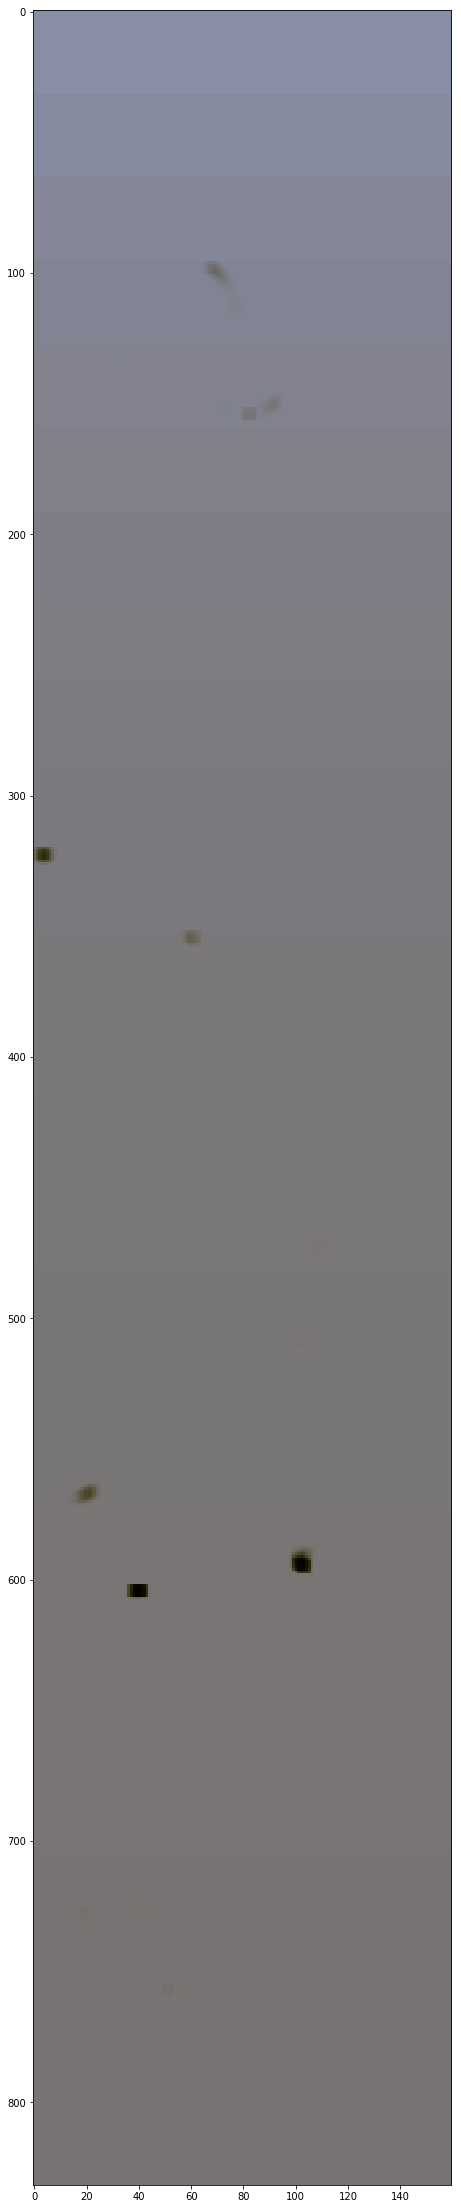

In [145]:
plt.rcParams["figure.figsize"] = (20, 4kk0)

convert_to_image(ims2, skip=1)


In [ ]:
#global variables
ims2 = []
i = 0
print_every = 5
i_hidden_bias = -1.
_n_epochs=40

# hyperparameters
structure_kernel_size = [5, 5]
optimization_algorithm="sgd"
learning_rate_rbm=.5
n_epochs_rbm=-1
contrastive_divergence_iter=3
batch_size=64
verbose=True
weight_decay=.001  
hidden = torch.sigmoid(F.conv2d(visible_units, self.kernel, stride=self.stride_n) + self.h_bias)


input_channels = 3
channels = [(1, 5), (5, 8)]#, (15, 10), (10, 5)]

dbn3 = UnsupervisedDBN(structure_kernel_size,
                      channels=channels,
                      input_channels=input_channels,
                      learning_rate_rbm=learning_rate_rbm,
                      n_epochs_rbm=n_epochs_rbm,
                      contrastive_divergence_iter=contrastive_divergence_iter,
                      batch_size=batch_size,
                      verbose=verbose,
                      weight_decay=weight_decay)
print("Cifar 10")

                       
dbn3.fit(X)
dbn3.plot_samples(10, top_down=False)